In [1]:
import numpy as np
import time
import keras

from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [3]:
def make_generator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation=keras.activations.relu, use_bias=True, input_shape=(3,)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16,activation=keras.activations.relu, use_bias=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(2))
    return model

In [4]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation=keras.activations.relu, use_bias=True, input_shape=(2,)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16,activation=keras.activations.relu, use_bias=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Dense(1))
    return model

In [5]:
class DCGAN(object):
    def __init__(self):

        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = make_discriminator_model()
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = make_generator_model()
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = keras.Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = keras.Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.AM

In [6]:
def get_y(x):
    return 10 + x*x


def sample_data(n):
    data = []

    xs = np.random.randint(-10,10,[n])

    for x in xs:
        y = get_y(x)
        data.append([x, y])

    return np.array(data)

In [9]:
class MNIST_DCGAN(object):
    def __init__(self):
        
        self.x_train = sample_data(5000).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[100, 3])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size)]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 3])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 3])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 3])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i]

        fig = plt.figure(figsize=(10,10))
        plt.scatter(images[:,0], images[:,1])

        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                48        
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 34        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________
____________

120: [D loss: 0.708901, acc: 0.615234]  [A loss: 6.038787, acc: 0.000000]
121: [D loss: 0.603333, acc: 0.599609]  [A loss: 6.062187, acc: 0.000000]
122: [D loss: 0.586515, acc: 0.578125]  [A loss: 6.507927, acc: 0.000000]
123: [D loss: 0.661747, acc: 0.585938]  [A loss: 6.014314, acc: 0.000000]
124: [D loss: 0.477429, acc: 0.603516]  [A loss: 6.330812, acc: 0.000000]
125: [D loss: 0.591531, acc: 0.597656]  [A loss: 6.249772, acc: 0.000000]
126: [D loss: 0.411567, acc: 0.601562]  [A loss: 6.357604, acc: 0.000000]
127: [D loss: 0.474280, acc: 0.619141]  [A loss: 6.997208, acc: 0.000000]
128: [D loss: 0.618125, acc: 0.607422]  [A loss: 6.888964, acc: 0.000000]
129: [D loss: 0.436417, acc: 0.591797]  [A loss: 5.983796, acc: 0.000000]
130: [D loss: 0.536762, acc: 0.570312]  [A loss: 5.671745, acc: 0.000000]
131: [D loss: 0.498679, acc: 0.595703]  [A loss: 6.396144, acc: 0.000000]
132: [D loss: 0.615352, acc: 0.587891]  [A loss: 6.921861, acc: 0.000000]
133: [D loss: 0.479315, acc: 0.605469]

278: [D loss: 0.117199, acc: 0.533203]  [A loss: 7.100136, acc: 0.000000]
279: [D loss: 0.179584, acc: 0.533203]  [A loss: 8.291800, acc: 0.000000]
280: [D loss: 0.029623, acc: 0.535156]  [A loss: 7.068349, acc: 0.000000]
281: [D loss: 0.020482, acc: 0.541016]  [A loss: 8.224295, acc: 0.000000]
282: [D loss: 0.147475, acc: 0.523438]  [A loss: 7.575095, acc: 0.000000]
283: [D loss: 0.077061, acc: 0.533203]  [A loss: 7.496352, acc: 0.000000]
284: [D loss: 0.109239, acc: 0.525391]  [A loss: 7.884081, acc: 0.000000]
285: [D loss: 0.088889, acc: 0.533203]  [A loss: 7.505342, acc: 0.000000]
286: [D loss: 0.078260, acc: 0.521484]  [A loss: 7.447525, acc: 0.000000]
287: [D loss: 0.079392, acc: 0.552734]  [A loss: 7.398221, acc: 0.000000]
288: [D loss: 0.050205, acc: 0.535156]  [A loss: 8.199315, acc: 0.000000]
289: [D loss: 0.017687, acc: 0.525391]  [A loss: 7.488602, acc: 0.000000]
290: [D loss: 0.078602, acc: 0.537109]  [A loss: 7.653899, acc: 0.000000]
291: [D loss: 0.046187, acc: 0.533203]

404: [D loss: 0.072483, acc: 0.507812]  [A loss: 10.143421, acc: 0.000000]
405: [D loss: 0.011448, acc: 0.515625]  [A loss: 10.309702, acc: 0.000000]
406: [D loss: 0.072873, acc: 0.513672]  [A loss: 9.728008, acc: 0.000000]
407: [D loss: 0.011413, acc: 0.513672]  [A loss: 9.919016, acc: 0.000000]
408: [D loss: 0.007864, acc: 0.513672]  [A loss: 10.120359, acc: 0.000000]
409: [D loss: 0.041135, acc: 0.517578]  [A loss: 9.821515, acc: 0.000000]
410: [D loss: 0.075158, acc: 0.515625]  [A loss: 10.384281, acc: 0.000000]
411: [D loss: 0.016173, acc: 0.523438]  [A loss: 10.529234, acc: 0.000000]
412: [D loss: 0.010443, acc: 0.523438]  [A loss: 9.754122, acc: 0.000000]
413: [D loss: 0.077993, acc: 0.511719]  [A loss: 10.567238, acc: 0.000000]
414: [D loss: 0.010287, acc: 0.511719]  [A loss: 10.275297, acc: 0.000000]
415: [D loss: 0.043164, acc: 0.519531]  [A loss: 10.637600, acc: 0.000000]
416: [D loss: 0.009298, acc: 0.523438]  [A loss: 10.690140, acc: 0.000000]
417: [D loss: 0.040008, acc: 

515: [D loss: 0.010940, acc: 0.513672]  [A loss: 12.133784, acc: 0.000000]
516: [D loss: 0.005377, acc: 0.507812]  [A loss: 12.752057, acc: 0.000000]
517: [D loss: 0.007056, acc: 0.507812]  [A loss: 12.151139, acc: 0.000000]
518: [D loss: 0.008253, acc: 0.513672]  [A loss: 12.405552, acc: 0.000000]
519: [D loss: 0.004540, acc: 0.511719]  [A loss: 12.166479, acc: 0.000000]
520: [D loss: 0.005167, acc: 0.507812]  [A loss: 12.334599, acc: 0.000000]
521: [D loss: 0.006566, acc: 0.511719]  [A loss: 12.626693, acc: 0.000000]
522: [D loss: 0.006070, acc: 0.507812]  [A loss: 12.838840, acc: 0.000000]
523: [D loss: 0.006993, acc: 0.511719]  [A loss: 12.735744, acc: 0.000000]
524: [D loss: 0.010934, acc: 0.515625]  [A loss: 12.458045, acc: 0.000000]
525: [D loss: 0.044671, acc: 0.517578]  [A loss: 12.219799, acc: 0.000000]
526: [D loss: 0.010957, acc: 0.511719]  [A loss: 11.830592, acc: 0.000000]
527: [D loss: 0.007371, acc: 0.501953]  [A loss: 12.388738, acc: 0.000000]
528: [D loss: 0.004852, a

625: [D loss: 0.004416, acc: 0.507812]  [A loss: 13.405941, acc: 0.000000]
626: [D loss: 0.005951, acc: 0.511719]  [A loss: 13.430977, acc: 0.000000]
627: [D loss: 0.008092, acc: 0.515625]  [A loss: 13.428722, acc: 0.000000]
628: [D loss: 0.009292, acc: 0.517578]  [A loss: 13.515985, acc: 0.000000]
629: [D loss: 0.009124, acc: 0.511719]  [A loss: 13.055628, acc: 0.000000]
630: [D loss: 0.006003, acc: 0.513672]  [A loss: 13.507854, acc: 0.003906]
631: [D loss: 0.004206, acc: 0.511719]  [A loss: 13.800026, acc: 0.000000]
632: [D loss: 0.006548, acc: 0.511719]  [A loss: 13.619379, acc: 0.000000]
633: [D loss: 0.006546, acc: 0.515625]  [A loss: 12.971140, acc: 0.000000]
634: [D loss: 0.003460, acc: 0.513672]  [A loss: 13.201870, acc: 0.000000]
635: [D loss: 0.038293, acc: 0.513672]  [A loss: 13.064732, acc: 0.000000]
636: [D loss: 0.005076, acc: 0.503906]  [A loss: 13.292551, acc: 0.000000]
637: [D loss: 0.037362, acc: 0.519531]  [A loss: 13.220827, acc: 0.000000]
638: [D loss: 0.004226, a

749: [D loss: 0.004198, acc: 0.511719]  [A loss: 14.310427, acc: 0.000000]
750: [D loss: 0.003795, acc: 0.507812]  [A loss: 13.971628, acc: 0.000000]
751: [D loss: 0.003081, acc: 0.515625]  [A loss: 13.989319, acc: 0.000000]
752: [D loss: 0.004804, acc: 0.517578]  [A loss: 14.094772, acc: 0.000000]
753: [D loss: 0.004454, acc: 0.503906]  [A loss: 13.956012, acc: 0.000000]
754: [D loss: 0.004058, acc: 0.505859]  [A loss: 13.527729, acc: 0.000000]
755: [D loss: 0.003025, acc: 0.519531]  [A loss: 14.010647, acc: 0.000000]
756: [D loss: 0.007215, acc: 0.517578]  [A loss: 14.380043, acc: 0.000000]
757: [D loss: 0.005543, acc: 0.511719]  [A loss: 14.066012, acc: 0.000000]
758: [D loss: 0.004180, acc: 0.511719]  [A loss: 13.655262, acc: 0.000000]
759: [D loss: 0.007657, acc: 0.505859]  [A loss: 14.091954, acc: 0.000000]
760: [D loss: 0.005924, acc: 0.507812]  [A loss: 14.669089, acc: 0.000000]
761: [D loss: 0.004707, acc: 0.505859]  [A loss: 14.662851, acc: 0.000000]
762: [D loss: 0.002576, a

864: [D loss: 0.002020, acc: 0.511719]  [A loss: 14.690969, acc: 0.000000]
865: [D loss: 0.002860, acc: 0.509766]  [A loss: 14.343765, acc: 0.000000]
866: [D loss: 0.001907, acc: 0.523438]  [A loss: 14.950062, acc: 0.000000]
867: [D loss: 0.002235, acc: 0.511719]  [A loss: 14.621155, acc: 0.000000]
868: [D loss: 0.001535, acc: 0.505859]  [A loss: 14.393209, acc: 0.000000]
869: [D loss: 0.005263, acc: 0.513672]  [A loss: 15.037174, acc: 0.000000]
870: [D loss: 0.006754, acc: 0.501953]  [A loss: 14.679085, acc: 0.000000]
871: [D loss: 0.004095, acc: 0.505859]  [A loss: 15.018305, acc: 0.000000]
872: [D loss: 0.003141, acc: 0.509766]  [A loss: 15.119566, acc: 0.000000]
873: [D loss: 0.002469, acc: 0.521484]  [A loss: 14.649602, acc: 0.000000]
874: [D loss: 0.001142, acc: 0.517578]  [A loss: 14.912848, acc: 0.000000]
875: [D loss: 0.001320, acc: 0.507812]  [A loss: 14.763784, acc: 0.000000]
876: [D loss: 0.006429, acc: 0.501953]  [A loss: 14.659012, acc: 0.000000]
877: [D loss: 0.003752, a

976: [D loss: 0.003384, acc: 0.501953]  [A loss: 14.830248, acc: 0.000000]
977: [D loss: 0.001271, acc: 0.503906]  [A loss: 15.087028, acc: 0.000000]
978: [D loss: 0.001259, acc: 0.515625]  [A loss: 15.366226, acc: 0.000000]
979: [D loss: 0.001490, acc: 0.511719]  [A loss: 15.280265, acc: 0.000000]
980: [D loss: 0.004778, acc: 0.513672]  [A loss: 15.073210, acc: 0.000000]
981: [D loss: 0.001544, acc: 0.507812]  [A loss: 15.664491, acc: 0.000000]
982: [D loss: 0.000918, acc: 0.513672]  [A loss: 15.454627, acc: 0.000000]
983: [D loss: 0.001109, acc: 0.521484]  [A loss: 15.434721, acc: 0.000000]
984: [D loss: 0.003567, acc: 0.509766]  [A loss: 15.452330, acc: 0.000000]
985: [D loss: 0.002800, acc: 0.523438]  [A loss: 15.240927, acc: 0.000000]
986: [D loss: 0.000927, acc: 0.507812]  [A loss: 15.299638, acc: 0.000000]
987: [D loss: 0.000870, acc: 0.505859]  [A loss: 15.397960, acc: 0.000000]
988: [D loss: 0.003226, acc: 0.507812]  [A loss: 15.384815, acc: 0.000000]
989: [D loss: 0.001412, a

1116: [D loss: 0.000553, acc: 0.513672]  [A loss: 15.529591, acc: 0.000000]
1117: [D loss: 0.003036, acc: 0.511719]  [A loss: 15.401065, acc: 0.000000]
1118: [D loss: 0.000779, acc: 0.511719]  [A loss: 15.400364, acc: 0.000000]
1119: [D loss: 0.001059, acc: 0.511719]  [A loss: 15.229176, acc: 0.000000]
1120: [D loss: 0.003737, acc: 0.511719]  [A loss: 15.482857, acc: 0.000000]
1121: [D loss: 0.003250, acc: 0.509766]  [A loss: 15.402987, acc: 0.000000]
1122: [D loss: 0.000543, acc: 0.507812]  [A loss: 15.402639, acc: 0.000000]
1123: [D loss: 0.001027, acc: 0.509766]  [A loss: 15.553345, acc: 0.000000]
1124: [D loss: 0.005617, acc: 0.509766]  [A loss: 15.552008, acc: 0.000000]
1125: [D loss: 0.000509, acc: 0.507812]  [A loss: 15.816797, acc: 0.000000]
1126: [D loss: 0.001182, acc: 0.503906]  [A loss: 15.378645, acc: 0.000000]
1127: [D loss: 0.001005, acc: 0.511719]  [A loss: 15.513416, acc: 0.000000]
1128: [D loss: 0.001854, acc: 0.509766]  [A loss: 15.688293, acc: 0.000000]
1129: [D los

1236: [D loss: 0.002834, acc: 0.509766]  [A loss: 15.452683, acc: 0.000000]
1237: [D loss: 0.000658, acc: 0.501953]  [A loss: 15.047077, acc: 0.000000]
1238: [D loss: 0.000614, acc: 0.505859]  [A loss: 15.202364, acc: 0.000000]
1239: [D loss: 0.001649, acc: 0.507812]  [A loss: 15.379051, acc: 0.000000]
1240: [D loss: 0.000843, acc: 0.505859]  [A loss: 15.587738, acc: 0.000000]
1241: [D loss: 0.002046, acc: 0.509766]  [A loss: 15.412428, acc: 0.000000]
1242: [D loss: 0.000745, acc: 0.505859]  [A loss: 15.583382, acc: 0.000000]
1243: [D loss: 0.003075, acc: 0.509766]  [A loss: 15.286055, acc: 0.000000]
1244: [D loss: 0.001495, acc: 0.505859]  [A loss: 15.190153, acc: 0.000000]
1245: [D loss: 0.000852, acc: 0.509766]  [A loss: 15.050374, acc: 0.000000]
1246: [D loss: 0.001738, acc: 0.511719]  [A loss: 15.433179, acc: 0.000000]
1247: [D loss: 0.001558, acc: 0.509766]  [A loss: 15.404393, acc: 0.003906]
1248: [D loss: 0.004332, acc: 0.505859]  [A loss: 15.459122, acc: 0.000000]
1249: [D los

1347: [D loss: 0.002420, acc: 0.507812]  [A loss: 15.392538, acc: 0.000000]
1348: [D loss: 0.001947, acc: 0.507812]  [A loss: 15.213408, acc: 0.000000]
1349: [D loss: 0.001934, acc: 0.507812]  [A loss: 15.705792, acc: 0.000000]
1350: [D loss: 0.002592, acc: 0.503906]  [A loss: 15.295401, acc: 0.003906]
1351: [D loss: 0.000966, acc: 0.505859]  [A loss: 15.009466, acc: 0.003906]
1352: [D loss: 0.009547, acc: 0.509766]  [A loss: 15.256282, acc: 0.000000]
1353: [D loss: 0.001750, acc: 0.507812]  [A loss: 15.677227, acc: 0.000000]
1354: [D loss: 0.001265, acc: 0.505859]  [A loss: 15.433204, acc: 0.003906]
1355: [D loss: 0.000990, acc: 0.505859]  [A loss: 15.540247, acc: 0.000000]
1356: [D loss: 0.003585, acc: 0.513672]  [A loss: 15.538780, acc: 0.000000]
1357: [D loss: 0.002696, acc: 0.509766]  [A loss: 15.367883, acc: 0.000000]
1358: [D loss: 0.000513, acc: 0.509766]  [A loss: 15.185102, acc: 0.000000]
1359: [D loss: 0.004116, acc: 0.505859]  [A loss: 15.172966, acc: 0.000000]
1360: [D los

1475: [D loss: 0.001130, acc: 0.511719]  [A loss: 15.395054, acc: 0.000000]
1476: [D loss: 0.000731, acc: 0.503906]  [A loss: 15.371290, acc: 0.000000]
1477: [D loss: 0.003682, acc: 0.517578]  [A loss: 15.227854, acc: 0.000000]
1478: [D loss: 0.002163, acc: 0.509766]  [A loss: 15.096265, acc: 0.000000]
1479: [D loss: 0.002718, acc: 0.509766]  [A loss: 15.487217, acc: 0.000000]
1480: [D loss: 0.001576, acc: 0.519531]  [A loss: 15.539442, acc: 0.000000]
1481: [D loss: 0.002687, acc: 0.511719]  [A loss: 15.646356, acc: 0.003906]
1482: [D loss: 0.001231, acc: 0.509766]  [A loss: 15.323329, acc: 0.000000]
1483: [D loss: 0.000969, acc: 0.509766]  [A loss: 15.261325, acc: 0.000000]
1484: [D loss: 0.000857, acc: 0.509766]  [A loss: 15.119306, acc: 0.000000]
1485: [D loss: 0.002109, acc: 0.509766]  [A loss: 15.420717, acc: 0.000000]
1486: [D loss: 0.002294, acc: 0.513672]  [A loss: 15.332275, acc: 0.000000]
1487: [D loss: 0.004840, acc: 0.507812]  [A loss: 15.211708, acc: 0.000000]
1488: [D los

1606: [D loss: 0.000837, acc: 0.509766]  [A loss: 15.313223, acc: 0.000000]
1607: [D loss: 0.005483, acc: 0.515625]  [A loss: 15.250063, acc: 0.000000]
1608: [D loss: 0.003528, acc: 0.509766]  [A loss: 15.287116, acc: 0.003906]
1609: [D loss: 0.008809, acc: 0.513672]  [A loss: 15.322136, acc: 0.007812]
1610: [D loss: 0.000887, acc: 0.511719]  [A loss: 15.257807, acc: 0.003906]
1611: [D loss: 0.004992, acc: 0.507812]  [A loss: 15.533134, acc: 0.000000]
1612: [D loss: 0.005558, acc: 0.503906]  [A loss: 15.278650, acc: 0.000000]
1613: [D loss: 0.004225, acc: 0.517578]  [A loss: 15.633711, acc: 0.000000]
1614: [D loss: 0.008816, acc: 0.507812]  [A loss: 15.314413, acc: 0.000000]
1615: [D loss: 0.005671, acc: 0.515625]  [A loss: 15.375610, acc: 0.000000]
1616: [D loss: 0.005480, acc: 0.507812]  [A loss: 15.559139, acc: 0.000000]
1617: [D loss: 0.001837, acc: 0.511719]  [A loss: 15.215881, acc: 0.000000]
1618: [D loss: 0.002650, acc: 0.509766]  [A loss: 15.599207, acc: 0.000000]
1619: [D los

1736: [D loss: 0.001832, acc: 0.515625]  [A loss: 15.374629, acc: 0.000000]
1737: [D loss: 0.002239, acc: 0.513672]  [A loss: 15.360039, acc: 0.000000]
1738: [D loss: 0.001419, acc: 0.511719]  [A loss: 15.916384, acc: 0.000000]
1739: [D loss: 0.000918, acc: 0.509766]  [A loss: 15.411474, acc: 0.000000]
1740: [D loss: 0.001631, acc: 0.511719]  [A loss: 15.598715, acc: 0.000000]
1741: [D loss: 0.000243, acc: 0.517578]  [A loss: 15.500015, acc: 0.000000]
1742: [D loss: 0.004261, acc: 0.519531]  [A loss: 15.757920, acc: 0.000000]
1743: [D loss: 0.000921, acc: 0.511719]  [A loss: 15.651097, acc: 0.000000]
1744: [D loss: 0.000834, acc: 0.513672]  [A loss: 15.616621, acc: 0.000000]
1745: [D loss: 0.003639, acc: 0.517578]  [A loss: 15.602816, acc: 0.003906]
1746: [D loss: 0.002156, acc: 0.517578]  [A loss: 15.320921, acc: 0.003906]
1747: [D loss: 0.000808, acc: 0.503906]  [A loss: 15.340210, acc: 0.007812]
1748: [D loss: 0.000934, acc: 0.515625]  [A loss: 15.526927, acc: 0.000000]
1749: [D los

1865: [D loss: 0.001323, acc: 0.511719]  [A loss: 15.415123, acc: 0.000000]
1866: [D loss: 0.003206, acc: 0.507812]  [A loss: 15.512442, acc: 0.000000]
1867: [D loss: 0.001315, acc: 0.505859]  [A loss: 15.497322, acc: 0.000000]
1868: [D loss: 0.002204, acc: 0.515625]  [A loss: 15.468476, acc: 0.003906]
1869: [D loss: 0.000814, acc: 0.517578]  [A loss: 15.519870, acc: 0.000000]
1870: [D loss: 0.002261, acc: 0.517578]  [A loss: 15.507399, acc: 0.003906]
1871: [D loss: 0.000864, acc: 0.509766]  [A loss: 15.330094, acc: 0.000000]
1872: [D loss: 0.000196, acc: 0.507812]  [A loss: 15.389858, acc: 0.000000]
1873: [D loss: 0.001052, acc: 0.515625]  [A loss: 15.642338, acc: 0.000000]
1874: [D loss: 0.002337, acc: 0.509766]  [A loss: 15.620677, acc: 0.000000]
1875: [D loss: 0.001013, acc: 0.515625]  [A loss: 15.455824, acc: 0.003906]
1876: [D loss: 0.002482, acc: 0.513672]  [A loss: 15.478342, acc: 0.000000]
1877: [D loss: 0.001909, acc: 0.507812]  [A loss: 15.388309, acc: 0.000000]
1878: [D los

1995: [D loss: 0.001473, acc: 0.503906]  [A loss: 15.192974, acc: 0.003906]
1996: [D loss: 0.003736, acc: 0.513672]  [A loss: 15.837559, acc: 0.000000]
1997: [D loss: 0.010510, acc: 0.519531]  [A loss: 15.467968, acc: 0.000000]
1998: [D loss: 0.000520, acc: 0.513672]  [A loss: 15.567959, acc: 0.000000]
1999: [D loss: 0.002784, acc: 0.500000]  [A loss: 15.701271, acc: 0.000000]
2000: [D loss: 0.000388, acc: 0.509766]  [A loss: 15.498803, acc: 0.000000]
2001: [D loss: 0.000768, acc: 0.507812]  [A loss: 15.735819, acc: 0.003906]
2002: [D loss: 0.002996, acc: 0.500000]  [A loss: 15.322909, acc: 0.000000]
2003: [D loss: 0.001647, acc: 0.507812]  [A loss: 15.734180, acc: 0.000000]
2004: [D loss: 0.001417, acc: 0.505859]  [A loss: 15.526283, acc: 0.007812]
2005: [D loss: 0.002987, acc: 0.507812]  [A loss: 15.502939, acc: 0.003906]
2006: [D loss: 0.000756, acc: 0.509766]  [A loss: 15.756697, acc: 0.000000]
2007: [D loss: 0.003098, acc: 0.511719]  [A loss: 15.646170, acc: 0.000000]
2008: [D los

2132: [D loss: 0.003351, acc: 0.494141]  [A loss: 15.167760, acc: 0.000000]
2133: [D loss: 0.000747, acc: 0.486328]  [A loss: 15.534987, acc: 0.000000]
2134: [D loss: 0.001929, acc: 0.480469]  [A loss: 15.261859, acc: 0.003906]
2135: [D loss: 0.001313, acc: 0.484375]  [A loss: 15.743248, acc: 0.000000]
2136: [D loss: 0.002991, acc: 0.476562]  [A loss: 15.355717, acc: 0.000000]
2137: [D loss: 0.002466, acc: 0.474609]  [A loss: 15.449302, acc: 0.000000]
2138: [D loss: 0.044388, acc: 0.490234]  [A loss: 15.387024, acc: 0.003906]
2139: [D loss: 0.004806, acc: 0.474609]  [A loss: 15.159595, acc: 0.003906]
2140: [D loss: 0.005494, acc: 0.458984]  [A loss: 15.183128, acc: 0.003906]
2141: [D loss: 0.006894, acc: 0.466797]  [A loss: 15.287471, acc: 0.000000]
2142: [D loss: 0.002594, acc: 0.484375]  [A loss: 15.349524, acc: 0.000000]
2143: [D loss: 0.000804, acc: 0.494141]  [A loss: 15.446767, acc: 0.011719]
2144: [D loss: 0.004013, acc: 0.478516]  [A loss: 15.472826, acc: 0.007812]
2145: [D los

2257: [D loss: 0.006249, acc: 0.466797]  [A loss: 15.466881, acc: 0.000000]
2258: [D loss: 0.008637, acc: 0.460938]  [A loss: 15.546280, acc: 0.000000]
2259: [D loss: 0.003679, acc: 0.457031]  [A loss: 15.591516, acc: 0.000000]
2260: [D loss: 0.002918, acc: 0.455078]  [A loss: 15.136309, acc: 0.003906]
2261: [D loss: 0.004130, acc: 0.472656]  [A loss: 15.284691, acc: 0.003906]
2262: [D loss: 0.003573, acc: 0.449219]  [A loss: 15.145535, acc: 0.007812]
2263: [D loss: 0.001834, acc: 0.470703]  [A loss: 15.496605, acc: 0.003906]
2264: [D loss: 0.002339, acc: 0.466797]  [A loss: 15.225252, acc: 0.011719]
2265: [D loss: 0.004051, acc: 0.472656]  [A loss: 15.250178, acc: 0.003906]
2266: [D loss: 0.003545, acc: 0.455078]  [A loss: 15.353853, acc: 0.003906]
2267: [D loss: 0.001466, acc: 0.474609]  [A loss: 15.282196, acc: 0.011719]
2268: [D loss: 0.005631, acc: 0.480469]  [A loss: 15.578812, acc: 0.000000]
2269: [D loss: 0.001066, acc: 0.460938]  [A loss: 15.326627, acc: 0.007812]
2270: [D los

2374: [D loss: 0.003395, acc: 0.435547]  [A loss: 15.369946, acc: 0.000000]
2375: [D loss: 0.003786, acc: 0.443359]  [A loss: 15.454624, acc: 0.003906]
2376: [D loss: 0.002131, acc: 0.404297]  [A loss: 15.249158, acc: 0.003906]
2377: [D loss: 0.004514, acc: 0.412109]  [A loss: 15.360643, acc: 0.003906]
2378: [D loss: 0.000681, acc: 0.419922]  [A loss: 15.425767, acc: 0.015625]
2379: [D loss: 0.003318, acc: 0.404297]  [A loss: 15.426409, acc: 0.007812]
2380: [D loss: 0.004066, acc: 0.429688]  [A loss: 15.532816, acc: 0.015625]
2381: [D loss: 0.006543, acc: 0.421875]  [A loss: 15.177551, acc: 0.007812]
2382: [D loss: 0.004359, acc: 0.437500]  [A loss: 15.365529, acc: 0.003906]
2383: [D loss: 0.002391, acc: 0.421875]  [A loss: 15.095396, acc: 0.003906]
2384: [D loss: 0.001824, acc: 0.429688]  [A loss: 15.312119, acc: 0.000000]
2385: [D loss: 0.043824, acc: 0.431641]  [A loss: 15.541865, acc: 0.000000]
2386: [D loss: 0.003638, acc: 0.412109]  [A loss: 15.825105, acc: 0.007812]
2387: [D los

2492: [D loss: 0.000294, acc: 0.353516]  [A loss: 15.276827, acc: 0.007812]
2493: [D loss: 0.007008, acc: 0.369141]  [A loss: 15.516272, acc: 0.000000]
2494: [D loss: 0.009210, acc: 0.357422]  [A loss: 15.290267, acc: 0.011719]
2495: [D loss: 0.033903, acc: 0.353516]  [A loss: 15.428778, acc: 0.007812]
2496: [D loss: 0.038679, acc: 0.392578]  [A loss: 15.291781, acc: 0.000000]
2497: [D loss: 0.000963, acc: 0.355469]  [A loss: 14.946187, acc: 0.007812]
2498: [D loss: 0.005244, acc: 0.359375]  [A loss: 15.154160, acc: 0.011719]
2499: [D loss: 0.003671, acc: 0.351562]  [A loss: 15.080542, acc: 0.011719]
2500: [D loss: 0.003539, acc: 0.367188]  [A loss: 15.115791, acc: 0.011719]
2501: [D loss: 0.005203, acc: 0.341797]  [A loss: 15.493931, acc: 0.011719]
2502: [D loss: 0.004334, acc: 0.351562]  [A loss: 15.445925, acc: 0.007812]
2503: [D loss: 0.002755, acc: 0.351562]  [A loss: 15.273661, acc: 0.007812]
2504: [D loss: 0.004062, acc: 0.386719]  [A loss: 14.999970, acc: 0.015625]
2505: [D los

2617: [D loss: 0.007088, acc: 0.339844]  [A loss: 15.380470, acc: 0.007812]
2618: [D loss: 0.033528, acc: 0.341797]  [A loss: 15.229687, acc: 0.003906]
2619: [D loss: 0.004145, acc: 0.339844]  [A loss: 15.327271, acc: 0.011719]
2620: [D loss: 0.006528, acc: 0.339844]  [A loss: 15.300128, acc: 0.007812]
2621: [D loss: 0.004599, acc: 0.349609]  [A loss: 15.017037, acc: 0.003906]
2622: [D loss: 0.005772, acc: 0.324219]  [A loss: 15.175530, acc: 0.003906]
2623: [D loss: 0.040315, acc: 0.339844]  [A loss: 15.439790, acc: 0.003906]
2624: [D loss: 0.020331, acc: 0.339844]  [A loss: 15.354267, acc: 0.007812]
2625: [D loss: 0.007249, acc: 0.324219]  [A loss: 15.026955, acc: 0.007812]
2626: [D loss: 0.005595, acc: 0.357422]  [A loss: 15.255912, acc: 0.015625]
2627: [D loss: 0.008114, acc: 0.328125]  [A loss: 15.544522, acc: 0.003906]
2628: [D loss: 0.004350, acc: 0.337891]  [A loss: 15.109487, acc: 0.007812]
2629: [D loss: 0.004082, acc: 0.341797]  [A loss: 15.022559, acc: 0.007812]
2630: [D los

2741: [D loss: 0.003527, acc: 0.296875]  [A loss: 15.521607, acc: 0.003906]
2742: [D loss: 0.008079, acc: 0.322266]  [A loss: 15.178048, acc: 0.007812]
2743: [D loss: 0.002793, acc: 0.308594]  [A loss: 15.409253, acc: 0.000000]
2744: [D loss: 0.007541, acc: 0.277344]  [A loss: 15.273440, acc: 0.011719]
2745: [D loss: 0.002236, acc: 0.333984]  [A loss: 15.116276, acc: 0.019531]
2746: [D loss: 0.005935, acc: 0.318359]  [A loss: 15.246121, acc: 0.011719]
2747: [D loss: 0.014357, acc: 0.306641]  [A loss: 15.041337, acc: 0.007812]
2748: [D loss: 0.002035, acc: 0.287109]  [A loss: 15.560441, acc: 0.000000]
2749: [D loss: 0.001232, acc: 0.300781]  [A loss: 15.117271, acc: 0.003906]
2750: [D loss: 0.008551, acc: 0.308594]  [A loss: 15.333514, acc: 0.003906]
2751: [D loss: 0.004804, acc: 0.296875]  [A loss: 15.355894, acc: 0.019531]
2752: [D loss: 0.036911, acc: 0.292969]  [A loss: 15.330242, acc: 0.019531]
2753: [D loss: 0.004253, acc: 0.275391]  [A loss: 15.482518, acc: 0.007812]
2754: [D los

2909: [D loss: 0.012444, acc: 0.296875]  [A loss: 14.922874, acc: 0.003906]
2910: [D loss: 0.005618, acc: 0.285156]  [A loss: 14.660787, acc: 0.019531]
2911: [D loss: 0.014016, acc: 0.291016]  [A loss: 14.418253, acc: 0.023438]
2912: [D loss: 0.005196, acc: 0.300781]  [A loss: 15.412508, acc: 0.015625]
2913: [D loss: 0.011097, acc: 0.300781]  [A loss: 14.795831, acc: 0.019531]
2914: [D loss: 0.012716, acc: 0.296875]  [A loss: 15.488571, acc: 0.015625]
2915: [D loss: 0.005773, acc: 0.285156]  [A loss: 15.092950, acc: 0.011719]
2916: [D loss: 0.006082, acc: 0.275391]  [A loss: 15.428940, acc: 0.007812]
2917: [D loss: 0.004797, acc: 0.279297]  [A loss: 15.166002, acc: 0.007812]
2918: [D loss: 0.007873, acc: 0.289062]  [A loss: 15.476362, acc: 0.011719]
2919: [D loss: 0.007533, acc: 0.310547]  [A loss: 15.086652, acc: 0.007812]
2920: [D loss: 0.004383, acc: 0.281250]  [A loss: 15.312285, acc: 0.003906]
2921: [D loss: 0.009544, acc: 0.316406]  [A loss: 15.385036, acc: 0.007812]
2922: [D los

3043: [D loss: 0.012769, acc: 0.292969]  [A loss: 14.809557, acc: 0.015625]
3044: [D loss: 0.010560, acc: 0.294922]  [A loss: 15.227811, acc: 0.011719]
3045: [D loss: 0.017851, acc: 0.273438]  [A loss: 14.361149, acc: 0.019531]
3046: [D loss: 0.010339, acc: 0.294922]  [A loss: 14.740553, acc: 0.011719]
3047: [D loss: 0.012452, acc: 0.287109]  [A loss: 14.992109, acc: 0.019531]
3048: [D loss: 0.016571, acc: 0.294922]  [A loss: 15.249805, acc: 0.011719]
3049: [D loss: 0.042761, acc: 0.292969]  [A loss: 14.915428, acc: 0.019531]
3050: [D loss: 0.007287, acc: 0.251953]  [A loss: 14.929407, acc: 0.003906]
3051: [D loss: 0.008476, acc: 0.287109]  [A loss: 15.074571, acc: 0.015625]
3052: [D loss: 0.014212, acc: 0.269531]  [A loss: 14.488807, acc: 0.015625]
3053: [D loss: 0.007411, acc: 0.277344]  [A loss: 14.488277, acc: 0.039062]
3054: [D loss: 0.018064, acc: 0.285156]  [A loss: 14.976950, acc: 0.007812]
3055: [D loss: 0.021290, acc: 0.298828]  [A loss: 14.932423, acc: 0.019531]
3056: [D los

3166: [D loss: 0.019794, acc: 0.291016]  [A loss: 15.249117, acc: 0.015625]
3167: [D loss: 0.043700, acc: 0.281250]  [A loss: 14.769384, acc: 0.015625]
3168: [D loss: 0.018379, acc: 0.273438]  [A loss: 15.263264, acc: 0.015625]
3169: [D loss: 0.015434, acc: 0.291016]  [A loss: 14.649800, acc: 0.023438]
3170: [D loss: 0.018072, acc: 0.292969]  [A loss: 15.056670, acc: 0.027344]
3171: [D loss: 0.022406, acc: 0.277344]  [A loss: 15.316047, acc: 0.011719]
3172: [D loss: 0.007463, acc: 0.285156]  [A loss: 14.638278, acc: 0.015625]
3173: [D loss: 0.018951, acc: 0.257812]  [A loss: 14.803663, acc: 0.019531]
3174: [D loss: 0.015045, acc: 0.271484]  [A loss: 15.049301, acc: 0.015625]
3175: [D loss: 0.011818, acc: 0.283203]  [A loss: 14.635179, acc: 0.011719]
3176: [D loss: 0.010267, acc: 0.261719]  [A loss: 14.411076, acc: 0.023438]
3177: [D loss: 0.022997, acc: 0.281250]  [A loss: 14.485086, acc: 0.011719]
3178: [D loss: 0.016548, acc: 0.271484]  [A loss: 14.618042, acc: 0.015625]
3179: [D los

3335: [D loss: 0.018099, acc: 0.228516]  [A loss: 15.231281, acc: 0.019531]
3336: [D loss: 0.020146, acc: 0.236328]  [A loss: 14.665149, acc: 0.023438]
3337: [D loss: 0.012874, acc: 0.220703]  [A loss: 15.494653, acc: 0.011719]
3338: [D loss: 0.045025, acc: 0.265625]  [A loss: 15.265128, acc: 0.011719]
3339: [D loss: 0.016528, acc: 0.248047]  [A loss: 15.187030, acc: 0.023438]
3340: [D loss: 0.011287, acc: 0.242188]  [A loss: 14.679847, acc: 0.019531]
3341: [D loss: 0.016983, acc: 0.236328]  [A loss: 15.129763, acc: 0.023438]
3342: [D loss: 0.023724, acc: 0.240234]  [A loss: 14.751778, acc: 0.035156]
3343: [D loss: 0.016404, acc: 0.244141]  [A loss: 14.691837, acc: 0.039062]
3344: [D loss: 0.009684, acc: 0.263672]  [A loss: 15.278248, acc: 0.019531]
3345: [D loss: 0.048837, acc: 0.238281]  [A loss: 15.077620, acc: 0.015625]
3346: [D loss: 0.012817, acc: 0.255859]  [A loss: 14.753435, acc: 0.031250]
3347: [D loss: 0.015922, acc: 0.232422]  [A loss: 15.004768, acc: 0.019531]
3348: [D los

3445: [D loss: 0.014651, acc: 0.218750]  [A loss: 14.799562, acc: 0.023438]
3446: [D loss: 0.112283, acc: 0.250000]  [A loss: 14.869963, acc: 0.019531]
3447: [D loss: 0.021484, acc: 0.265625]  [A loss: 15.062689, acc: 0.031250]
3448: [D loss: 0.015519, acc: 0.255859]  [A loss: 15.079901, acc: 0.027344]
3449: [D loss: 0.023480, acc: 0.222656]  [A loss: 14.751382, acc: 0.019531]
3450: [D loss: 0.019401, acc: 0.240234]  [A loss: 14.848154, acc: 0.023438]
3451: [D loss: 0.018650, acc: 0.253906]  [A loss: 14.714429, acc: 0.027344]
3452: [D loss: 0.008244, acc: 0.242188]  [A loss: 14.726439, acc: 0.019531]
3453: [D loss: 0.055434, acc: 0.265625]  [A loss: 15.009980, acc: 0.023438]
3454: [D loss: 0.049571, acc: 0.230469]  [A loss: 15.373734, acc: 0.011719]
3455: [D loss: 0.019189, acc: 0.244141]  [A loss: 14.840599, acc: 0.027344]
3456: [D loss: 0.012160, acc: 0.267578]  [A loss: 14.996958, acc: 0.015625]
3457: [D loss: 0.011843, acc: 0.218750]  [A loss: 14.974426, acc: 0.027344]
3458: [D los

3573: [D loss: 0.048599, acc: 0.234375]  [A loss: 14.386644, acc: 0.035156]
3574: [D loss: 0.054999, acc: 0.224609]  [A loss: 14.094508, acc: 0.046875]
3575: [D loss: 0.031302, acc: 0.222656]  [A loss: 14.420591, acc: 0.039062]
3576: [D loss: 0.044168, acc: 0.263672]  [A loss: 14.603497, acc: 0.031250]
3577: [D loss: 0.066192, acc: 0.259766]  [A loss: 14.550011, acc: 0.031250]
3578: [D loss: 0.050828, acc: 0.242188]  [A loss: 14.588490, acc: 0.046875]
3579: [D loss: 0.058930, acc: 0.265625]  [A loss: 14.236212, acc: 0.031250]
3580: [D loss: 0.020576, acc: 0.269531]  [A loss: 13.755975, acc: 0.031250]
3581: [D loss: 0.017421, acc: 0.244141]  [A loss: 14.766041, acc: 0.023438]
3582: [D loss: 0.030748, acc: 0.263672]  [A loss: 14.393481, acc: 0.027344]
3583: [D loss: 0.059868, acc: 0.259766]  [A loss: 14.534676, acc: 0.015625]
3584: [D loss: 0.060589, acc: 0.269531]  [A loss: 14.016928, acc: 0.035156]
3585: [D loss: 0.013749, acc: 0.259766]  [A loss: 14.928291, acc: 0.027344]
3586: [D los

3681: [D loss: 0.119904, acc: 0.277344]  [A loss: 14.171463, acc: 0.035156]
3682: [D loss: 0.020065, acc: 0.257812]  [A loss: 14.391290, acc: 0.039062]
3683: [D loss: 0.081540, acc: 0.250000]  [A loss: 14.561781, acc: 0.027344]
3684: [D loss: 0.104511, acc: 0.283203]  [A loss: 14.479299, acc: 0.039062]
3685: [D loss: 0.033145, acc: 0.244141]  [A loss: 14.573051, acc: 0.015625]
3686: [D loss: 0.028370, acc: 0.294922]  [A loss: 15.080203, acc: 0.019531]
3687: [D loss: 0.055044, acc: 0.257812]  [A loss: 14.326761, acc: 0.031250]
3688: [D loss: 0.064627, acc: 0.259766]  [A loss: 14.007048, acc: 0.046875]
3689: [D loss: 0.096664, acc: 0.261719]  [A loss: 14.668069, acc: 0.019531]
3690: [D loss: 0.097450, acc: 0.251953]  [A loss: 14.552029, acc: 0.039062]
3691: [D loss: 0.022867, acc: 0.263672]  [A loss: 13.865742, acc: 0.046875]
3692: [D loss: 0.036166, acc: 0.277344]  [A loss: 14.288509, acc: 0.031250]
3693: [D loss: 0.024691, acc: 0.267578]  [A loss: 13.984443, acc: 0.031250]
3694: [D los

3807: [D loss: 0.075749, acc: 0.275391]  [A loss: 14.613870, acc: 0.023438]
3808: [D loss: 0.036398, acc: 0.271484]  [A loss: 15.060558, acc: 0.015625]
3809: [D loss: 0.023635, acc: 0.287109]  [A loss: 14.292629, acc: 0.031250]
3810: [D loss: 0.026172, acc: 0.298828]  [A loss: 14.381647, acc: 0.035156]
3811: [D loss: 0.034386, acc: 0.298828]  [A loss: 14.621254, acc: 0.031250]
3812: [D loss: 0.030286, acc: 0.240234]  [A loss: 14.323133, acc: 0.039062]
3813: [D loss: 0.024390, acc: 0.300781]  [A loss: 14.001160, acc: 0.046875]
3814: [D loss: 0.074781, acc: 0.259766]  [A loss: 14.466990, acc: 0.011719]
3815: [D loss: 0.058401, acc: 0.263672]  [A loss: 14.149089, acc: 0.039062]
3816: [D loss: 0.061608, acc: 0.257812]  [A loss: 14.262209, acc: 0.027344]
3817: [D loss: 0.022643, acc: 0.236328]  [A loss: 14.257202, acc: 0.031250]
3818: [D loss: 0.127142, acc: 0.312500]  [A loss: 14.048903, acc: 0.058594]
3819: [D loss: 0.075272, acc: 0.271484]  [A loss: 14.718954, acc: 0.027344]
3820: [D los

3932: [D loss: 0.037799, acc: 0.285156]  [A loss: 14.244812, acc: 0.046875]
3933: [D loss: 0.032617, acc: 0.271484]  [A loss: 14.266455, acc: 0.039062]
3934: [D loss: 0.059669, acc: 0.259766]  [A loss: 14.345831, acc: 0.035156]
3935: [D loss: 0.034494, acc: 0.291016]  [A loss: 14.872209, acc: 0.019531]
3936: [D loss: 0.023845, acc: 0.275391]  [A loss: 14.188564, acc: 0.042969]
3937: [D loss: 0.091265, acc: 0.292969]  [A loss: 14.425974, acc: 0.039062]
3938: [D loss: 0.100687, acc: 0.277344]  [A loss: 13.548382, acc: 0.042969]
3939: [D loss: 0.068694, acc: 0.251953]  [A loss: 14.153970, acc: 0.039062]
3940: [D loss: 0.095855, acc: 0.257812]  [A loss: 14.439053, acc: 0.035156]
3941: [D loss: 0.113049, acc: 0.261719]  [A loss: 14.677923, acc: 0.023438]
3942: [D loss: 0.040449, acc: 0.275391]  [A loss: 13.391755, acc: 0.062500]
3943: [D loss: 0.096238, acc: 0.275391]  [A loss: 14.369314, acc: 0.039062]
3944: [D loss: 0.125361, acc: 0.269531]  [A loss: 13.850796, acc: 0.058594]
3945: [D los

4063: [D loss: 0.070584, acc: 0.273438]  [A loss: 13.617531, acc: 0.058594]
4064: [D loss: 0.078999, acc: 0.267578]  [A loss: 14.124180, acc: 0.039062]
4065: [D loss: 0.034768, acc: 0.273438]  [A loss: 14.300165, acc: 0.035156]
4066: [D loss: 0.106879, acc: 0.267578]  [A loss: 14.075341, acc: 0.039062]
4067: [D loss: 0.079014, acc: 0.310547]  [A loss: 14.126938, acc: 0.046875]
4068: [D loss: 0.093992, acc: 0.326172]  [A loss: 13.988485, acc: 0.046875]
4069: [D loss: 0.037131, acc: 0.287109]  [A loss: 14.418179, acc: 0.031250]
4070: [D loss: 0.106266, acc: 0.287109]  [A loss: 13.522925, acc: 0.058594]
4071: [D loss: 0.067071, acc: 0.318359]  [A loss: 13.735800, acc: 0.070312]
4072: [D loss: 0.047584, acc: 0.292969]  [A loss: 14.009171, acc: 0.031250]
4073: [D loss: 0.097330, acc: 0.291016]  [A loss: 13.680634, acc: 0.058594]
4074: [D loss: 0.052674, acc: 0.310547]  [A loss: 14.462715, acc: 0.035156]
4075: [D loss: 0.101390, acc: 0.306641]  [A loss: 14.226415, acc: 0.042969]
4076: [D los

4229: [D loss: 0.122940, acc: 0.314453]  [A loss: 13.033335, acc: 0.093750]
4230: [D loss: 0.141657, acc: 0.285156]  [A loss: 13.802937, acc: 0.035156]
4231: [D loss: 0.173205, acc: 0.279297]  [A loss: 14.006626, acc: 0.050781]
4232: [D loss: 0.126089, acc: 0.292969]  [A loss: 13.315792, acc: 0.066406]
4233: [D loss: 0.105450, acc: 0.314453]  [A loss: 13.819766, acc: 0.058594]
4234: [D loss: 0.095667, acc: 0.343750]  [A loss: 13.872025, acc: 0.054688]
4235: [D loss: 0.133110, acc: 0.306641]  [A loss: 13.562021, acc: 0.050781]
4236: [D loss: 0.145140, acc: 0.302734]  [A loss: 13.882432, acc: 0.035156]
4237: [D loss: 0.096168, acc: 0.324219]  [A loss: 13.767420, acc: 0.027344]
4238: [D loss: 0.084178, acc: 0.326172]  [A loss: 13.814168, acc: 0.039062]
4239: [D loss: 0.110869, acc: 0.291016]  [A loss: 14.221573, acc: 0.035156]
4240: [D loss: 0.113131, acc: 0.306641]  [A loss: 13.936037, acc: 0.050781]
4241: [D loss: 0.096013, acc: 0.269531]  [A loss: 13.600187, acc: 0.070312]
4242: [D los

4352: [D loss: 0.211067, acc: 0.294922]  [A loss: 12.900763, acc: 0.089844]
4353: [D loss: 0.208873, acc: 0.343750]  [A loss: 13.660744, acc: 0.066406]
4354: [D loss: 0.288991, acc: 0.267578]  [A loss: 13.194830, acc: 0.089844]
4355: [D loss: 0.251815, acc: 0.337891]  [A loss: 12.678921, acc: 0.066406]
4356: [D loss: 0.098996, acc: 0.302734]  [A loss: 13.746223, acc: 0.078125]
4357: [D loss: 0.230876, acc: 0.285156]  [A loss: 13.196930, acc: 0.074219]
4358: [D loss: 0.148687, acc: 0.320312]  [A loss: 12.946846, acc: 0.066406]
4359: [D loss: 0.189198, acc: 0.357422]  [A loss: 12.907288, acc: 0.066406]
4360: [D loss: 0.159438, acc: 0.302734]  [A loss: 13.482575, acc: 0.070312]
4361: [D loss: 0.171516, acc: 0.326172]  [A loss: 12.868625, acc: 0.074219]
4362: [D loss: 0.183908, acc: 0.289062]  [A loss: 13.160516, acc: 0.058594]
4363: [D loss: 0.137715, acc: 0.318359]  [A loss: 13.260599, acc: 0.078125]
4364: [D loss: 0.166394, acc: 0.324219]  [A loss: 14.013559, acc: 0.062500]
4365: [D los

4475: [D loss: 0.126552, acc: 0.296875]  [A loss: 13.107990, acc: 0.074219]
4476: [D loss: 0.346853, acc: 0.330078]  [A loss: 13.199459, acc: 0.058594]
4477: [D loss: 0.165454, acc: 0.339844]  [A loss: 13.785172, acc: 0.050781]
4478: [D loss: 0.212224, acc: 0.332031]  [A loss: 13.271831, acc: 0.066406]
4479: [D loss: 0.193898, acc: 0.345703]  [A loss: 13.257682, acc: 0.062500]
4480: [D loss: 0.143443, acc: 0.294922]  [A loss: 12.912024, acc: 0.082031]
4481: [D loss: 0.140787, acc: 0.335938]  [A loss: 13.161694, acc: 0.078125]
4482: [D loss: 0.272246, acc: 0.296875]  [A loss: 12.796945, acc: 0.109375]
4483: [D loss: 0.263043, acc: 0.318359]  [A loss: 13.245720, acc: 0.062500]
4484: [D loss: 0.205466, acc: 0.314453]  [A loss: 13.066857, acc: 0.082031]
4485: [D loss: 0.164760, acc: 0.308594]  [A loss: 13.023230, acc: 0.074219]
4486: [D loss: 0.319511, acc: 0.308594]  [A loss: 13.651718, acc: 0.058594]
4487: [D loss: 0.177174, acc: 0.322266]  [A loss: 12.540002, acc: 0.097656]
4488: [D los

4644: [D loss: 0.294950, acc: 0.322266]  [A loss: 12.712301, acc: 0.078125]
4645: [D loss: 0.365056, acc: 0.312500]  [A loss: 13.210724, acc: 0.042969]
4646: [D loss: 0.274172, acc: 0.333984]  [A loss: 12.459206, acc: 0.082031]
4647: [D loss: 0.316768, acc: 0.339844]  [A loss: 12.225327, acc: 0.093750]
4648: [D loss: 0.323692, acc: 0.310547]  [A loss: 12.696213, acc: 0.093750]
4649: [D loss: 0.359250, acc: 0.304688]  [A loss: 12.506769, acc: 0.078125]
4650: [D loss: 0.213948, acc: 0.332031]  [A loss: 12.582743, acc: 0.093750]
4651: [D loss: 0.312974, acc: 0.355469]  [A loss: 12.941581, acc: 0.078125]
4652: [D loss: 0.281583, acc: 0.343750]  [A loss: 13.289968, acc: 0.093750]
4653: [D loss: 0.297567, acc: 0.345703]  [A loss: 13.220710, acc: 0.039062]
4654: [D loss: 0.287216, acc: 0.306641]  [A loss: 13.080225, acc: 0.070312]
4655: [D loss: 0.268152, acc: 0.322266]  [A loss: 13.775368, acc: 0.078125]
4656: [D loss: 0.220511, acc: 0.324219]  [A loss: 12.616887, acc: 0.101562]
4657: [D los

4756: [D loss: 0.235651, acc: 0.337891]  [A loss: 12.941904, acc: 0.066406]
4757: [D loss: 0.354316, acc: 0.328125]  [A loss: 12.930210, acc: 0.093750]
4758: [D loss: 0.350499, acc: 0.304688]  [A loss: 12.833230, acc: 0.078125]
4759: [D loss: 0.268647, acc: 0.306641]  [A loss: 12.362915, acc: 0.121094]
4760: [D loss: 0.261698, acc: 0.353516]  [A loss: 13.946895, acc: 0.070312]
4761: [D loss: 0.268932, acc: 0.357422]  [A loss: 12.875157, acc: 0.113281]
4762: [D loss: 0.216390, acc: 0.335938]  [A loss: 12.808677, acc: 0.085938]
4763: [D loss: 0.224832, acc: 0.345703]  [A loss: 13.169643, acc: 0.062500]
4764: [D loss: 0.403580, acc: 0.324219]  [A loss: 12.736898, acc: 0.085938]
4765: [D loss: 0.382850, acc: 0.330078]  [A loss: 13.134430, acc: 0.074219]
4766: [D loss: 0.251933, acc: 0.312500]  [A loss: 13.200740, acc: 0.062500]
4767: [D loss: 0.231889, acc: 0.363281]  [A loss: 12.335637, acc: 0.109375]
4768: [D loss: 0.311933, acc: 0.339844]  [A loss: 13.297708, acc: 0.066406]
4769: [D los

4870: [D loss: 0.302284, acc: 0.384766]  [A loss: 11.930904, acc: 0.136719]
4871: [D loss: 0.257844, acc: 0.355469]  [A loss: 11.851103, acc: 0.125000]
4872: [D loss: 0.297553, acc: 0.337891]  [A loss: 12.995193, acc: 0.078125]
4873: [D loss: 0.557056, acc: 0.363281]  [A loss: 12.494030, acc: 0.101562]
4874: [D loss: 0.382309, acc: 0.332031]  [A loss: 12.096129, acc: 0.121094]
4875: [D loss: 0.477038, acc: 0.296875]  [A loss: 13.247558, acc: 0.074219]
4876: [D loss: 0.415259, acc: 0.322266]  [A loss: 11.748001, acc: 0.089844]
4877: [D loss: 0.225765, acc: 0.394531]  [A loss: 12.383722, acc: 0.097656]
4878: [D loss: 0.524780, acc: 0.326172]  [A loss: 11.529552, acc: 0.125000]
4879: [D loss: 0.514591, acc: 0.351562]  [A loss: 12.240084, acc: 0.082031]
4880: [D loss: 0.379329, acc: 0.343750]  [A loss: 12.121750, acc: 0.093750]
4881: [D loss: 0.277894, acc: 0.349609]  [A loss: 12.276701, acc: 0.097656]
4882: [D loss: 0.595686, acc: 0.382812]  [A loss: 13.322681, acc: 0.070312]
4883: [D los

4990: [D loss: 0.368548, acc: 0.341797]  [A loss: 12.131355, acc: 0.074219]
4991: [D loss: 0.357247, acc: 0.361328]  [A loss: 12.510748, acc: 0.085938]
4992: [D loss: 0.369931, acc: 0.378906]  [A loss: 11.814306, acc: 0.152344]
4993: [D loss: 0.400914, acc: 0.386719]  [A loss: 12.016254, acc: 0.105469]
4994: [D loss: 0.387138, acc: 0.361328]  [A loss: 11.927582, acc: 0.097656]
4995: [D loss: 0.315203, acc: 0.330078]  [A loss: 11.745986, acc: 0.148438]
4996: [D loss: 0.324478, acc: 0.369141]  [A loss: 11.624611, acc: 0.097656]
4997: [D loss: 0.311810, acc: 0.382812]  [A loss: 11.555641, acc: 0.105469]
4998: [D loss: 0.310773, acc: 0.357422]  [A loss: 12.676851, acc: 0.082031]
4999: [D loss: 0.339380, acc: 0.316406]  [A loss: 11.575102, acc: 0.093750]
5000: [D loss: 0.430171, acc: 0.408203]  [A loss: 12.252184, acc: 0.101562]
5001: [D loss: 0.435813, acc: 0.388672]  [A loss: 12.188864, acc: 0.101562]
5002: [D loss: 0.308878, acc: 0.390625]  [A loss: 11.715929, acc: 0.121094]
5003: [D los

5130: [D loss: 0.722494, acc: 0.382812]  [A loss: 10.960835, acc: 0.109375]
5131: [D loss: 0.554558, acc: 0.406250]  [A loss: 11.308222, acc: 0.128906]
5132: [D loss: 0.648482, acc: 0.390625]  [A loss: 11.154390, acc: 0.132812]
5133: [D loss: 0.721506, acc: 0.394531]  [A loss: 10.553774, acc: 0.140625]
5134: [D loss: 0.814033, acc: 0.396484]  [A loss: 11.108367, acc: 0.125000]
5135: [D loss: 0.499755, acc: 0.394531]  [A loss: 11.084250, acc: 0.132812]
5136: [D loss: 0.526617, acc: 0.419922]  [A loss: 10.733051, acc: 0.179688]
5137: [D loss: 0.481457, acc: 0.394531]  [A loss: 11.311718, acc: 0.152344]
5138: [D loss: 0.781478, acc: 0.365234]  [A loss: 10.699484, acc: 0.164062]
5139: [D loss: 0.638852, acc: 0.414062]  [A loss: 10.656342, acc: 0.148438]
5140: [D loss: 0.767528, acc: 0.392578]  [A loss: 10.070097, acc: 0.152344]
5141: [D loss: 0.660895, acc: 0.382812]  [A loss: 10.486622, acc: 0.171875]
5142: [D loss: 0.642872, acc: 0.416016]  [A loss: 11.083465, acc: 0.144531]
5143: [D los

5253: [D loss: 0.788081, acc: 0.412109]  [A loss: 10.369169, acc: 0.156250]
5254: [D loss: 0.712435, acc: 0.375000]  [A loss: 10.967490, acc: 0.156250]
5255: [D loss: 0.898252, acc: 0.376953]  [A loss: 10.256263, acc: 0.175781]
5256: [D loss: 0.834196, acc: 0.414062]  [A loss: 10.911581, acc: 0.132812]
5257: [D loss: 1.071122, acc: 0.394531]  [A loss: 10.164944, acc: 0.183594]
5258: [D loss: 0.728432, acc: 0.380859]  [A loss: 10.004905, acc: 0.175781]
5259: [D loss: 0.765268, acc: 0.392578]  [A loss: 9.703925, acc: 0.164062]
5260: [D loss: 0.758275, acc: 0.410156]  [A loss: 9.513165, acc: 0.207031]
5261: [D loss: 0.591014, acc: 0.386719]  [A loss: 10.572865, acc: 0.125000]
5262: [D loss: 0.855996, acc: 0.394531]  [A loss: 10.389139, acc: 0.183594]
5263: [D loss: 0.874633, acc: 0.423828]  [A loss: 10.404545, acc: 0.156250]
5264: [D loss: 0.671672, acc: 0.365234]  [A loss: 9.610882, acc: 0.167969]
5265: [D loss: 0.676499, acc: 0.392578]  [A loss: 10.402895, acc: 0.179688]
5266: [D loss: 

5378: [D loss: 0.698406, acc: 0.435547]  [A loss: 10.625118, acc: 0.140625]
5379: [D loss: 0.664280, acc: 0.382812]  [A loss: 10.391224, acc: 0.140625]
5380: [D loss: 0.727332, acc: 0.419922]  [A loss: 10.385532, acc: 0.160156]
5381: [D loss: 0.560405, acc: 0.388672]  [A loss: 10.055698, acc: 0.152344]
5382: [D loss: 0.569720, acc: 0.419922]  [A loss: 10.371367, acc: 0.167969]
5383: [D loss: 0.753356, acc: 0.414062]  [A loss: 10.203482, acc: 0.152344]
5384: [D loss: 0.717216, acc: 0.433594]  [A loss: 10.515430, acc: 0.125000]
5385: [D loss: 0.498975, acc: 0.441406]  [A loss: 11.003912, acc: 0.152344]
5386: [D loss: 0.694048, acc: 0.408203]  [A loss: 10.402915, acc: 0.132812]
5387: [D loss: 0.718917, acc: 0.410156]  [A loss: 11.129879, acc: 0.128906]
5388: [D loss: 0.798154, acc: 0.447266]  [A loss: 10.702415, acc: 0.140625]
5389: [D loss: 0.597287, acc: 0.451172]  [A loss: 9.443813, acc: 0.144531]
5390: [D loss: 0.639171, acc: 0.417969]  [A loss: 10.302740, acc: 0.179688]
5391: [D loss

5500: [D loss: 0.816094, acc: 0.429688]  [A loss: 9.478846, acc: 0.136719]
5501: [D loss: 0.826124, acc: 0.443359]  [A loss: 10.704725, acc: 0.152344]
5502: [D loss: 0.845779, acc: 0.470703]  [A loss: 10.166838, acc: 0.203125]
5503: [D loss: 0.500939, acc: 0.460938]  [A loss: 10.563215, acc: 0.160156]
5504: [D loss: 0.796404, acc: 0.435547]  [A loss: 9.881661, acc: 0.152344]
5505: [D loss: 0.818605, acc: 0.406250]  [A loss: 9.493506, acc: 0.175781]
5506: [D loss: 0.948624, acc: 0.414062]  [A loss: 10.309298, acc: 0.156250]
5507: [D loss: 0.940872, acc: 0.455078]  [A loss: 10.213924, acc: 0.167969]
5508: [D loss: 0.841141, acc: 0.451172]  [A loss: 10.115437, acc: 0.160156]
5509: [D loss: 0.856789, acc: 0.408203]  [A loss: 10.018494, acc: 0.171875]
5510: [D loss: 0.678995, acc: 0.429688]  [A loss: 9.626357, acc: 0.167969]
5511: [D loss: 0.961390, acc: 0.445312]  [A loss: 10.143148, acc: 0.152344]
5512: [D loss: 0.779759, acc: 0.400391]  [A loss: 10.398407, acc: 0.156250]
5513: [D loss: 0

5626: [D loss: 0.821022, acc: 0.464844]  [A loss: 8.549480, acc: 0.187500]
5627: [D loss: 0.988149, acc: 0.453125]  [A loss: 10.290156, acc: 0.144531]
5628: [D loss: 0.974579, acc: 0.445312]  [A loss: 10.022294, acc: 0.160156]
5629: [D loss: 1.025172, acc: 0.447266]  [A loss: 8.760654, acc: 0.203125]
5630: [D loss: 0.712734, acc: 0.435547]  [A loss: 9.779666, acc: 0.152344]
5631: [D loss: 0.737108, acc: 0.453125]  [A loss: 10.463284, acc: 0.125000]
5632: [D loss: 0.893694, acc: 0.460938]  [A loss: 9.907562, acc: 0.156250]
5633: [D loss: 0.999672, acc: 0.462891]  [A loss: 9.569517, acc: 0.210938]
5634: [D loss: 0.929259, acc: 0.427734]  [A loss: 10.705130, acc: 0.156250]
5635: [D loss: 0.907236, acc: 0.455078]  [A loss: 9.035541, acc: 0.183594]
5636: [D loss: 1.192918, acc: 0.455078]  [A loss: 9.893079, acc: 0.175781]
5637: [D loss: 1.105955, acc: 0.445312]  [A loss: 9.352747, acc: 0.175781]
5638: [D loss: 1.210251, acc: 0.449219]  [A loss: 9.980537, acc: 0.148438]
5639: [D loss: 0.8826

5738: [D loss: 0.807870, acc: 0.484375]  [A loss: 10.479796, acc: 0.132812]
5739: [D loss: 0.877649, acc: 0.468750]  [A loss: 9.655363, acc: 0.167969]
5740: [D loss: 0.883329, acc: 0.462891]  [A loss: 9.552713, acc: 0.183594]
5741: [D loss: 0.818312, acc: 0.476562]  [A loss: 8.929541, acc: 0.167969]
5742: [D loss: 0.680471, acc: 0.507812]  [A loss: 9.826447, acc: 0.171875]
5743: [D loss: 0.771078, acc: 0.500000]  [A loss: 9.319942, acc: 0.203125]
5744: [D loss: 1.189674, acc: 0.458984]  [A loss: 9.168888, acc: 0.210938]
5745: [D loss: 1.045842, acc: 0.476562]  [A loss: 9.401291, acc: 0.203125]
5746: [D loss: 0.906714, acc: 0.488281]  [A loss: 10.114278, acc: 0.144531]
5747: [D loss: 1.143207, acc: 0.482422]  [A loss: 10.893306, acc: 0.117188]
5748: [D loss: 0.872679, acc: 0.476562]  [A loss: 10.166544, acc: 0.164062]
5749: [D loss: 0.714045, acc: 0.492188]  [A loss: 9.965299, acc: 0.167969]
5750: [D loss: 1.059759, acc: 0.474609]  [A loss: 9.283085, acc: 0.156250]
5751: [D loss: 0.9362

5904: [D loss: 1.207443, acc: 0.482422]  [A loss: 9.162785, acc: 0.164062]
5905: [D loss: 0.793577, acc: 0.470703]  [A loss: 8.857826, acc: 0.191406]
5906: [D loss: 0.970810, acc: 0.464844]  [A loss: 8.998922, acc: 0.156250]
5907: [D loss: 0.893348, acc: 0.484375]  [A loss: 8.850965, acc: 0.210938]
5908: [D loss: 0.634806, acc: 0.496094]  [A loss: 9.056484, acc: 0.164062]
5909: [D loss: 1.114231, acc: 0.472656]  [A loss: 8.633100, acc: 0.175781]
5910: [D loss: 0.878784, acc: 0.457031]  [A loss: 9.460417, acc: 0.171875]
5911: [D loss: 1.021902, acc: 0.455078]  [A loss: 9.582716, acc: 0.167969]
5912: [D loss: 0.906256, acc: 0.494141]  [A loss: 9.957114, acc: 0.160156]
5913: [D loss: 1.158788, acc: 0.449219]  [A loss: 9.975855, acc: 0.164062]
5914: [D loss: 0.819574, acc: 0.470703]  [A loss: 9.100710, acc: 0.191406]
5915: [D loss: 0.726503, acc: 0.517578]  [A loss: 9.110540, acc: 0.179688]
5916: [D loss: 0.863258, acc: 0.492188]  [A loss: 9.403946, acc: 0.195312]
5917: [D loss: 1.124245, 

6050: [D loss: 0.838921, acc: 0.488281]  [A loss: 8.807364, acc: 0.222656]
6051: [D loss: 1.172684, acc: 0.490234]  [A loss: 9.077318, acc: 0.175781]
6052: [D loss: 1.197996, acc: 0.464844]  [A loss: 9.155005, acc: 0.183594]
6053: [D loss: 0.994569, acc: 0.507812]  [A loss: 9.332361, acc: 0.195312]
6054: [D loss: 0.763141, acc: 0.513672]  [A loss: 8.874517, acc: 0.199219]
6055: [D loss: 0.962766, acc: 0.482422]  [A loss: 8.538736, acc: 0.203125]
6056: [D loss: 1.043116, acc: 0.488281]  [A loss: 9.374825, acc: 0.148438]
6057: [D loss: 1.091950, acc: 0.476562]  [A loss: 8.538193, acc: 0.183594]
6058: [D loss: 1.062281, acc: 0.480469]  [A loss: 8.446211, acc: 0.199219]
6059: [D loss: 1.079059, acc: 0.472656]  [A loss: 8.487483, acc: 0.238281]
6060: [D loss: 0.705760, acc: 0.507812]  [A loss: 8.422716, acc: 0.214844]
6061: [D loss: 0.760019, acc: 0.500000]  [A loss: 9.151484, acc: 0.179688]
6062: [D loss: 0.933929, acc: 0.468750]  [A loss: 8.780853, acc: 0.191406]
6063: [D loss: 1.172629, 

6177: [D loss: 0.798307, acc: 0.511719]  [A loss: 7.551593, acc: 0.257812]
6178: [D loss: 0.965024, acc: 0.498047]  [A loss: 7.963881, acc: 0.234375]
6179: [D loss: 1.246680, acc: 0.500000]  [A loss: 7.149946, acc: 0.250000]
6180: [D loss: 1.156902, acc: 0.486328]  [A loss: 8.548561, acc: 0.203125]
6181: [D loss: 1.150385, acc: 0.453125]  [A loss: 7.327911, acc: 0.277344]
6182: [D loss: 0.839838, acc: 0.466797]  [A loss: 8.419977, acc: 0.210938]
6183: [D loss: 1.104872, acc: 0.486328]  [A loss: 8.470333, acc: 0.199219]
6184: [D loss: 1.092368, acc: 0.505859]  [A loss: 8.255919, acc: 0.160156]
6185: [D loss: 1.119206, acc: 0.484375]  [A loss: 7.367623, acc: 0.253906]
6186: [D loss: 1.058575, acc: 0.449219]  [A loss: 8.283339, acc: 0.242188]
6187: [D loss: 1.037781, acc: 0.449219]  [A loss: 8.144898, acc: 0.207031]
6188: [D loss: 1.200605, acc: 0.441406]  [A loss: 8.402966, acc: 0.214844]
6189: [D loss: 1.028645, acc: 0.490234]  [A loss: 8.075582, acc: 0.222656]
6190: [D loss: 1.157373, 

6293: [D loss: 0.995342, acc: 0.488281]  [A loss: 7.821940, acc: 0.210938]
6294: [D loss: 1.071337, acc: 0.478516]  [A loss: 8.496443, acc: 0.207031]
6295: [D loss: 0.803389, acc: 0.462891]  [A loss: 8.114293, acc: 0.222656]
6296: [D loss: 1.050654, acc: 0.474609]  [A loss: 7.243710, acc: 0.242188]
6297: [D loss: 1.022502, acc: 0.482422]  [A loss: 8.019073, acc: 0.195312]
6298: [D loss: 1.178317, acc: 0.462891]  [A loss: 7.529865, acc: 0.226562]
6299: [D loss: 1.041367, acc: 0.460938]  [A loss: 7.160032, acc: 0.230469]
6300: [D loss: 1.203640, acc: 0.441406]  [A loss: 7.953485, acc: 0.238281]
6301: [D loss: 1.049176, acc: 0.449219]  [A loss: 7.865266, acc: 0.226562]
6302: [D loss: 1.357500, acc: 0.488281]  [A loss: 7.862953, acc: 0.238281]
6303: [D loss: 0.864726, acc: 0.521484]  [A loss: 8.234065, acc: 0.207031]
6304: [D loss: 1.259954, acc: 0.451172]  [A loss: 8.074354, acc: 0.187500]
6305: [D loss: 1.026607, acc: 0.488281]  [A loss: 7.902491, acc: 0.214844]
6306: [D loss: 1.221329, 

6419: [D loss: 1.120972, acc: 0.470703]  [A loss: 7.418455, acc: 0.191406]
6420: [D loss: 1.304665, acc: 0.486328]  [A loss: 7.196975, acc: 0.242188]
6421: [D loss: 1.095549, acc: 0.482422]  [A loss: 7.854723, acc: 0.195312]
6422: [D loss: 0.944995, acc: 0.501953]  [A loss: 7.751604, acc: 0.199219]
6423: [D loss: 0.912411, acc: 0.478516]  [A loss: 7.434334, acc: 0.218750]
6424: [D loss: 1.194263, acc: 0.505859]  [A loss: 7.984289, acc: 0.195312]
6425: [D loss: 1.068038, acc: 0.480469]  [A loss: 8.010301, acc: 0.187500]
6426: [D loss: 0.938379, acc: 0.507812]  [A loss: 7.497252, acc: 0.195312]
6427: [D loss: 1.183739, acc: 0.503906]  [A loss: 7.351196, acc: 0.238281]
6428: [D loss: 1.148370, acc: 0.503906]  [A loss: 7.921156, acc: 0.222656]
6429: [D loss: 0.982557, acc: 0.460938]  [A loss: 8.082930, acc: 0.199219]
6430: [D loss: 0.998564, acc: 0.509766]  [A loss: 6.848165, acc: 0.265625]
6431: [D loss: 0.979289, acc: 0.496094]  [A loss: 7.667304, acc: 0.250000]
6432: [D loss: 1.091504, 

6544: [D loss: 1.288395, acc: 0.443359]  [A loss: 6.620181, acc: 0.265625]
6545: [D loss: 1.277875, acc: 0.427734]  [A loss: 6.593080, acc: 0.234375]
6546: [D loss: 1.333819, acc: 0.421875]  [A loss: 6.731060, acc: 0.289062]
6547: [D loss: 1.535529, acc: 0.433594]  [A loss: 7.089108, acc: 0.261719]
6548: [D loss: 1.332717, acc: 0.457031]  [A loss: 6.254576, acc: 0.265625]
6549: [D loss: 1.374161, acc: 0.437500]  [A loss: 7.598038, acc: 0.187500]
6550: [D loss: 1.339553, acc: 0.453125]  [A loss: 6.099734, acc: 0.253906]
6551: [D loss: 1.428077, acc: 0.464844]  [A loss: 7.517378, acc: 0.218750]
6552: [D loss: 1.268077, acc: 0.447266]  [A loss: 6.793602, acc: 0.203125]
6553: [D loss: 1.159836, acc: 0.492188]  [A loss: 6.426836, acc: 0.265625]
6554: [D loss: 1.128426, acc: 0.474609]  [A loss: 6.197267, acc: 0.218750]
6555: [D loss: 1.302690, acc: 0.439453]  [A loss: 6.452663, acc: 0.265625]
6556: [D loss: 1.369245, acc: 0.431641]  [A loss: 6.023132, acc: 0.324219]
6557: [D loss: 1.772201, 

6671: [D loss: 1.201866, acc: 0.457031]  [A loss: 6.548722, acc: 0.246094]
6672: [D loss: 1.322302, acc: 0.457031]  [A loss: 7.038753, acc: 0.250000]
6673: [D loss: 1.478439, acc: 0.458984]  [A loss: 6.090704, acc: 0.281250]
6674: [D loss: 1.191069, acc: 0.466797]  [A loss: 6.075046, acc: 0.277344]
6675: [D loss: 1.011526, acc: 0.486328]  [A loss: 6.501975, acc: 0.257812]
6676: [D loss: 1.269055, acc: 0.464844]  [A loss: 6.668530, acc: 0.253906]
6677: [D loss: 1.269020, acc: 0.468750]  [A loss: 6.367043, acc: 0.296875]
6678: [D loss: 1.093326, acc: 0.443359]  [A loss: 6.162962, acc: 0.242188]
6679: [D loss: 1.443335, acc: 0.478516]  [A loss: 6.146532, acc: 0.261719]
6680: [D loss: 1.381656, acc: 0.464844]  [A loss: 6.104167, acc: 0.269531]
6681: [D loss: 1.148920, acc: 0.460938]  [A loss: 5.975408, acc: 0.250000]
6682: [D loss: 1.451206, acc: 0.453125]  [A loss: 6.638144, acc: 0.222656]
6683: [D loss: 1.328359, acc: 0.423828]  [A loss: 5.806208, acc: 0.265625]
6684: [D loss: 1.030801, 

6799: [D loss: 1.165308, acc: 0.457031]  [A loss: 5.963982, acc: 0.246094]
6800: [D loss: 1.253272, acc: 0.433594]  [A loss: 5.872656, acc: 0.289062]
6801: [D loss: 1.272220, acc: 0.476562]  [A loss: 5.870825, acc: 0.292969]
6802: [D loss: 1.133241, acc: 0.478516]  [A loss: 5.427457, acc: 0.253906]
6803: [D loss: 1.149337, acc: 0.476562]  [A loss: 6.710485, acc: 0.253906]
6804: [D loss: 1.038850, acc: 0.509766]  [A loss: 5.173180, acc: 0.277344]
6805: [D loss: 1.215728, acc: 0.423828]  [A loss: 5.306174, acc: 0.281250]
6806: [D loss: 1.104981, acc: 0.462891]  [A loss: 5.644416, acc: 0.300781]
6807: [D loss: 1.248267, acc: 0.457031]  [A loss: 6.690320, acc: 0.226562]
6808: [D loss: 1.063447, acc: 0.455078]  [A loss: 6.266981, acc: 0.234375]
6809: [D loss: 1.102366, acc: 0.451172]  [A loss: 6.459003, acc: 0.246094]
6810: [D loss: 1.002694, acc: 0.478516]  [A loss: 4.902405, acc: 0.253906]
6811: [D loss: 0.995434, acc: 0.458984]  [A loss: 5.948205, acc: 0.246094]
6812: [D loss: 1.121120, 

6929: [D loss: 1.437061, acc: 0.423828]  [A loss: 5.358805, acc: 0.320312]
6930: [D loss: 1.447311, acc: 0.445312]  [A loss: 4.843524, acc: 0.335938]
6931: [D loss: 1.420006, acc: 0.439453]  [A loss: 5.168988, acc: 0.273438]
6932: [D loss: 1.883511, acc: 0.414062]  [A loss: 4.710922, acc: 0.292969]
6933: [D loss: 1.369958, acc: 0.431641]  [A loss: 4.712819, acc: 0.308594]
6934: [D loss: 1.171337, acc: 0.449219]  [A loss: 5.266724, acc: 0.359375]
6935: [D loss: 1.073949, acc: 0.466797]  [A loss: 4.706848, acc: 0.300781]
6936: [D loss: 1.189903, acc: 0.437500]  [A loss: 4.900193, acc: 0.269531]
6937: [D loss: 1.373462, acc: 0.410156]  [A loss: 5.088264, acc: 0.320312]
6938: [D loss: 1.178115, acc: 0.437500]  [A loss: 4.700746, acc: 0.332031]
6939: [D loss: 1.470768, acc: 0.439453]  [A loss: 4.581923, acc: 0.316406]
6940: [D loss: 0.932496, acc: 0.455078]  [A loss: 5.162794, acc: 0.289062]
6941: [D loss: 1.345719, acc: 0.484375]  [A loss: 4.507621, acc: 0.308594]
6942: [D loss: 1.639458, 

7078: [D loss: 1.233098, acc: 0.437500]  [A loss: 4.994131, acc: 0.292969]
7079: [D loss: 1.228702, acc: 0.470703]  [A loss: 4.780520, acc: 0.253906]
7080: [D loss: 1.434307, acc: 0.476562]  [A loss: 4.479993, acc: 0.339844]
7081: [D loss: 1.435895, acc: 0.453125]  [A loss: 4.920977, acc: 0.351562]
7082: [D loss: 1.494956, acc: 0.443359]  [A loss: 4.759097, acc: 0.320312]
7083: [D loss: 1.563673, acc: 0.435547]  [A loss: 4.326194, acc: 0.277344]
7084: [D loss: 1.417202, acc: 0.466797]  [A loss: 4.809240, acc: 0.304688]
7085: [D loss: 1.138026, acc: 0.490234]  [A loss: 4.984038, acc: 0.300781]
7086: [D loss: 1.215786, acc: 0.470703]  [A loss: 4.780805, acc: 0.281250]
7087: [D loss: 1.395726, acc: 0.451172]  [A loss: 4.900583, acc: 0.242188]
7088: [D loss: 1.388098, acc: 0.466797]  [A loss: 5.392178, acc: 0.285156]
7089: [D loss: 1.208858, acc: 0.498047]  [A loss: 4.472846, acc: 0.269531]
7090: [D loss: 1.040981, acc: 0.472656]  [A loss: 5.198126, acc: 0.292969]
7091: [D loss: 1.479049, 

7246: [D loss: 1.409944, acc: 0.433594]  [A loss: 3.840549, acc: 0.359375]
7247: [D loss: 1.283357, acc: 0.455078]  [A loss: 3.545976, acc: 0.359375]
7248: [D loss: 1.898194, acc: 0.451172]  [A loss: 3.868392, acc: 0.324219]
7249: [D loss: 1.195770, acc: 0.466797]  [A loss: 3.943799, acc: 0.312500]
7250: [D loss: 1.589026, acc: 0.396484]  [A loss: 3.113456, acc: 0.289062]
7251: [D loss: 1.725132, acc: 0.425781]  [A loss: 4.619095, acc: 0.339844]
7252: [D loss: 1.503412, acc: 0.433594]  [A loss: 4.016568, acc: 0.363281]
7253: [D loss: 1.318205, acc: 0.460938]  [A loss: 3.797144, acc: 0.339844]
7254: [D loss: 1.765769, acc: 0.412109]  [A loss: 3.550472, acc: 0.343750]
7255: [D loss: 1.542844, acc: 0.406250]  [A loss: 3.962428, acc: 0.343750]
7256: [D loss: 1.382360, acc: 0.416016]  [A loss: 4.707340, acc: 0.292969]
7257: [D loss: 1.358947, acc: 0.429688]  [A loss: 3.075938, acc: 0.406250]
7258: [D loss: 1.669966, acc: 0.429688]  [A loss: 3.594061, acc: 0.335938]
7259: [D loss: 1.729993, 

7368: [D loss: 1.341454, acc: 0.445312]  [A loss: 3.737732, acc: 0.394531]
7369: [D loss: 1.581434, acc: 0.414062]  [A loss: 3.060442, acc: 0.402344]
7370: [D loss: 1.536393, acc: 0.425781]  [A loss: 3.514623, acc: 0.390625]
7371: [D loss: 1.621275, acc: 0.410156]  [A loss: 2.818153, acc: 0.339844]
7372: [D loss: 1.818879, acc: 0.453125]  [A loss: 2.790408, acc: 0.347656]
7373: [D loss: 1.435442, acc: 0.406250]  [A loss: 3.081594, acc: 0.359375]
7374: [D loss: 1.516408, acc: 0.414062]  [A loss: 3.440292, acc: 0.363281]
7375: [D loss: 1.942630, acc: 0.406250]  [A loss: 3.511984, acc: 0.335938]
7376: [D loss: 1.332738, acc: 0.457031]  [A loss: 3.138670, acc: 0.367188]
7377: [D loss: 1.620652, acc: 0.388672]  [A loss: 3.208303, acc: 0.281250]
7378: [D loss: 1.491070, acc: 0.427734]  [A loss: 3.026213, acc: 0.378906]
7379: [D loss: 1.735600, acc: 0.437500]  [A loss: 3.844671, acc: 0.328125]
7380: [D loss: 1.712896, acc: 0.404297]  [A loss: 2.852666, acc: 0.300781]
7381: [D loss: 1.476306, 

7493: [D loss: 1.395288, acc: 0.447266]  [A loss: 3.431180, acc: 0.320312]
7494: [D loss: 1.345720, acc: 0.486328]  [A loss: 2.777647, acc: 0.281250]
7495: [D loss: 1.161835, acc: 0.472656]  [A loss: 4.035665, acc: 0.300781]
7496: [D loss: 1.390160, acc: 0.453125]  [A loss: 3.208303, acc: 0.343750]
7497: [D loss: 1.362083, acc: 0.458984]  [A loss: 3.128762, acc: 0.351562]
7498: [D loss: 1.147562, acc: 0.480469]  [A loss: 4.055104, acc: 0.328125]
7499: [D loss: 1.390007, acc: 0.492188]  [A loss: 3.990077, acc: 0.328125]
7500: [D loss: 1.138751, acc: 0.453125]  [A loss: 3.314032, acc: 0.343750]
7501: [D loss: 1.278605, acc: 0.509766]  [A loss: 3.972104, acc: 0.339844]
7502: [D loss: 1.414276, acc: 0.429688]  [A loss: 3.386916, acc: 0.289062]
7503: [D loss: 1.327663, acc: 0.460938]  [A loss: 3.532413, acc: 0.296875]
7504: [D loss: 1.582696, acc: 0.458984]  [A loss: 3.281613, acc: 0.363281]
7505: [D loss: 1.554165, acc: 0.439453]  [A loss: 3.494432, acc: 0.367188]
7506: [D loss: 1.700008, 

7606: [D loss: 1.499533, acc: 0.458984]  [A loss: 2.796993, acc: 0.343750]
7607: [D loss: 1.521855, acc: 0.443359]  [A loss: 3.330895, acc: 0.285156]
7608: [D loss: 1.405108, acc: 0.416016]  [A loss: 3.074284, acc: 0.363281]
7609: [D loss: 1.120710, acc: 0.498047]  [A loss: 2.913013, acc: 0.324219]
7610: [D loss: 1.228893, acc: 0.445312]  [A loss: 3.432892, acc: 0.316406]
7611: [D loss: 1.339774, acc: 0.449219]  [A loss: 2.819345, acc: 0.328125]
7612: [D loss: 1.264603, acc: 0.445312]  [A loss: 2.735658, acc: 0.351562]
7613: [D loss: 1.317422, acc: 0.433594]  [A loss: 3.035566, acc: 0.332031]
7614: [D loss: 1.564141, acc: 0.421875]  [A loss: 3.075707, acc: 0.324219]
7615: [D loss: 1.448539, acc: 0.435547]  [A loss: 2.681079, acc: 0.363281]
7616: [D loss: 1.461305, acc: 0.421875]  [A loss: 2.653194, acc: 0.300781]
7617: [D loss: 1.255664, acc: 0.462891]  [A loss: 2.953858, acc: 0.335938]
7618: [D loss: 1.405175, acc: 0.417969]  [A loss: 3.158973, acc: 0.328125]
7619: [D loss: 1.320379, 

7734: [D loss: 1.225219, acc: 0.404297]  [A loss: 2.492852, acc: 0.421875]
7735: [D loss: 1.703013, acc: 0.423828]  [A loss: 2.203627, acc: 0.382812]
7736: [D loss: 1.724584, acc: 0.410156]  [A loss: 3.378831, acc: 0.296875]
7737: [D loss: 1.536828, acc: 0.402344]  [A loss: 2.294843, acc: 0.359375]
7738: [D loss: 1.699790, acc: 0.482422]  [A loss: 2.392217, acc: 0.347656]
7739: [D loss: 1.917582, acc: 0.431641]  [A loss: 2.296375, acc: 0.402344]
7740: [D loss: 1.554072, acc: 0.410156]  [A loss: 2.155497, acc: 0.320312]
7741: [D loss: 1.396494, acc: 0.439453]  [A loss: 2.298989, acc: 0.394531]
7742: [D loss: 1.621118, acc: 0.417969]  [A loss: 1.716184, acc: 0.402344]
7743: [D loss: 1.992957, acc: 0.416016]  [A loss: 2.340938, acc: 0.414062]
7744: [D loss: 1.466602, acc: 0.412109]  [A loss: 2.801795, acc: 0.335938]
7745: [D loss: 1.998441, acc: 0.416016]  [A loss: 2.090519, acc: 0.425781]
7746: [D loss: 1.728663, acc: 0.367188]  [A loss: 2.476093, acc: 0.367188]
7747: [D loss: 1.542175, 

7861: [D loss: 2.619301, acc: 0.355469]  [A loss: 1.899776, acc: 0.414062]
7862: [D loss: 2.845746, acc: 0.328125]  [A loss: 1.622719, acc: 0.417969]
7863: [D loss: 2.621378, acc: 0.312500]  [A loss: 1.518620, acc: 0.457031]
7864: [D loss: 2.471641, acc: 0.341797]  [A loss: 1.299087, acc: 0.437500]
7865: [D loss: 2.541479, acc: 0.339844]  [A loss: 1.444093, acc: 0.437500]
7866: [D loss: 2.504658, acc: 0.312500]  [A loss: 1.333068, acc: 0.433594]
7867: [D loss: 2.238910, acc: 0.376953]  [A loss: 1.478749, acc: 0.480469]
7868: [D loss: 2.549980, acc: 0.333984]  [A loss: 1.309087, acc: 0.488281]
7869: [D loss: 2.509135, acc: 0.353516]  [A loss: 0.982613, acc: 0.457031]
7870: [D loss: 2.790573, acc: 0.343750]  [A loss: 1.476983, acc: 0.378906]
7871: [D loss: 2.827345, acc: 0.320312]  [A loss: 1.358440, acc: 0.468750]
7872: [D loss: 2.287970, acc: 0.326172]  [A loss: 1.345493, acc: 0.476562]
7873: [D loss: 2.171497, acc: 0.359375]  [A loss: 1.595727, acc: 0.464844]
7874: [D loss: 2.814075, 

7984: [D loss: 1.510819, acc: 0.464844]  [A loss: 2.094334, acc: 0.410156]
7985: [D loss: 1.453222, acc: 0.414062]  [A loss: 2.036394, acc: 0.421875]
7986: [D loss: 1.432461, acc: 0.414062]  [A loss: 2.052060, acc: 0.386719]
7987: [D loss: 1.659868, acc: 0.408203]  [A loss: 1.524865, acc: 0.398438]
7988: [D loss: 1.928698, acc: 0.396484]  [A loss: 1.517579, acc: 0.398438]
7989: [D loss: 1.913078, acc: 0.416016]  [A loss: 2.026360, acc: 0.421875]
7990: [D loss: 1.488248, acc: 0.400391]  [A loss: 1.690368, acc: 0.414062]
7991: [D loss: 1.669725, acc: 0.421875]  [A loss: 1.762004, acc: 0.402344]
7992: [D loss: 1.751121, acc: 0.437500]  [A loss: 2.117882, acc: 0.457031]
7993: [D loss: 1.565490, acc: 0.468750]  [A loss: 1.843577, acc: 0.402344]
7994: [D loss: 1.779729, acc: 0.408203]  [A loss: 1.739981, acc: 0.453125]
7995: [D loss: 1.641886, acc: 0.404297]  [A loss: 1.574977, acc: 0.421875]
7996: [D loss: 1.373306, acc: 0.392578]  [A loss: 2.269366, acc: 0.378906]
7997: [D loss: 1.600423, 

8115: [D loss: 2.159853, acc: 0.330078]  [A loss: 1.117220, acc: 0.406250]
8116: [D loss: 2.311845, acc: 0.347656]  [A loss: 1.070519, acc: 0.453125]
8117: [D loss: 2.133351, acc: 0.363281]  [A loss: 1.262422, acc: 0.476562]
8118: [D loss: 2.366529, acc: 0.345703]  [A loss: 1.561520, acc: 0.394531]
8119: [D loss: 2.268266, acc: 0.365234]  [A loss: 1.409658, acc: 0.476562]
8120: [D loss: 1.836494, acc: 0.365234]  [A loss: 1.575980, acc: 0.437500]
8121: [D loss: 1.634928, acc: 0.408203]  [A loss: 1.505202, acc: 0.433594]
8122: [D loss: 1.992622, acc: 0.408203]  [A loss: 1.226265, acc: 0.464844]
8123: [D loss: 2.099220, acc: 0.378906]  [A loss: 1.230515, acc: 0.437500]
8124: [D loss: 1.628929, acc: 0.400391]  [A loss: 1.577106, acc: 0.445312]
8125: [D loss: 2.184597, acc: 0.390625]  [A loss: 1.277095, acc: 0.410156]
8126: [D loss: 2.274557, acc: 0.410156]  [A loss: 1.862444, acc: 0.457031]
8127: [D loss: 1.965321, acc: 0.351562]  [A loss: 1.431038, acc: 0.425781]
8128: [D loss: 1.916270, 

8232: [D loss: 2.054664, acc: 0.355469]  [A loss: 1.287295, acc: 0.453125]
8233: [D loss: 2.187927, acc: 0.367188]  [A loss: 1.553610, acc: 0.480469]
8234: [D loss: 2.354023, acc: 0.361328]  [A loss: 1.271616, acc: 0.484375]
8235: [D loss: 2.223329, acc: 0.351562]  [A loss: 0.875425, acc: 0.484375]
8236: [D loss: 2.238020, acc: 0.400391]  [A loss: 1.496508, acc: 0.425781]
8237: [D loss: 2.061481, acc: 0.347656]  [A loss: 1.254044, acc: 0.449219]
8238: [D loss: 2.130980, acc: 0.363281]  [A loss: 1.206391, acc: 0.457031]
8239: [D loss: 2.325151, acc: 0.332031]  [A loss: 0.980033, acc: 0.488281]
8240: [D loss: 2.218386, acc: 0.369141]  [A loss: 1.066721, acc: 0.445312]
8241: [D loss: 2.439525, acc: 0.355469]  [A loss: 1.477330, acc: 0.429688]
8242: [D loss: 2.278800, acc: 0.365234]  [A loss: 1.210540, acc: 0.433594]
8243: [D loss: 2.445976, acc: 0.357422]  [A loss: 0.929400, acc: 0.503906]
8244: [D loss: 1.821365, acc: 0.390625]  [A loss: 1.170021, acc: 0.492188]
8245: [D loss: 2.180264, 

8353: [D loss: 2.747358, acc: 0.361328]  [A loss: 1.049801, acc: 0.531250]
8354: [D loss: 2.654033, acc: 0.343750]  [A loss: 0.893819, acc: 0.531250]
8355: [D loss: 2.460206, acc: 0.335938]  [A loss: 1.015525, acc: 0.507812]
8356: [D loss: 2.452371, acc: 0.316406]  [A loss: 0.875452, acc: 0.425781]
8357: [D loss: 2.340213, acc: 0.367188]  [A loss: 0.862750, acc: 0.515625]
8358: [D loss: 2.975640, acc: 0.316406]  [A loss: 0.871198, acc: 0.500000]
8359: [D loss: 2.447799, acc: 0.369141]  [A loss: 0.852592, acc: 0.484375]
8360: [D loss: 2.464502, acc: 0.349609]  [A loss: 0.771504, acc: 0.539062]
8361: [D loss: 2.491943, acc: 0.314453]  [A loss: 0.817875, acc: 0.503906]
8362: [D loss: 2.562201, acc: 0.314453]  [A loss: 0.992275, acc: 0.523438]
8363: [D loss: 2.270483, acc: 0.345703]  [A loss: 0.739482, acc: 0.558594]
8364: [D loss: 2.529876, acc: 0.322266]  [A loss: 1.016747, acc: 0.500000]
8365: [D loss: 2.998792, acc: 0.314453]  [A loss: 0.859619, acc: 0.570312]
8366: [D loss: 2.491659, 

8478: [D loss: 2.454510, acc: 0.367188]  [A loss: 0.741772, acc: 0.539062]
8479: [D loss: 2.423671, acc: 0.376953]  [A loss: 1.148508, acc: 0.542969]
8480: [D loss: 2.511908, acc: 0.333984]  [A loss: 1.093678, acc: 0.578125]
8481: [D loss: 2.683477, acc: 0.320312]  [A loss: 0.867400, acc: 0.496094]
8482: [D loss: 2.049730, acc: 0.363281]  [A loss: 0.969664, acc: 0.503906]
8483: [D loss: 2.312334, acc: 0.357422]  [A loss: 1.032664, acc: 0.503906]
8484: [D loss: 2.531121, acc: 0.349609]  [A loss: 1.065251, acc: 0.480469]
8485: [D loss: 2.745391, acc: 0.339844]  [A loss: 1.150348, acc: 0.476562]
8486: [D loss: 2.596833, acc: 0.353516]  [A loss: 1.108007, acc: 0.515625]
8487: [D loss: 2.695458, acc: 0.339844]  [A loss: 1.057447, acc: 0.488281]
8488: [D loss: 2.230378, acc: 0.361328]  [A loss: 1.103736, acc: 0.507812]
8489: [D loss: 2.316149, acc: 0.371094]  [A loss: 1.067428, acc: 0.484375]
8490: [D loss: 2.172827, acc: 0.376953]  [A loss: 1.108042, acc: 0.496094]
8491: [D loss: 2.288014, 

8604: [D loss: 2.477914, acc: 0.339844]  [A loss: 0.579735, acc: 0.535156]
8605: [D loss: 2.784805, acc: 0.341797]  [A loss: 0.683499, acc: 0.554688]
8606: [D loss: 2.123207, acc: 0.349609]  [A loss: 0.879906, acc: 0.519531]
8607: [D loss: 2.722407, acc: 0.314453]  [A loss: 0.996807, acc: 0.500000]
8608: [D loss: 2.579211, acc: 0.351562]  [A loss: 1.101910, acc: 0.507812]
8609: [D loss: 2.647501, acc: 0.353516]  [A loss: 0.955256, acc: 0.496094]
8610: [D loss: 2.827128, acc: 0.347656]  [A loss: 0.984617, acc: 0.429688]
8611: [D loss: 2.026877, acc: 0.324219]  [A loss: 0.845658, acc: 0.535156]
8612: [D loss: 2.450169, acc: 0.332031]  [A loss: 1.093599, acc: 0.507812]
8613: [D loss: 2.509943, acc: 0.345703]  [A loss: 0.867121, acc: 0.511719]
8614: [D loss: 2.721401, acc: 0.333984]  [A loss: 0.752753, acc: 0.449219]
8615: [D loss: 2.751651, acc: 0.304688]  [A loss: 0.929570, acc: 0.566406]
8616: [D loss: 2.302349, acc: 0.335938]  [A loss: 0.836394, acc: 0.527344]
8617: [D loss: 2.576495, 

8729: [D loss: 2.232281, acc: 0.337891]  [A loss: 0.659248, acc: 0.578125]
8730: [D loss: 1.983746, acc: 0.351562]  [A loss: 0.607475, acc: 0.585938]
8731: [D loss: 2.137527, acc: 0.369141]  [A loss: 0.905149, acc: 0.511719]
8732: [D loss: 2.552000, acc: 0.351562]  [A loss: 1.176522, acc: 0.464844]
8733: [D loss: 2.597579, acc: 0.302734]  [A loss: 0.806039, acc: 0.605469]
8734: [D loss: 2.533587, acc: 0.353516]  [A loss: 0.756498, acc: 0.574219]
8735: [D loss: 2.515818, acc: 0.341797]  [A loss: 0.893551, acc: 0.546875]
8736: [D loss: 2.487970, acc: 0.351562]  [A loss: 0.813358, acc: 0.527344]
8737: [D loss: 2.317503, acc: 0.345703]  [A loss: 0.851968, acc: 0.574219]
8738: [D loss: 2.409203, acc: 0.337891]  [A loss: 0.836261, acc: 0.542969]
8739: [D loss: 2.104880, acc: 0.332031]  [A loss: 0.703249, acc: 0.484375]
8740: [D loss: 2.474275, acc: 0.330078]  [A loss: 0.804023, acc: 0.546875]
8741: [D loss: 2.350680, acc: 0.359375]  [A loss: 0.663030, acc: 0.570312]
8742: [D loss: 2.410574, 

8849: [D loss: 3.021698, acc: 0.259766]  [A loss: 0.857687, acc: 0.589844]
8850: [D loss: 3.208041, acc: 0.300781]  [A loss: 0.756431, acc: 0.578125]
8851: [D loss: 2.976246, acc: 0.255859]  [A loss: 0.650638, acc: 0.550781]
8852: [D loss: 2.654833, acc: 0.322266]  [A loss: 0.586892, acc: 0.535156]
8853: [D loss: 2.913554, acc: 0.289062]  [A loss: 0.654431, acc: 0.605469]
8854: [D loss: 2.789546, acc: 0.294922]  [A loss: 0.732325, acc: 0.570312]
8855: [D loss: 2.890322, acc: 0.300781]  [A loss: 0.621927, acc: 0.535156]
8856: [D loss: 2.741139, acc: 0.285156]  [A loss: 0.748104, acc: 0.589844]
8857: [D loss: 2.540015, acc: 0.296875]  [A loss: 0.565120, acc: 0.605469]
8858: [D loss: 2.675834, acc: 0.296875]  [A loss: 0.681814, acc: 0.585938]
8859: [D loss: 3.080621, acc: 0.306641]  [A loss: 0.575313, acc: 0.625000]
8860: [D loss: 2.830491, acc: 0.302734]  [A loss: 0.695858, acc: 0.550781]
8861: [D loss: 2.613787, acc: 0.300781]  [A loss: 0.598218, acc: 0.554688]
8862: [D loss: 2.749294, 

8973: [D loss: 2.350257, acc: 0.375000]  [A loss: 0.797737, acc: 0.476562]
8974: [D loss: 2.111187, acc: 0.343750]  [A loss: 0.653755, acc: 0.546875]
8975: [D loss: 2.184600, acc: 0.361328]  [A loss: 0.841783, acc: 0.542969]
8976: [D loss: 2.344276, acc: 0.351562]  [A loss: 0.723172, acc: 0.539062]
8977: [D loss: 2.730606, acc: 0.326172]  [A loss: 0.587745, acc: 0.523438]
8978: [D loss: 2.324180, acc: 0.332031]  [A loss: 0.941821, acc: 0.539062]
8979: [D loss: 2.287179, acc: 0.324219]  [A loss: 0.834995, acc: 0.585938]
8980: [D loss: 2.316268, acc: 0.349609]  [A loss: 0.809932, acc: 0.562500]
8981: [D loss: 2.711658, acc: 0.326172]  [A loss: 0.722859, acc: 0.554688]
8982: [D loss: 2.066626, acc: 0.353516]  [A loss: 0.956004, acc: 0.539062]
8983: [D loss: 1.905195, acc: 0.384766]  [A loss: 0.679166, acc: 0.574219]
8984: [D loss: 1.935385, acc: 0.332031]  [A loss: 0.892096, acc: 0.539062]
8985: [D loss: 2.450984, acc: 0.349609]  [A loss: 0.866062, acc: 0.511719]
8986: [D loss: 2.335245, 

9118: [D loss: 2.060328, acc: 0.382812]  [A loss: 0.921522, acc: 0.515625]
9119: [D loss: 2.430026, acc: 0.300781]  [A loss: 0.938922, acc: 0.511719]
9120: [D loss: 2.565242, acc: 0.353516]  [A loss: 0.815453, acc: 0.503906]
9121: [D loss: 1.984678, acc: 0.384766]  [A loss: 0.956771, acc: 0.562500]
9122: [D loss: 2.064012, acc: 0.347656]  [A loss: 0.698700, acc: 0.574219]
9123: [D loss: 2.006358, acc: 0.333984]  [A loss: 0.859872, acc: 0.539062]
9124: [D loss: 2.049805, acc: 0.351562]  [A loss: 0.837523, acc: 0.589844]
9125: [D loss: 2.136666, acc: 0.369141]  [A loss: 0.865397, acc: 0.527344]
9126: [D loss: 1.953087, acc: 0.400391]  [A loss: 0.763997, acc: 0.500000]
9127: [D loss: 2.373450, acc: 0.371094]  [A loss: 0.762171, acc: 0.589844]
9128: [D loss: 1.864965, acc: 0.378906]  [A loss: 0.857524, acc: 0.519531]
9129: [D loss: 2.594228, acc: 0.363281]  [A loss: 0.822195, acc: 0.515625]
9130: [D loss: 1.984767, acc: 0.320312]  [A loss: 0.844815, acc: 0.464844]
9131: [D loss: 1.954527, 

9243: [D loss: 2.104846, acc: 0.410156]  [A loss: 1.093307, acc: 0.460938]
9244: [D loss: 2.020600, acc: 0.384766]  [A loss: 1.018318, acc: 0.484375]
9245: [D loss: 1.934794, acc: 0.386719]  [A loss: 0.907749, acc: 0.468750]
9246: [D loss: 1.916422, acc: 0.349609]  [A loss: 0.719139, acc: 0.527344]
9247: [D loss: 2.349320, acc: 0.404297]  [A loss: 0.965682, acc: 0.464844]
9248: [D loss: 2.102548, acc: 0.419922]  [A loss: 1.105989, acc: 0.515625]
9249: [D loss: 1.902802, acc: 0.406250]  [A loss: 0.854367, acc: 0.503906]
9250: [D loss: 1.875317, acc: 0.380859]  [A loss: 1.145152, acc: 0.503906]
9251: [D loss: 1.874147, acc: 0.382812]  [A loss: 1.165706, acc: 0.472656]
9252: [D loss: 1.946260, acc: 0.425781]  [A loss: 0.741288, acc: 0.527344]
9253: [D loss: 2.023577, acc: 0.396484]  [A loss: 0.915582, acc: 0.457031]
9254: [D loss: 2.174781, acc: 0.355469]  [A loss: 0.699573, acc: 0.484375]
9255: [D loss: 1.919191, acc: 0.390625]  [A loss: 0.798916, acc: 0.457031]
9256: [D loss: 1.821007, 

9370: [D loss: 2.068260, acc: 0.373047]  [A loss: 0.694870, acc: 0.519531]
9371: [D loss: 2.644632, acc: 0.341797]  [A loss: 0.614157, acc: 0.523438]
9372: [D loss: 2.485199, acc: 0.328125]  [A loss: 0.639255, acc: 0.535156]
9373: [D loss: 2.815957, acc: 0.343750]  [A loss: 0.632680, acc: 0.605469]
9374: [D loss: 2.598903, acc: 0.341797]  [A loss: 0.645285, acc: 0.585938]
9375: [D loss: 2.825123, acc: 0.332031]  [A loss: 0.765460, acc: 0.558594]
9376: [D loss: 2.101800, acc: 0.384766]  [A loss: 0.657116, acc: 0.527344]
9377: [D loss: 2.053328, acc: 0.339844]  [A loss: 0.712847, acc: 0.539062]
9378: [D loss: 2.166811, acc: 0.333984]  [A loss: 0.668382, acc: 0.546875]
9379: [D loss: 2.269221, acc: 0.335938]  [A loss: 0.622677, acc: 0.566406]
9380: [D loss: 1.992174, acc: 0.378906]  [A loss: 0.614248, acc: 0.574219]
9381: [D loss: 2.494362, acc: 0.355469]  [A loss: 0.803236, acc: 0.527344]
9382: [D loss: 2.690507, acc: 0.339844]  [A loss: 0.736934, acc: 0.542969]
9383: [D loss: 2.336077, 

9498: [D loss: 2.474527, acc: 0.347656]  [A loss: 0.869053, acc: 0.570312]
9499: [D loss: 2.075682, acc: 0.394531]  [A loss: 0.695223, acc: 0.582031]
9500: [D loss: 2.440026, acc: 0.365234]  [A loss: 0.802448, acc: 0.574219]
9501: [D loss: 2.571874, acc: 0.367188]  [A loss: 0.716919, acc: 0.617188]
9502: [D loss: 2.140061, acc: 0.355469]  [A loss: 0.738486, acc: 0.574219]
9503: [D loss: 2.455760, acc: 0.367188]  [A loss: 0.557721, acc: 0.523438]
9504: [D loss: 2.244919, acc: 0.353516]  [A loss: 0.746224, acc: 0.507812]
9505: [D loss: 2.463313, acc: 0.357422]  [A loss: 0.765863, acc: 0.542969]
9506: [D loss: 2.237452, acc: 0.390625]  [A loss: 0.694975, acc: 0.574219]
9507: [D loss: 2.295345, acc: 0.390625]  [A loss: 0.720204, acc: 0.515625]
9508: [D loss: 2.119018, acc: 0.390625]  [A loss: 0.647974, acc: 0.492188]
9509: [D loss: 2.446437, acc: 0.376953]  [A loss: 0.785700, acc: 0.496094]
9510: [D loss: 2.364996, acc: 0.376953]  [A loss: 0.689461, acc: 0.527344]
9511: [D loss: 2.025735, 

9627: [D loss: 2.140760, acc: 0.408203]  [A loss: 0.698557, acc: 0.496094]
9628: [D loss: 2.063682, acc: 0.384766]  [A loss: 0.645642, acc: 0.542969]
9629: [D loss: 1.928164, acc: 0.396484]  [A loss: 0.961934, acc: 0.472656]
9630: [D loss: 2.185912, acc: 0.427734]  [A loss: 0.654022, acc: 0.492188]
9631: [D loss: 1.975024, acc: 0.445312]  [A loss: 0.808736, acc: 0.539062]
9632: [D loss: 1.966337, acc: 0.429688]  [A loss: 0.703802, acc: 0.550781]
9633: [D loss: 2.096955, acc: 0.400391]  [A loss: 0.668157, acc: 0.519531]
9634: [D loss: 2.065193, acc: 0.398438]  [A loss: 0.709452, acc: 0.500000]
9635: [D loss: 2.144769, acc: 0.433594]  [A loss: 0.720115, acc: 0.511719]
9636: [D loss: 2.298661, acc: 0.408203]  [A loss: 0.655746, acc: 0.542969]
9637: [D loss: 2.109159, acc: 0.386719]  [A loss: 0.751962, acc: 0.496094]
9638: [D loss: 2.095466, acc: 0.384766]  [A loss: 0.679109, acc: 0.542969]
9639: [D loss: 2.212118, acc: 0.402344]  [A loss: 0.770349, acc: 0.515625]
9640: [D loss: 2.216847, 

9757: [D loss: 2.078398, acc: 0.404297]  [A loss: 0.915409, acc: 0.460938]
9758: [D loss: 2.076362, acc: 0.421875]  [A loss: 0.623643, acc: 0.496094]
9759: [D loss: 2.135329, acc: 0.410156]  [A loss: 0.714243, acc: 0.457031]
9760: [D loss: 2.436532, acc: 0.402344]  [A loss: 0.793402, acc: 0.507812]
9761: [D loss: 2.315548, acc: 0.382812]  [A loss: 0.695198, acc: 0.519531]
9762: [D loss: 2.399984, acc: 0.396484]  [A loss: 0.672601, acc: 0.527344]
9763: [D loss: 1.752369, acc: 0.419922]  [A loss: 0.717653, acc: 0.554688]
9764: [D loss: 1.924743, acc: 0.449219]  [A loss: 0.723828, acc: 0.484375]
9765: [D loss: 1.905930, acc: 0.425781]  [A loss: 0.809289, acc: 0.472656]
9766: [D loss: 2.301438, acc: 0.355469]  [A loss: 0.766569, acc: 0.507812]
9767: [D loss: 2.453101, acc: 0.376953]  [A loss: 0.797784, acc: 0.503906]
9768: [D loss: 1.948416, acc: 0.451172]  [A loss: 0.695945, acc: 0.503906]
9769: [D loss: 2.152379, acc: 0.410156]  [A loss: 0.862747, acc: 0.468750]
9770: [D loss: 2.244800, 

9884: [D loss: 1.845045, acc: 0.457031]  [A loss: 0.938480, acc: 0.410156]
9885: [D loss: 1.987386, acc: 0.439453]  [A loss: 0.983723, acc: 0.488281]
9886: [D loss: 2.161422, acc: 0.451172]  [A loss: 1.034196, acc: 0.453125]
9887: [D loss: 1.945772, acc: 0.484375]  [A loss: 0.928131, acc: 0.449219]
9888: [D loss: 2.271946, acc: 0.429688]  [A loss: 0.981417, acc: 0.398438]
9889: [D loss: 2.090002, acc: 0.468750]  [A loss: 1.032489, acc: 0.429688]
9890: [D loss: 2.150161, acc: 0.417969]  [A loss: 0.913165, acc: 0.359375]
9891: [D loss: 1.802507, acc: 0.490234]  [A loss: 0.899569, acc: 0.414062]
9892: [D loss: 2.083213, acc: 0.470703]  [A loss: 0.889112, acc: 0.437500]
9893: [D loss: 2.246660, acc: 0.416016]  [A loss: 0.993044, acc: 0.371094]
9894: [D loss: 1.832832, acc: 0.447266]  [A loss: 0.890716, acc: 0.375000]
9895: [D loss: 2.260477, acc: 0.417969]  [A loss: 0.958141, acc: 0.394531]
9896: [D loss: 2.137753, acc: 0.441406]  [A loss: 1.024379, acc: 0.417969]
9897: [D loss: 1.893224, 

10000: [D loss: 2.648849, acc: 0.392578]  [A loss: 0.669592, acc: 0.523438]
10001: [D loss: 2.965586, acc: 0.390625]  [A loss: 0.638733, acc: 0.500000]
10002: [D loss: 2.786333, acc: 0.416016]  [A loss: 0.744442, acc: 0.496094]
10003: [D loss: 2.641842, acc: 0.394531]  [A loss: 0.603537, acc: 0.539062]
10004: [D loss: 2.677619, acc: 0.390625]  [A loss: 0.678081, acc: 0.503906]
10005: [D loss: 2.545707, acc: 0.376953]  [A loss: 0.538091, acc: 0.535156]
10006: [D loss: 2.786641, acc: 0.406250]  [A loss: 0.571550, acc: 0.542969]
10007: [D loss: 2.504244, acc: 0.375000]  [A loss: 0.530383, acc: 0.527344]
10008: [D loss: 2.517910, acc: 0.398438]  [A loss: 0.597711, acc: 0.484375]
10009: [D loss: 2.384381, acc: 0.400391]  [A loss: 0.587180, acc: 0.519531]
10010: [D loss: 2.856047, acc: 0.359375]  [A loss: 0.541447, acc: 0.500000]
10011: [D loss: 2.876035, acc: 0.347656]  [A loss: 0.700370, acc: 0.484375]
10012: [D loss: 2.713357, acc: 0.390625]  [A loss: 0.639603, acc: 0.460938]
10013: [D lo

10125: [D loss: 3.253064, acc: 0.357422]  [A loss: 0.649668, acc: 0.539062]
10126: [D loss: 2.928074, acc: 0.337891]  [A loss: 0.575961, acc: 0.480469]
10127: [D loss: 2.595707, acc: 0.396484]  [A loss: 0.454878, acc: 0.546875]
10128: [D loss: 3.176602, acc: 0.351562]  [A loss: 0.607890, acc: 0.574219]
10129: [D loss: 2.945597, acc: 0.390625]  [A loss: 0.469679, acc: 0.535156]
10130: [D loss: 2.752206, acc: 0.330078]  [A loss: 0.591462, acc: 0.539062]
10131: [D loss: 2.786455, acc: 0.345703]  [A loss: 0.482559, acc: 0.550781]
10132: [D loss: 2.770542, acc: 0.400391]  [A loss: 0.527374, acc: 0.500000]
10133: [D loss: 3.400348, acc: 0.339844]  [A loss: 0.549739, acc: 0.546875]
10134: [D loss: 3.377123, acc: 0.318359]  [A loss: 0.408447, acc: 0.523438]
10135: [D loss: 2.601623, acc: 0.357422]  [A loss: 0.494400, acc: 0.562500]
10136: [D loss: 3.089859, acc: 0.367188]  [A loss: 0.551592, acc: 0.597656]
10137: [D loss: 2.977173, acc: 0.337891]  [A loss: 0.485117, acc: 0.484375]
10138: [D lo

10255: [D loss: 3.264965, acc: 0.308594]  [A loss: 0.546728, acc: 0.488281]
10256: [D loss: 3.683365, acc: 0.335938]  [A loss: 0.391483, acc: 0.570312]
10257: [D loss: 3.607396, acc: 0.308594]  [A loss: 0.386129, acc: 0.562500]
10258: [D loss: 3.318507, acc: 0.335938]  [A loss: 0.388230, acc: 0.546875]
10259: [D loss: 3.560464, acc: 0.343750]  [A loss: 0.509447, acc: 0.546875]
10260: [D loss: 3.615554, acc: 0.345703]  [A loss: 0.378707, acc: 0.515625]
10261: [D loss: 4.070467, acc: 0.287109]  [A loss: 0.481886, acc: 0.527344]
10262: [D loss: 3.240268, acc: 0.343750]  [A loss: 0.441003, acc: 0.492188]
10263: [D loss: 3.314600, acc: 0.353516]  [A loss: 0.425393, acc: 0.519531]
10264: [D loss: 3.464220, acc: 0.310547]  [A loss: 0.475983, acc: 0.519531]
10265: [D loss: 3.714466, acc: 0.376953]  [A loss: 0.514889, acc: 0.460938]
10266: [D loss: 3.271359, acc: 0.330078]  [A loss: 0.387057, acc: 0.542969]
10267: [D loss: 3.602979, acc: 0.353516]  [A loss: 0.456733, acc: 0.492188]
10268: [D lo

10381: [D loss: 3.438119, acc: 0.345703]  [A loss: 0.594845, acc: 0.453125]
10382: [D loss: 3.735921, acc: 0.343750]  [A loss: 0.434436, acc: 0.515625]
10383: [D loss: 3.498919, acc: 0.369141]  [A loss: 0.735390, acc: 0.500000]
10384: [D loss: 3.253245, acc: 0.363281]  [A loss: 0.667044, acc: 0.460938]
10385: [D loss: 3.351357, acc: 0.375000]  [A loss: 0.720663, acc: 0.406250]
10386: [D loss: 3.419456, acc: 0.373047]  [A loss: 0.693847, acc: 0.441406]
10387: [D loss: 3.102668, acc: 0.392578]  [A loss: 0.636568, acc: 0.460938]
10388: [D loss: 4.011525, acc: 0.333984]  [A loss: 0.560694, acc: 0.496094]
10389: [D loss: 3.270292, acc: 0.353516]  [A loss: 0.678155, acc: 0.468750]
10390: [D loss: 3.548567, acc: 0.353516]  [A loss: 0.449429, acc: 0.464844]
10391: [D loss: 3.318891, acc: 0.382812]  [A loss: 0.543135, acc: 0.460938]
10392: [D loss: 3.193641, acc: 0.408203]  [A loss: 0.550035, acc: 0.468750]
10393: [D loss: 3.479365, acc: 0.375000]  [A loss: 0.478214, acc: 0.507812]
10394: [D lo

10506: [D loss: 4.021934, acc: 0.343750]  [A loss: 0.410864, acc: 0.515625]
10507: [D loss: 4.298652, acc: 0.318359]  [A loss: 0.450661, acc: 0.496094]
10508: [D loss: 4.296854, acc: 0.312500]  [A loss: 0.409931, acc: 0.449219]
10509: [D loss: 4.308280, acc: 0.318359]  [A loss: 0.421519, acc: 0.476562]
10510: [D loss: 4.343780, acc: 0.289062]  [A loss: 0.451862, acc: 0.488281]
10511: [D loss: 3.916318, acc: 0.339844]  [A loss: 0.523431, acc: 0.417969]
10512: [D loss: 4.217904, acc: 0.337891]  [A loss: 0.375580, acc: 0.539062]
10513: [D loss: 4.404341, acc: 0.296875]  [A loss: 0.547694, acc: 0.472656]
10514: [D loss: 4.326274, acc: 0.263672]  [A loss: 0.368577, acc: 0.503906]
10515: [D loss: 4.209635, acc: 0.285156]  [A loss: 0.575057, acc: 0.500000]
10516: [D loss: 3.826985, acc: 0.312500]  [A loss: 0.378832, acc: 0.527344]
10517: [D loss: 3.677985, acc: 0.343750]  [A loss: 0.362861, acc: 0.574219]
10518: [D loss: 4.400317, acc: 0.304688]  [A loss: 0.428822, acc: 0.519531]
10519: [D lo

10622: [D loss: 3.240646, acc: 0.390625]  [A loss: 0.871081, acc: 0.441406]
10623: [D loss: 3.515669, acc: 0.363281]  [A loss: 0.665604, acc: 0.488281]
10624: [D loss: 3.423128, acc: 0.369141]  [A loss: 0.564618, acc: 0.492188]
10625: [D loss: 3.455457, acc: 0.398438]  [A loss: 0.624846, acc: 0.468750]
10626: [D loss: 3.741511, acc: 0.345703]  [A loss: 0.494500, acc: 0.457031]
10627: [D loss: 3.543171, acc: 0.373047]  [A loss: 0.589588, acc: 0.507812]
10628: [D loss: 3.755353, acc: 0.355469]  [A loss: 0.640521, acc: 0.441406]
10629: [D loss: 3.999783, acc: 0.333984]  [A loss: 0.724912, acc: 0.500000]
10630: [D loss: 4.122835, acc: 0.369141]  [A loss: 0.751555, acc: 0.472656]
10631: [D loss: 3.516772, acc: 0.402344]  [A loss: 0.829748, acc: 0.410156]
10632: [D loss: 3.695244, acc: 0.361328]  [A loss: 0.774768, acc: 0.429688]
10633: [D loss: 4.071079, acc: 0.376953]  [A loss: 0.542846, acc: 0.414062]
10634: [D loss: 3.884593, acc: 0.333984]  [A loss: 0.914172, acc: 0.468750]
10635: [D lo

10747: [D loss: 3.702603, acc: 0.365234]  [A loss: 0.754841, acc: 0.519531]
10748: [D loss: 3.155101, acc: 0.419922]  [A loss: 0.616100, acc: 0.429688]
10749: [D loss: 3.484951, acc: 0.390625]  [A loss: 0.871203, acc: 0.480469]
10750: [D loss: 3.289468, acc: 0.375000]  [A loss: 0.842863, acc: 0.464844]
10751: [D loss: 3.368548, acc: 0.353516]  [A loss: 0.760912, acc: 0.519531]
10752: [D loss: 3.930064, acc: 0.345703]  [A loss: 1.090184, acc: 0.445312]
10753: [D loss: 3.058026, acc: 0.386719]  [A loss: 0.832927, acc: 0.460938]
10754: [D loss: 3.388083, acc: 0.347656]  [A loss: 0.825431, acc: 0.402344]
10755: [D loss: 3.275095, acc: 0.341797]  [A loss: 0.768445, acc: 0.429688]
10756: [D loss: 3.353135, acc: 0.371094]  [A loss: 1.006474, acc: 0.437500]
10757: [D loss: 3.365866, acc: 0.361328]  [A loss: 0.736135, acc: 0.460938]
10758: [D loss: 3.369224, acc: 0.384766]  [A loss: 0.673065, acc: 0.429688]
10759: [D loss: 3.733113, acc: 0.367188]  [A loss: 0.831658, acc: 0.437500]
10760: [D lo

10872: [D loss: 2.909578, acc: 0.402344]  [A loss: 1.254894, acc: 0.375000]
10873: [D loss: 2.723802, acc: 0.443359]  [A loss: 1.290524, acc: 0.421875]
10874: [D loss: 2.705571, acc: 0.445312]  [A loss: 1.286343, acc: 0.421875]
10875: [D loss: 2.554411, acc: 0.462891]  [A loss: 1.282039, acc: 0.378906]
10876: [D loss: 2.404895, acc: 0.449219]  [A loss: 1.461354, acc: 0.394531]
10877: [D loss: 2.874572, acc: 0.406250]  [A loss: 1.344622, acc: 0.417969]
10878: [D loss: 2.795002, acc: 0.423828]  [A loss: 1.382410, acc: 0.445312]
10879: [D loss: 2.472144, acc: 0.445312]  [A loss: 1.876864, acc: 0.359375]
10880: [D loss: 2.834420, acc: 0.414062]  [A loss: 1.259966, acc: 0.406250]
10881: [D loss: 2.773281, acc: 0.433594]  [A loss: 1.798588, acc: 0.375000]
10882: [D loss: 2.344355, acc: 0.437500]  [A loss: 1.398389, acc: 0.375000]
10883: [D loss: 2.788540, acc: 0.402344]  [A loss: 1.115049, acc: 0.421875]
10884: [D loss: 2.399075, acc: 0.455078]  [A loss: 1.438644, acc: 0.460938]
10885: [D lo

10999: [D loss: 1.916226, acc: 0.435547]  [A loss: 0.981072, acc: 0.449219]
11000: [D loss: 1.879443, acc: 0.476562]  [A loss: 1.304434, acc: 0.414062]
11001: [D loss: 2.439435, acc: 0.423828]  [A loss: 1.157734, acc: 0.406250]
11002: [D loss: 2.235398, acc: 0.437500]  [A loss: 1.114608, acc: 0.425781]
11003: [D loss: 2.194566, acc: 0.457031]  [A loss: 0.985817, acc: 0.421875]
11004: [D loss: 2.056557, acc: 0.443359]  [A loss: 1.269651, acc: 0.335938]
11005: [D loss: 2.040948, acc: 0.421875]  [A loss: 1.320312, acc: 0.386719]
11006: [D loss: 2.081814, acc: 0.457031]  [A loss: 0.799069, acc: 0.437500]
11007: [D loss: 2.167160, acc: 0.447266]  [A loss: 1.350917, acc: 0.414062]
11008: [D loss: 2.072904, acc: 0.457031]  [A loss: 1.153922, acc: 0.378906]
11009: [D loss: 2.078716, acc: 0.462891]  [A loss: 1.195497, acc: 0.363281]
11010: [D loss: 2.061069, acc: 0.406250]  [A loss: 1.254317, acc: 0.359375]
11011: [D loss: 1.906129, acc: 0.421875]  [A loss: 1.285497, acc: 0.410156]
11012: [D lo

11140: [D loss: 1.705896, acc: 0.453125]  [A loss: 1.464123, acc: 0.363281]
11141: [D loss: 1.740271, acc: 0.486328]  [A loss: 1.189269, acc: 0.355469]
11142: [D loss: 1.703405, acc: 0.458984]  [A loss: 1.306578, acc: 0.378906]
11143: [D loss: 1.974015, acc: 0.451172]  [A loss: 1.174974, acc: 0.367188]
11144: [D loss: 1.603016, acc: 0.449219]  [A loss: 1.277233, acc: 0.289062]
11145: [D loss: 1.736116, acc: 0.480469]  [A loss: 1.391960, acc: 0.394531]
11146: [D loss: 1.774477, acc: 0.474609]  [A loss: 1.238106, acc: 0.347656]
11147: [D loss: 1.752665, acc: 0.482422]  [A loss: 1.273987, acc: 0.332031]
11148: [D loss: 1.673345, acc: 0.505859]  [A loss: 1.259563, acc: 0.378906]
11149: [D loss: 1.944018, acc: 0.468750]  [A loss: 1.628250, acc: 0.257812]
11150: [D loss: 1.337637, acc: 0.468750]  [A loss: 1.308110, acc: 0.304688]
11151: [D loss: 1.762482, acc: 0.472656]  [A loss: 1.539440, acc: 0.281250]
11152: [D loss: 1.719389, acc: 0.500000]  [A loss: 1.266778, acc: 0.394531]
11153: [D lo

11248: [D loss: 1.508503, acc: 0.476562]  [A loss: 1.133095, acc: 0.347656]
11249: [D loss: 1.440127, acc: 0.484375]  [A loss: 1.025267, acc: 0.332031]
11250: [D loss: 1.309413, acc: 0.468750]  [A loss: 1.033292, acc: 0.347656]
11251: [D loss: 1.382799, acc: 0.460938]  [A loss: 1.157852, acc: 0.382812]
11252: [D loss: 1.613536, acc: 0.457031]  [A loss: 1.215962, acc: 0.312500]
11253: [D loss: 1.583382, acc: 0.498047]  [A loss: 1.074547, acc: 0.343750]
11254: [D loss: 1.460988, acc: 0.455078]  [A loss: 1.109168, acc: 0.339844]
11255: [D loss: 1.268649, acc: 0.511719]  [A loss: 1.155731, acc: 0.410156]
11256: [D loss: 1.756907, acc: 0.423828]  [A loss: 1.060384, acc: 0.343750]
11257: [D loss: 1.133072, acc: 0.507812]  [A loss: 1.210004, acc: 0.343750]
11258: [D loss: 1.468813, acc: 0.474609]  [A loss: 1.092534, acc: 0.332031]
11259: [D loss: 1.559754, acc: 0.478516]  [A loss: 1.105227, acc: 0.371094]
11260: [D loss: 1.330495, acc: 0.490234]  [A loss: 1.070987, acc: 0.320312]
11261: [D lo

11375: [D loss: 2.116510, acc: 0.445312]  [A loss: 0.787992, acc: 0.410156]
11376: [D loss: 1.632301, acc: 0.427734]  [A loss: 0.858666, acc: 0.421875]
11377: [D loss: 1.603346, acc: 0.462891]  [A loss: 0.908380, acc: 0.398438]
11378: [D loss: 2.003926, acc: 0.421875]  [A loss: 0.796179, acc: 0.378906]
11379: [D loss: 1.645297, acc: 0.443359]  [A loss: 0.864275, acc: 0.425781]
11380: [D loss: 1.858653, acc: 0.439453]  [A loss: 0.793495, acc: 0.414062]
11381: [D loss: 1.893722, acc: 0.423828]  [A loss: 0.952869, acc: 0.421875]
11382: [D loss: 1.472685, acc: 0.468750]  [A loss: 0.886936, acc: 0.382812]
11383: [D loss: 1.827088, acc: 0.412109]  [A loss: 0.701893, acc: 0.457031]
11384: [D loss: 1.766675, acc: 0.449219]  [A loss: 0.822042, acc: 0.429688]
11385: [D loss: 1.547389, acc: 0.423828]  [A loss: 0.870466, acc: 0.398438]
11386: [D loss: 1.581427, acc: 0.443359]  [A loss: 0.750984, acc: 0.476562]
11387: [D loss: 1.633291, acc: 0.460938]  [A loss: 0.737340, acc: 0.468750]
11388: [D lo

11501: [D loss: 2.701799, acc: 0.367188]  [A loss: 0.554906, acc: 0.519531]
11502: [D loss: 2.816838, acc: 0.394531]  [A loss: 0.537821, acc: 0.503906]
11503: [D loss: 2.411758, acc: 0.351562]  [A loss: 0.463817, acc: 0.515625]
11504: [D loss: 2.702666, acc: 0.337891]  [A loss: 0.597622, acc: 0.500000]
11505: [D loss: 2.627311, acc: 0.371094]  [A loss: 0.512335, acc: 0.488281]
11506: [D loss: 2.319754, acc: 0.375000]  [A loss: 0.530912, acc: 0.539062]
11507: [D loss: 2.820887, acc: 0.314453]  [A loss: 0.495642, acc: 0.531250]
11508: [D loss: 2.985519, acc: 0.330078]  [A loss: 0.570701, acc: 0.492188]
11509: [D loss: 2.713892, acc: 0.392578]  [A loss: 0.497920, acc: 0.500000]
11510: [D loss: 2.398726, acc: 0.357422]  [A loss: 0.484749, acc: 0.488281]
11511: [D loss: 3.339231, acc: 0.314453]  [A loss: 0.573520, acc: 0.500000]
11512: [D loss: 2.718461, acc: 0.359375]  [A loss: 0.540706, acc: 0.519531]
11513: [D loss: 2.521839, acc: 0.343750]  [A loss: 0.505947, acc: 0.589844]
11514: [D lo

11620: [D loss: 2.837610, acc: 0.363281]  [A loss: 0.513483, acc: 0.511719]
11621: [D loss: 2.893314, acc: 0.373047]  [A loss: 0.461658, acc: 0.503906]
11622: [D loss: 2.858984, acc: 0.357422]  [A loss: 0.528356, acc: 0.511719]
11623: [D loss: 2.775751, acc: 0.357422]  [A loss: 0.502279, acc: 0.492188]
11624: [D loss: 2.853870, acc: 0.345703]  [A loss: 0.546559, acc: 0.476562]
11625: [D loss: 2.586410, acc: 0.359375]  [A loss: 0.487686, acc: 0.523438]
11626: [D loss: 2.743589, acc: 0.335938]  [A loss: 0.510057, acc: 0.507812]
11627: [D loss: 2.611078, acc: 0.396484]  [A loss: 0.586439, acc: 0.542969]
11628: [D loss: 3.032240, acc: 0.312500]  [A loss: 0.474913, acc: 0.523438]
11629: [D loss: 2.833504, acc: 0.367188]  [A loss: 0.539906, acc: 0.496094]
11630: [D loss: 2.729982, acc: 0.310547]  [A loss: 0.501967, acc: 0.515625]
11631: [D loss: 2.985186, acc: 0.349609]  [A loss: 0.583995, acc: 0.519531]
11632: [D loss: 2.956302, acc: 0.343750]  [A loss: 0.492710, acc: 0.472656]
11633: [D lo

11732: [D loss: 3.008476, acc: 0.353516]  [A loss: 0.579902, acc: 0.515625]
11733: [D loss: 3.008708, acc: 0.333984]  [A loss: 0.507062, acc: 0.492188]
11734: [D loss: 2.771225, acc: 0.316406]  [A loss: 0.445605, acc: 0.488281]
11735: [D loss: 3.255309, acc: 0.304688]  [A loss: 0.459103, acc: 0.546875]
11736: [D loss: 3.113269, acc: 0.349609]  [A loss: 0.561589, acc: 0.523438]
11737: [D loss: 3.168314, acc: 0.339844]  [A loss: 0.496663, acc: 0.488281]
11738: [D loss: 2.956239, acc: 0.378906]  [A loss: 0.469437, acc: 0.507812]
11739: [D loss: 2.572361, acc: 0.369141]  [A loss: 0.514852, acc: 0.488281]
11740: [D loss: 2.988420, acc: 0.332031]  [A loss: 0.484325, acc: 0.562500]
11741: [D loss: 2.925851, acc: 0.386719]  [A loss: 0.507390, acc: 0.484375]
11742: [D loss: 3.168795, acc: 0.353516]  [A loss: 0.582009, acc: 0.464844]
11743: [D loss: 2.784314, acc: 0.365234]  [A loss: 0.500904, acc: 0.511719]
11744: [D loss: 3.085611, acc: 0.345703]  [A loss: 0.550536, acc: 0.492188]
11745: [D lo

11850: [D loss: 2.705297, acc: 0.361328]  [A loss: 0.677309, acc: 0.476562]
11851: [D loss: 2.782366, acc: 0.349609]  [A loss: 0.551656, acc: 0.507812]
11852: [D loss: 2.524146, acc: 0.384766]  [A loss: 0.790492, acc: 0.417969]
11853: [D loss: 2.469544, acc: 0.376953]  [A loss: 0.600128, acc: 0.460938]
11854: [D loss: 2.509674, acc: 0.388672]  [A loss: 0.554986, acc: 0.441406]
11855: [D loss: 2.750775, acc: 0.369141]  [A loss: 0.606707, acc: 0.398438]
11856: [D loss: 2.409716, acc: 0.431641]  [A loss: 0.737539, acc: 0.425781]
11857: [D loss: 2.467301, acc: 0.400391]  [A loss: 0.675387, acc: 0.433594]
11858: [D loss: 2.702212, acc: 0.382812]  [A loss: 0.616002, acc: 0.460938]
11859: [D loss: 2.590774, acc: 0.396484]  [A loss: 0.539722, acc: 0.437500]
11860: [D loss: 3.003202, acc: 0.369141]  [A loss: 0.578066, acc: 0.511719]
11861: [D loss: 2.557728, acc: 0.378906]  [A loss: 0.560484, acc: 0.402344]
11862: [D loss: 2.847533, acc: 0.351562]  [A loss: 0.737365, acc: 0.433594]
11863: [D lo

11980: [D loss: 1.772989, acc: 0.460938]  [A loss: 0.766356, acc: 0.394531]
11981: [D loss: 1.718030, acc: 0.431641]  [A loss: 0.839206, acc: 0.375000]
11982: [D loss: 1.728397, acc: 0.439453]  [A loss: 0.763171, acc: 0.398438]
11983: [D loss: 1.755411, acc: 0.443359]  [A loss: 0.909340, acc: 0.390625]
11984: [D loss: 2.025608, acc: 0.394531]  [A loss: 0.786410, acc: 0.417969]
11985: [D loss: 1.945917, acc: 0.433594]  [A loss: 0.774997, acc: 0.378906]
11986: [D loss: 1.753924, acc: 0.406250]  [A loss: 0.819812, acc: 0.347656]
11987: [D loss: 2.346703, acc: 0.373047]  [A loss: 0.867603, acc: 0.410156]
11988: [D loss: 1.729782, acc: 0.460938]  [A loss: 0.782962, acc: 0.402344]
11989: [D loss: 2.026049, acc: 0.416016]  [A loss: 0.853682, acc: 0.371094]
11990: [D loss: 1.911352, acc: 0.412109]  [A loss: 0.806828, acc: 0.414062]
11991: [D loss: 1.917756, acc: 0.437500]  [A loss: 0.833042, acc: 0.464844]
11992: [D loss: 1.839037, acc: 0.455078]  [A loss: 0.870372, acc: 0.375000]
11993: [D lo

12127: [D loss: 1.636185, acc: 0.458984]  [A loss: 1.011599, acc: 0.316406]
12128: [D loss: 1.718448, acc: 0.423828]  [A loss: 0.952234, acc: 0.359375]
12129: [D loss: 1.647466, acc: 0.468750]  [A loss: 1.079826, acc: 0.320312]
12130: [D loss: 1.385757, acc: 0.466797]  [A loss: 0.901587, acc: 0.277344]
12131: [D loss: 1.670748, acc: 0.443359]  [A loss: 1.062984, acc: 0.343750]
12132: [D loss: 1.624740, acc: 0.462891]  [A loss: 0.987754, acc: 0.363281]
12133: [D loss: 1.392680, acc: 0.464844]  [A loss: 0.966088, acc: 0.292969]
12134: [D loss: 1.592539, acc: 0.484375]  [A loss: 0.883731, acc: 0.375000]
12135: [D loss: 1.394309, acc: 0.466797]  [A loss: 0.925461, acc: 0.328125]
12136: [D loss: 1.742548, acc: 0.433594]  [A loss: 0.894260, acc: 0.375000]
12137: [D loss: 1.627558, acc: 0.443359]  [A loss: 0.980081, acc: 0.339844]
12138: [D loss: 1.428254, acc: 0.468750]  [A loss: 1.430771, acc: 0.324219]
12139: [D loss: 1.557953, acc: 0.443359]  [A loss: 0.937927, acc: 0.351562]
12140: [D lo

12257: [D loss: 1.428551, acc: 0.484375]  [A loss: 1.344717, acc: 0.312500]
12258: [D loss: 1.267757, acc: 0.484375]  [A loss: 1.024329, acc: 0.320312]
12259: [D loss: 1.372803, acc: 0.474609]  [A loss: 1.160544, acc: 0.289062]
12260: [D loss: 1.288574, acc: 0.505859]  [A loss: 1.300732, acc: 0.304688]
12261: [D loss: 1.130330, acc: 0.525391]  [A loss: 1.141112, acc: 0.320312]
12262: [D loss: 1.499216, acc: 0.472656]  [A loss: 1.084963, acc: 0.234375]
12263: [D loss: 1.337944, acc: 0.494141]  [A loss: 1.290960, acc: 0.316406]
12264: [D loss: 1.399026, acc: 0.470703]  [A loss: 1.182377, acc: 0.300781]
12265: [D loss: 1.287703, acc: 0.500000]  [A loss: 1.035650, acc: 0.320312]
12266: [D loss: 1.334733, acc: 0.509766]  [A loss: 1.140561, acc: 0.285156]
12267: [D loss: 1.150022, acc: 0.507812]  [A loss: 1.222217, acc: 0.289062]
12268: [D loss: 1.380259, acc: 0.457031]  [A loss: 1.127831, acc: 0.332031]
12269: [D loss: 1.219935, acc: 0.488281]  [A loss: 1.109706, acc: 0.304688]
12270: [D lo

12387: [D loss: 1.472925, acc: 0.431641]  [A loss: 0.938463, acc: 0.335938]
12388: [D loss: 1.598462, acc: 0.441406]  [A loss: 0.771854, acc: 0.406250]
12389: [D loss: 1.509203, acc: 0.443359]  [A loss: 0.813391, acc: 0.382812]
12390: [D loss: 1.475177, acc: 0.460938]  [A loss: 0.901167, acc: 0.308594]
12391: [D loss: 1.661641, acc: 0.476562]  [A loss: 0.849730, acc: 0.402344]
12392: [D loss: 1.371326, acc: 0.451172]  [A loss: 0.994743, acc: 0.343750]
12393: [D loss: 1.794841, acc: 0.460938]  [A loss: 0.930560, acc: 0.367188]
12394: [D loss: 1.706761, acc: 0.419922]  [A loss: 0.788692, acc: 0.402344]
12395: [D loss: 1.692878, acc: 0.458984]  [A loss: 0.853179, acc: 0.378906]
12396: [D loss: 1.908888, acc: 0.408203]  [A loss: 0.834968, acc: 0.371094]
12397: [D loss: 1.794627, acc: 0.410156]  [A loss: 0.849937, acc: 0.335938]
12398: [D loss: 1.800265, acc: 0.416016]  [A loss: 0.966791, acc: 0.343750]
12399: [D loss: 1.802539, acc: 0.406250]  [A loss: 0.883845, acc: 0.316406]
12400: [D lo

12517: [D loss: 2.517202, acc: 0.333984]  [A loss: 0.758013, acc: 0.390625]
12518: [D loss: 2.124811, acc: 0.376953]  [A loss: 0.711450, acc: 0.394531]
12519: [D loss: 1.904243, acc: 0.396484]  [A loss: 0.779111, acc: 0.378906]
12520: [D loss: 2.087448, acc: 0.382812]  [A loss: 0.800360, acc: 0.406250]
12521: [D loss: 2.473124, acc: 0.367188]  [A loss: 0.654999, acc: 0.441406]
12522: [D loss: 2.401453, acc: 0.361328]  [A loss: 0.690206, acc: 0.417969]
12523: [D loss: 2.191997, acc: 0.400391]  [A loss: 0.631076, acc: 0.421875]
12524: [D loss: 1.988840, acc: 0.392578]  [A loss: 0.693392, acc: 0.410156]
12525: [D loss: 2.213070, acc: 0.404297]  [A loss: 0.692833, acc: 0.414062]
12526: [D loss: 1.821795, acc: 0.388672]  [A loss: 0.648332, acc: 0.433594]
12527: [D loss: 2.092408, acc: 0.353516]  [A loss: 0.714861, acc: 0.414062]
12528: [D loss: 2.195249, acc: 0.363281]  [A loss: 0.660533, acc: 0.390625]
12529: [D loss: 2.218645, acc: 0.376953]  [A loss: 0.690989, acc: 0.410156]
12530: [D lo

12640: [D loss: 2.345131, acc: 0.386719]  [A loss: 0.805404, acc: 0.390625]
12641: [D loss: 2.656568, acc: 0.353516]  [A loss: 0.654037, acc: 0.402344]
12642: [D loss: 2.348072, acc: 0.371094]  [A loss: 0.602963, acc: 0.386719]
12643: [D loss: 2.473579, acc: 0.386719]  [A loss: 0.661658, acc: 0.351562]
12644: [D loss: 2.296117, acc: 0.365234]  [A loss: 0.610551, acc: 0.386719]
12645: [D loss: 2.755054, acc: 0.363281]  [A loss: 0.814023, acc: 0.339844]
12646: [D loss: 2.321513, acc: 0.396484]  [A loss: 0.642775, acc: 0.417969]
12647: [D loss: 2.361941, acc: 0.408203]  [A loss: 0.806031, acc: 0.320312]
12648: [D loss: 2.453872, acc: 0.369141]  [A loss: 0.672087, acc: 0.394531]
12649: [D loss: 2.657169, acc: 0.371094]  [A loss: 0.662822, acc: 0.402344]
12650: [D loss: 1.980720, acc: 0.402344]  [A loss: 0.655365, acc: 0.425781]
12651: [D loss: 2.372405, acc: 0.355469]  [A loss: 0.827140, acc: 0.386719]
12652: [D loss: 2.282781, acc: 0.371094]  [A loss: 0.629533, acc: 0.417969]
12653: [D lo

12767: [D loss: 2.714893, acc: 0.341797]  [A loss: 0.676528, acc: 0.378906]
12768: [D loss: 3.035708, acc: 0.322266]  [A loss: 0.582094, acc: 0.375000]
12769: [D loss: 2.738847, acc: 0.324219]  [A loss: 0.571328, acc: 0.449219]
12770: [D loss: 3.120294, acc: 0.320312]  [A loss: 0.593714, acc: 0.378906]
12771: [D loss: 3.042747, acc: 0.310547]  [A loss: 0.644778, acc: 0.406250]
12772: [D loss: 2.751252, acc: 0.345703]  [A loss: 0.614471, acc: 0.421875]
12773: [D loss: 3.104219, acc: 0.333984]  [A loss: 0.645365, acc: 0.421875]
12774: [D loss: 2.951714, acc: 0.330078]  [A loss: 0.529921, acc: 0.460938]
12775: [D loss: 2.898745, acc: 0.294922]  [A loss: 0.570620, acc: 0.453125]
12776: [D loss: 2.917242, acc: 0.289062]  [A loss: 0.604882, acc: 0.445312]
12777: [D loss: 2.660811, acc: 0.357422]  [A loss: 0.579989, acc: 0.390625]
12778: [D loss: 2.823810, acc: 0.332031]  [A loss: 0.566458, acc: 0.433594]
12779: [D loss: 2.803757, acc: 0.328125]  [A loss: 0.663777, acc: 0.449219]
12780: [D lo

12898: [D loss: 3.185406, acc: 0.291016]  [A loss: 0.594499, acc: 0.398438]
12899: [D loss: 3.179130, acc: 0.296875]  [A loss: 0.405797, acc: 0.425781]
12900: [D loss: 3.392397, acc: 0.302734]  [A loss: 0.488091, acc: 0.355469]
12901: [D loss: 3.046350, acc: 0.304688]  [A loss: 0.537313, acc: 0.429688]
12902: [D loss: 3.637752, acc: 0.289062]  [A loss: 0.489758, acc: 0.414062]
12903: [D loss: 3.367341, acc: 0.310547]  [A loss: 0.432201, acc: 0.429688]
12904: [D loss: 3.316932, acc: 0.248047]  [A loss: 0.559906, acc: 0.398438]
12905: [D loss: 3.492284, acc: 0.279297]  [A loss: 0.469248, acc: 0.375000]
12906: [D loss: 3.359491, acc: 0.292969]  [A loss: 0.425402, acc: 0.449219]
12907: [D loss: 3.340111, acc: 0.296875]  [A loss: 0.576950, acc: 0.445312]
12908: [D loss: 3.557287, acc: 0.318359]  [A loss: 0.487377, acc: 0.507812]
12909: [D loss: 3.406426, acc: 0.283203]  [A loss: 0.525970, acc: 0.445312]
12910: [D loss: 3.531228, acc: 0.292969]  [A loss: 0.582021, acc: 0.468750]
12911: [D lo

13059: [D loss: 2.546224, acc: 0.390625]  [A loss: 0.701979, acc: 0.363281]
13060: [D loss: 2.754723, acc: 0.380859]  [A loss: 0.767699, acc: 0.335938]
13061: [D loss: 3.012820, acc: 0.388672]  [A loss: 0.703615, acc: 0.355469]
13062: [D loss: 3.053531, acc: 0.367188]  [A loss: 0.754476, acc: 0.382812]
13063: [D loss: 3.228934, acc: 0.373047]  [A loss: 0.787386, acc: 0.351562]
13064: [D loss: 2.827523, acc: 0.369141]  [A loss: 0.767640, acc: 0.359375]
13065: [D loss: 3.117430, acc: 0.363281]  [A loss: 0.794208, acc: 0.343750]
13066: [D loss: 3.150865, acc: 0.363281]  [A loss: 0.678573, acc: 0.371094]
13067: [D loss: 2.693779, acc: 0.390625]  [A loss: 0.778173, acc: 0.386719]
13068: [D loss: 2.871059, acc: 0.353516]  [A loss: 0.898569, acc: 0.414062]
13069: [D loss: 2.870431, acc: 0.373047]  [A loss: 1.027665, acc: 0.324219]
13070: [D loss: 2.655050, acc: 0.382812]  [A loss: 0.553526, acc: 0.406250]
13071: [D loss: 3.124110, acc: 0.355469]  [A loss: 0.570915, acc: 0.347656]
13072: [D lo

13188: [D loss: 4.403133, acc: 0.302734]  [A loss: 0.457771, acc: 0.421875]
13189: [D loss: 4.145276, acc: 0.304688]  [A loss: 0.553366, acc: 0.386719]
13190: [D loss: 3.645196, acc: 0.322266]  [A loss: 0.517886, acc: 0.410156]
13191: [D loss: 3.837105, acc: 0.304688]  [A loss: 0.551262, acc: 0.371094]
13192: [D loss: 3.631490, acc: 0.332031]  [A loss: 0.560320, acc: 0.347656]
13193: [D loss: 4.163960, acc: 0.300781]  [A loss: 0.472188, acc: 0.308594]
13194: [D loss: 3.961863, acc: 0.296875]  [A loss: 0.631938, acc: 0.355469]
13195: [D loss: 3.640949, acc: 0.328125]  [A loss: 0.474035, acc: 0.363281]
13196: [D loss: 4.223856, acc: 0.296875]  [A loss: 0.590955, acc: 0.339844]
13197: [D loss: 3.598981, acc: 0.349609]  [A loss: 0.597933, acc: 0.378906]
13198: [D loss: 3.745286, acc: 0.322266]  [A loss: 0.451661, acc: 0.367188]
13199: [D loss: 4.119240, acc: 0.320312]  [A loss: 0.596053, acc: 0.355469]
13200: [D loss: 3.823931, acc: 0.312500]  [A loss: 0.458939, acc: 0.363281]
13201: [D lo

13315: [D loss: 4.399962, acc: 0.300781]  [A loss: 0.557524, acc: 0.347656]
13316: [D loss: 4.210232, acc: 0.300781]  [A loss: 0.716410, acc: 0.277344]
13317: [D loss: 3.797858, acc: 0.324219]  [A loss: 0.633364, acc: 0.324219]
13318: [D loss: 3.985433, acc: 0.337891]  [A loss: 0.674475, acc: 0.269531]
13319: [D loss: 4.021066, acc: 0.326172]  [A loss: 0.521044, acc: 0.332031]
13320: [D loss: 4.314143, acc: 0.308594]  [A loss: 0.492343, acc: 0.328125]
13321: [D loss: 3.982441, acc: 0.320312]  [A loss: 0.520358, acc: 0.316406]
13322: [D loss: 4.019058, acc: 0.341797]  [A loss: 0.545838, acc: 0.261719]
13323: [D loss: 4.260923, acc: 0.320312]  [A loss: 0.577778, acc: 0.308594]
13324: [D loss: 4.352630, acc: 0.312500]  [A loss: 0.678587, acc: 0.371094]
13325: [D loss: 3.726742, acc: 0.324219]  [A loss: 0.566354, acc: 0.351562]
13326: [D loss: 4.191558, acc: 0.300781]  [A loss: 0.706563, acc: 0.308594]
13327: [D loss: 4.105155, acc: 0.332031]  [A loss: 0.697503, acc: 0.316406]
13328: [D lo

13441: [D loss: 4.637301, acc: 0.283203]  [A loss: 0.425004, acc: 0.335938]
13442: [D loss: 4.801661, acc: 0.265625]  [A loss: 0.427910, acc: 0.277344]
13443: [D loss: 5.172286, acc: 0.240234]  [A loss: 0.383869, acc: 0.308594]
13444: [D loss: 4.908322, acc: 0.255859]  [A loss: 0.588667, acc: 0.339844]
13445: [D loss: 4.610458, acc: 0.255859]  [A loss: 0.416129, acc: 0.335938]
13446: [D loss: 4.947066, acc: 0.294922]  [A loss: 0.396386, acc: 0.355469]
13447: [D loss: 4.748955, acc: 0.265625]  [A loss: 0.481498, acc: 0.265625]
13448: [D loss: 4.530195, acc: 0.275391]  [A loss: 0.539230, acc: 0.335938]
13449: [D loss: 4.858853, acc: 0.285156]  [A loss: 0.550289, acc: 0.316406]
13450: [D loss: 4.569227, acc: 0.300781]  [A loss: 0.428316, acc: 0.343750]
13451: [D loss: 4.970376, acc: 0.242188]  [A loss: 0.413012, acc: 0.351562]
13452: [D loss: 4.872338, acc: 0.269531]  [A loss: 0.490738, acc: 0.296875]
13453: [D loss: 4.634606, acc: 0.298828]  [A loss: 0.493592, acc: 0.304688]
13454: [D lo

13565: [D loss: 5.514788, acc: 0.269531]  [A loss: 0.343901, acc: 0.250000]
13566: [D loss: 5.780042, acc: 0.228516]  [A loss: 0.337157, acc: 0.324219]
13567: [D loss: 4.778330, acc: 0.281250]  [A loss: 0.332148, acc: 0.343750]
13568: [D loss: 5.467437, acc: 0.259766]  [A loss: 0.413689, acc: 0.316406]
13569: [D loss: 5.114800, acc: 0.265625]  [A loss: 0.552251, acc: 0.351562]
13570: [D loss: 5.203283, acc: 0.275391]  [A loss: 0.564112, acc: 0.347656]
13571: [D loss: 5.592555, acc: 0.273438]  [A loss: 0.341876, acc: 0.332031]
13572: [D loss: 5.247272, acc: 0.287109]  [A loss: 0.403106, acc: 0.347656]
13573: [D loss: 5.355471, acc: 0.287109]  [A loss: 0.348506, acc: 0.296875]
13574: [D loss: 5.365204, acc: 0.273438]  [A loss: 0.406400, acc: 0.332031]
13575: [D loss: 5.074581, acc: 0.275391]  [A loss: 0.446818, acc: 0.292969]
13576: [D loss: 5.564965, acc: 0.224609]  [A loss: 0.332194, acc: 0.304688]
13577: [D loss: 5.194526, acc: 0.269531]  [A loss: 0.370084, acc: 0.269531]
13578: [D lo

13695: [D loss: 6.283870, acc: 0.271484]  [A loss: 0.235491, acc: 0.296875]
13696: [D loss: 6.158605, acc: 0.248047]  [A loss: 0.226820, acc: 0.285156]
13697: [D loss: 6.410664, acc: 0.273438]  [A loss: 0.208567, acc: 0.324219]
13698: [D loss: 6.159522, acc: 0.250000]  [A loss: 0.214522, acc: 0.281250]
13699: [D loss: 6.223091, acc: 0.251953]  [A loss: 0.192125, acc: 0.316406]
13700: [D loss: 6.264074, acc: 0.248047]  [A loss: 0.227111, acc: 0.281250]
13701: [D loss: 6.376587, acc: 0.244141]  [A loss: 0.202760, acc: 0.316406]
13702: [D loss: 6.219788, acc: 0.261719]  [A loss: 0.302444, acc: 0.289062]
13703: [D loss: 6.211269, acc: 0.244141]  [A loss: 0.167234, acc: 0.257812]
13704: [D loss: 6.466155, acc: 0.218750]  [A loss: 0.207300, acc: 0.296875]
13705: [D loss: 6.418440, acc: 0.250000]  [A loss: 0.177007, acc: 0.281250]
13706: [D loss: 6.338841, acc: 0.281250]  [A loss: 0.218107, acc: 0.292969]
13707: [D loss: 6.545872, acc: 0.240234]  [A loss: 0.230564, acc: 0.285156]
13708: [D lo

13863: [D loss: 7.293954, acc: 0.222656]  [A loss: 0.073280, acc: 0.191406]
13864: [D loss: 7.428575, acc: 0.222656]  [A loss: 0.079648, acc: 0.210938]
13865: [D loss: 7.224021, acc: 0.216797]  [A loss: 0.067168, acc: 0.199219]
13866: [D loss: 7.414784, acc: 0.216797]  [A loss: 0.106105, acc: 0.210938]
13867: [D loss: 7.395494, acc: 0.173828]  [A loss: 0.069460, acc: 0.148438]
13868: [D loss: 7.209194, acc: 0.199219]  [A loss: 0.082773, acc: 0.179688]
13869: [D loss: 7.341407, acc: 0.212891]  [A loss: 0.044474, acc: 0.175781]
13870: [D loss: 7.090827, acc: 0.230469]  [A loss: 0.060896, acc: 0.183594]
13871: [D loss: 7.303544, acc: 0.242188]  [A loss: 0.080653, acc: 0.171875]
13872: [D loss: 7.316657, acc: 0.250000]  [A loss: 0.060647, acc: 0.179688]
13873: [D loss: 7.290044, acc: 0.230469]  [A loss: 0.112280, acc: 0.160156]
13874: [D loss: 7.272444, acc: 0.210938]  [A loss: 0.064922, acc: 0.195312]
13875: [D loss: 7.317090, acc: 0.246094]  [A loss: 0.050356, acc: 0.199219]
13876: [D lo

13988: [D loss: 7.460430, acc: 0.146484]  [A loss: 0.076802, acc: 0.140625]
13989: [D loss: 7.195571, acc: 0.171875]  [A loss: 0.062311, acc: 0.101562]
13990: [D loss: 7.528804, acc: 0.169922]  [A loss: 0.086607, acc: 0.132812]
13991: [D loss: 7.315383, acc: 0.171875]  [A loss: 0.085239, acc: 0.160156]
13992: [D loss: 7.352706, acc: 0.187500]  [A loss: 0.033438, acc: 0.093750]
13993: [D loss: 7.208147, acc: 0.166016]  [A loss: 0.091758, acc: 0.117188]
13994: [D loss: 7.147541, acc: 0.195312]  [A loss: 0.053145, acc: 0.164062]
13995: [D loss: 7.332379, acc: 0.181641]  [A loss: 0.057947, acc: 0.136719]
13996: [D loss: 7.257596, acc: 0.181641]  [A loss: 0.059492, acc: 0.144531]
13997: [D loss: 7.172588, acc: 0.173828]  [A loss: 0.048096, acc: 0.144531]
13998: [D loss: 7.290339, acc: 0.210938]  [A loss: 0.051984, acc: 0.152344]
13999: [D loss: 7.091135, acc: 0.210938]  [A loss: 0.067137, acc: 0.175781]
14000: [D loss: 7.248917, acc: 0.173828]  [A loss: 0.072190, acc: 0.125000]
14001: [D lo

14136: [D loss: 7.361589, acc: 0.169922]  [A loss: 0.044252, acc: 0.109375]
14137: [D loss: 7.286162, acc: 0.169922]  [A loss: 0.050050, acc: 0.121094]
14138: [D loss: 7.318206, acc: 0.177734]  [A loss: 0.036516, acc: 0.117188]
14139: [D loss: 7.192396, acc: 0.160156]  [A loss: 0.076480, acc: 0.148438]
14140: [D loss: 7.600056, acc: 0.134766]  [A loss: 0.052040, acc: 0.121094]
14141: [D loss: 7.303503, acc: 0.148438]  [A loss: 0.051709, acc: 0.152344]
14142: [D loss: 7.300920, acc: 0.197266]  [A loss: 0.046399, acc: 0.140625]
14143: [D loss: 7.425952, acc: 0.146484]  [A loss: 0.073520, acc: 0.160156]
14144: [D loss: 7.302173, acc: 0.164062]  [A loss: 0.047253, acc: 0.125000]
14145: [D loss: 7.370127, acc: 0.132812]  [A loss: 0.102137, acc: 0.136719]
14146: [D loss: 7.181493, acc: 0.160156]  [A loss: 0.033848, acc: 0.105469]
14147: [D loss: 7.495104, acc: 0.154297]  [A loss: 0.042854, acc: 0.148438]
14148: [D loss: 7.313375, acc: 0.146484]  [A loss: 0.041216, acc: 0.105469]
14149: [D lo

14265: [D loss: 7.272623, acc: 0.121094]  [A loss: 0.026170, acc: 0.089844]
14266: [D loss: 7.505832, acc: 0.144531]  [A loss: 0.045789, acc: 0.152344]
14267: [D loss: 7.359245, acc: 0.148438]  [A loss: 0.041729, acc: 0.132812]
14268: [D loss: 7.360616, acc: 0.134766]  [A loss: 0.044234, acc: 0.121094]
14269: [D loss: 7.119475, acc: 0.144531]  [A loss: 0.028964, acc: 0.109375]
14270: [D loss: 7.593291, acc: 0.146484]  [A loss: 0.054114, acc: 0.136719]
14271: [D loss: 7.089326, acc: 0.162109]  [A loss: 0.042421, acc: 0.125000]
14272: [D loss: 7.410848, acc: 0.142578]  [A loss: 0.118079, acc: 0.171875]
14273: [D loss: 7.412474, acc: 0.132812]  [A loss: 0.041378, acc: 0.105469]
14274: [D loss: 7.285352, acc: 0.158203]  [A loss: 0.050882, acc: 0.109375]
14275: [D loss: 7.402898, acc: 0.169922]  [A loss: 0.040536, acc: 0.136719]
14276: [D loss: 7.446203, acc: 0.132812]  [A loss: 0.027454, acc: 0.125000]
14277: [D loss: 7.529446, acc: 0.123047]  [A loss: 0.041338, acc: 0.105469]
14278: [D lo

14384: [D loss: 7.657432, acc: 0.128906]  [A loss: 0.025494, acc: 0.066406]
14385: [D loss: 7.719843, acc: 0.091797]  [A loss: 0.020602, acc: 0.082031]
14386: [D loss: 7.348680, acc: 0.085938]  [A loss: 0.016704, acc: 0.089844]
14387: [D loss: 7.205572, acc: 0.113281]  [A loss: 0.019850, acc: 0.070312]
14388: [D loss: 7.705174, acc: 0.111328]  [A loss: 0.019481, acc: 0.078125]
14389: [D loss: 7.288598, acc: 0.115234]  [A loss: 0.018744, acc: 0.078125]
14390: [D loss: 7.594249, acc: 0.113281]  [A loss: 0.034414, acc: 0.117188]
14391: [D loss: 7.578752, acc: 0.111328]  [A loss: 0.025215, acc: 0.101562]
14392: [D loss: 7.530298, acc: 0.121094]  [A loss: 0.024985, acc: 0.078125]
14393: [D loss: 7.468799, acc: 0.113281]  [A loss: 0.054153, acc: 0.113281]
14394: [D loss: 7.280853, acc: 0.123047]  [A loss: 0.016040, acc: 0.082031]
14395: [D loss: 7.626298, acc: 0.123047]  [A loss: 0.042327, acc: 0.097656]
14396: [D loss: 7.579570, acc: 0.144531]  [A loss: 0.018792, acc: 0.089844]
14397: [D lo

14508: [D loss: 7.590789, acc: 0.087891]  [A loss: 0.042937, acc: 0.093750]
14509: [D loss: 7.665188, acc: 0.091797]  [A loss: 0.031000, acc: 0.054688]
14510: [D loss: 7.567718, acc: 0.109375]  [A loss: 0.039829, acc: 0.148438]
14511: [D loss: 7.332363, acc: 0.085938]  [A loss: 0.051027, acc: 0.109375]
14512: [D loss: 7.412295, acc: 0.095703]  [A loss: 0.038972, acc: 0.097656]
14513: [D loss: 7.349953, acc: 0.078125]  [A loss: 0.024490, acc: 0.101562]
14514: [D loss: 7.369611, acc: 0.072266]  [A loss: 0.031511, acc: 0.101562]
14515: [D loss: 7.367310, acc: 0.095703]  [A loss: 0.023416, acc: 0.093750]
14516: [D loss: 7.303438, acc: 0.101562]  [A loss: 0.031654, acc: 0.105469]
14517: [D loss: 7.290808, acc: 0.093750]  [A loss: 0.033966, acc: 0.097656]
14518: [D loss: 7.383773, acc: 0.095703]  [A loss: 0.032241, acc: 0.097656]
14519: [D loss: 7.533678, acc: 0.111328]  [A loss: 0.030926, acc: 0.082031]
14520: [D loss: 7.524904, acc: 0.083984]  [A loss: 0.032799, acc: 0.070312]
14521: [D lo

14638: [D loss: 7.594078, acc: 0.083984]  [A loss: 0.028930, acc: 0.097656]
14639: [D loss: 7.516443, acc: 0.095703]  [A loss: 0.020679, acc: 0.109375]
14640: [D loss: 7.591063, acc: 0.054688]  [A loss: 0.035878, acc: 0.105469]
14641: [D loss: 7.288883, acc: 0.070312]  [A loss: 0.016241, acc: 0.082031]
14642: [D loss: 7.654369, acc: 0.058594]  [A loss: 0.020998, acc: 0.117188]
14643: [D loss: 7.534483, acc: 0.080078]  [A loss: 0.035945, acc: 0.113281]
14644: [D loss: 7.400641, acc: 0.080078]  [A loss: 0.016718, acc: 0.066406]
14645: [D loss: 7.650184, acc: 0.080078]  [A loss: 0.039926, acc: 0.101562]
14646: [D loss: 7.570027, acc: 0.078125]  [A loss: 0.046933, acc: 0.117188]
14647: [D loss: 7.375896, acc: 0.068359]  [A loss: 0.026673, acc: 0.074219]
14648: [D loss: 7.533594, acc: 0.078125]  [A loss: 0.011760, acc: 0.054688]
14649: [D loss: 7.445512, acc: 0.054688]  [A loss: 0.020842, acc: 0.078125]
14650: [D loss: 7.583687, acc: 0.072266]  [A loss: 0.025683, acc: 0.117188]
14651: [D lo

14770: [D loss: 7.669288, acc: 0.052734]  [A loss: 0.015428, acc: 0.074219]
14771: [D loss: 7.635003, acc: 0.058594]  [A loss: 0.018716, acc: 0.070312]
14772: [D loss: 7.410604, acc: 0.056641]  [A loss: 0.016820, acc: 0.085938]
14773: [D loss: 7.667185, acc: 0.076172]  [A loss: 0.027370, acc: 0.078125]
14774: [D loss: 7.716037, acc: 0.072266]  [A loss: 0.012828, acc: 0.070312]
14775: [D loss: 7.688798, acc: 0.074219]  [A loss: 0.020238, acc: 0.062500]
14776: [D loss: 7.594295, acc: 0.064453]  [A loss: 0.020899, acc: 0.085938]
14777: [D loss: 7.496168, acc: 0.064453]  [A loss: 0.020653, acc: 0.054688]
14778: [D loss: 7.623382, acc: 0.052734]  [A loss: 0.032218, acc: 0.085938]
14779: [D loss: 7.813320, acc: 0.060547]  [A loss: 0.008250, acc: 0.093750]
14780: [D loss: 7.754905, acc: 0.044922]  [A loss: 0.013039, acc: 0.078125]
14781: [D loss: 7.590522, acc: 0.076172]  [A loss: 0.022128, acc: 0.058594]
14782: [D loss: 7.882462, acc: 0.062500]  [A loss: 0.015551, acc: 0.078125]
14783: [D lo

14899: [D loss: 7.828188, acc: 0.035156]  [A loss: 0.014675, acc: 0.062500]
14900: [D loss: 7.709065, acc: 0.048828]  [A loss: 0.015415, acc: 0.074219]
14901: [D loss: 7.861512, acc: 0.044922]  [A loss: 0.011892, acc: 0.078125]
14902: [D loss: 7.777985, acc: 0.039062]  [A loss: 0.006924, acc: 0.027344]
14903: [D loss: 7.656976, acc: 0.056641]  [A loss: 0.020090, acc: 0.050781]
14904: [D loss: 7.736487, acc: 0.037109]  [A loss: 0.008954, acc: 0.039062]
14905: [D loss: 7.882751, acc: 0.042969]  [A loss: 0.011995, acc: 0.070312]
14906: [D loss: 7.729315, acc: 0.060547]  [A loss: 0.007026, acc: 0.046875]
14907: [D loss: 7.899322, acc: 0.048828]  [A loss: 0.012209, acc: 0.042969]
14908: [D loss: 7.851488, acc: 0.058594]  [A loss: 0.006560, acc: 0.062500]
14909: [D loss: 7.734634, acc: 0.052734]  [A loss: 0.015573, acc: 0.062500]
14910: [D loss: 7.776562, acc: 0.054688]  [A loss: 0.019295, acc: 0.062500]
14911: [D loss: 7.862889, acc: 0.046875]  [A loss: 0.013104, acc: 0.058594]
14912: [D lo

15054: [D loss: 7.515853, acc: 0.041016]  [A loss: 0.019144, acc: 0.078125]
15055: [D loss: 7.810030, acc: 0.033203]  [A loss: 0.009860, acc: 0.066406]
15056: [D loss: 7.851642, acc: 0.037109]  [A loss: 0.020494, acc: 0.066406]
15057: [D loss: 7.736474, acc: 0.052734]  [A loss: 0.007074, acc: 0.042969]
15058: [D loss: 7.737780, acc: 0.041016]  [A loss: 0.011274, acc: 0.042969]
15059: [D loss: 7.634282, acc: 0.044922]  [A loss: 0.012045, acc: 0.058594]
15060: [D loss: 7.730381, acc: 0.052734]  [A loss: 0.022390, acc: 0.042969]
15061: [D loss: 7.756322, acc: 0.046875]  [A loss: 0.018935, acc: 0.046875]
15062: [D loss: 7.726126, acc: 0.056641]  [A loss: 0.020185, acc: 0.101562]
15063: [D loss: 7.673504, acc: 0.048828]  [A loss: 0.079614, acc: 0.050781]
15064: [D loss: 7.795071, acc: 0.039062]  [A loss: 0.010851, acc: 0.027344]
15065: [D loss: 7.719382, acc: 0.025391]  [A loss: 0.011083, acc: 0.046875]
15066: [D loss: 7.514103, acc: 0.066406]  [A loss: 0.010636, acc: 0.050781]
15067: [D lo

15184: [D loss: 7.856303, acc: 0.037109]  [A loss: 0.002954, acc: 0.031250]
15185: [D loss: 7.730099, acc: 0.037109]  [A loss: 0.014087, acc: 0.035156]
15186: [D loss: 7.741661, acc: 0.046875]  [A loss: 0.014052, acc: 0.046875]
15187: [D loss: 7.821142, acc: 0.044922]  [A loss: 0.017120, acc: 0.027344]
15188: [D loss: 7.745464, acc: 0.033203]  [A loss: 0.011332, acc: 0.035156]
15189: [D loss: 7.776915, acc: 0.048828]  [A loss: 0.026189, acc: 0.039062]
15190: [D loss: 7.854544, acc: 0.041016]  [A loss: 0.013560, acc: 0.054688]
15191: [D loss: 7.776871, acc: 0.042969]  [A loss: 0.015447, acc: 0.042969]
15192: [D loss: 7.855291, acc: 0.037109]  [A loss: 0.014190, acc: 0.035156]
15193: [D loss: 7.706792, acc: 0.044922]  [A loss: 0.010831, acc: 0.042969]
15194: [D loss: 7.735222, acc: 0.039062]  [A loss: 0.008470, acc: 0.058594]
15195: [D loss: 7.760833, acc: 0.042969]  [A loss: 0.005204, acc: 0.039062]
15196: [D loss: 7.795830, acc: 0.056641]  [A loss: 0.030253, acc: 0.031250]
15197: [D lo

15314: [D loss: 7.916400, acc: 0.042969]  [A loss: 0.000000, acc: 0.007812]
15315: [D loss: 7.950466, acc: 0.025391]  [A loss: 0.001360, acc: 0.015625]
15316: [D loss: 7.952687, acc: 0.046875]  [A loss: 0.005552, acc: 0.027344]
15317: [D loss: 7.905017, acc: 0.054688]  [A loss: 0.016217, acc: 0.035156]
15318: [D loss: 7.815442, acc: 0.060547]  [A loss: 0.005476, acc: 0.035156]
15319: [D loss: 7.828853, acc: 0.042969]  [A loss: 0.010291, acc: 0.027344]
15320: [D loss: 7.850544, acc: 0.035156]  [A loss: 0.003752, acc: 0.027344]
15321: [D loss: 7.878058, acc: 0.042969]  [A loss: 0.005511, acc: 0.031250]
15322: [D loss: 7.906724, acc: 0.029297]  [A loss: 0.064397, acc: 0.011719]
15323: [D loss: 7.842110, acc: 0.044922]  [A loss: 0.074473, acc: 0.023438]
15324: [D loss: 7.787290, acc: 0.037109]  [A loss: 0.003058, acc: 0.035156]
15325: [D loss: 7.871311, acc: 0.041016]  [A loss: 0.010396, acc: 0.015625]
15326: [D loss: 7.956684, acc: 0.052734]  [A loss: 0.001578, acc: 0.015625]
15327: [D lo

15444: [D loss: 7.852653, acc: 0.042969]  [A loss: 0.004604, acc: 0.039062]
15445: [D loss: 7.901026, acc: 0.041016]  [A loss: 0.012488, acc: 0.027344]
15446: [D loss: 7.930197, acc: 0.033203]  [A loss: 0.014969, acc: 0.039062]
15447: [D loss: 7.924104, acc: 0.037109]  [A loss: 0.003270, acc: 0.027344]
15448: [D loss: 7.849353, acc: 0.058594]  [A loss: 0.009335, acc: 0.027344]
15449: [D loss: 7.960444, acc: 0.025391]  [A loss: 0.008485, acc: 0.035156]
15450: [D loss: 7.961160, acc: 0.052734]  [A loss: 0.012417, acc: 0.039062]
15451: [D loss: 7.842837, acc: 0.033203]  [A loss: 0.009384, acc: 0.011719]
15452: [D loss: 7.837968, acc: 0.035156]  [A loss: 0.008187, acc: 0.019531]
15453: [D loss: 7.927301, acc: 0.048828]  [A loss: 0.002572, acc: 0.023438]
15454: [D loss: 7.889060, acc: 0.035156]  [A loss: 0.003596, acc: 0.027344]
15455: [D loss: 7.927335, acc: 0.031250]  [A loss: 0.008873, acc: 0.031250]
15456: [D loss: 7.964095, acc: 0.044922]  [A loss: 0.000001, acc: 0.019531]
15457: [D lo

15574: [D loss: 7.950058, acc: 0.042969]  [A loss: 0.001084, acc: 0.007812]
15575: [D loss: 7.892025, acc: 0.027344]  [A loss: 0.002118, acc: 0.015625]
15576: [D loss: 7.946158, acc: 0.033203]  [A loss: 0.000781, acc: 0.015625]
15577: [D loss: 7.936760, acc: 0.035156]  [A loss: 0.006866, acc: 0.023438]
15578: [D loss: 7.950724, acc: 0.033203]  [A loss: 0.002565, acc: 0.015625]
15579: [D loss: 7.926282, acc: 0.031250]  [A loss: 0.008666, acc: 0.011719]
15580: [D loss: 7.866655, acc: 0.031250]  [A loss: 0.004939, acc: 0.023438]
15581: [D loss: 7.863558, acc: 0.033203]  [A loss: 0.006950, acc: 0.031250]
15582: [D loss: 7.873964, acc: 0.033203]  [A loss: 0.005594, acc: 0.015625]
15583: [D loss: 7.951454, acc: 0.056641]  [A loss: 0.005230, acc: 0.011719]
15584: [D loss: 7.946439, acc: 0.031250]  [A loss: 0.000000, acc: 0.011719]
15585: [D loss: 7.836081, acc: 0.048828]  [A loss: 0.000917, acc: 0.003906]
15586: [D loss: 7.925908, acc: 0.025391]  [A loss: 0.001870, acc: 0.019531]
15587: [D lo

15704: [D loss: 7.894283, acc: 0.035156]  [A loss: 0.000000, acc: 0.007812]
15705: [D loss: 7.921367, acc: 0.031250]  [A loss: 0.002263, acc: 0.015625]
15706: [D loss: 7.950307, acc: 0.017578]  [A loss: 0.001002, acc: 0.003906]
15707: [D loss: 7.945914, acc: 0.021484]  [A loss: 0.003470, acc: 0.003906]
15708: [D loss: 7.978845, acc: 0.029297]  [A loss: 0.000000, acc: 0.007812]
15709: [D loss: 7.871191, acc: 0.029297]  [A loss: 0.006592, acc: 0.023438]
15710: [D loss: 7.974919, acc: 0.027344]  [A loss: 0.001840, acc: 0.015625]
15711: [D loss: 7.923192, acc: 0.031250]  [A loss: 0.001243, acc: 0.007812]
15712: [D loss: 7.949093, acc: 0.019531]  [A loss: 0.002206, acc: 0.007812]
15713: [D loss: 7.948759, acc: 0.025391]  [A loss: 0.000373, acc: 0.003906]
15714: [D loss: 7.893216, acc: 0.039062]  [A loss: 0.001606, acc: 0.019531]
15715: [D loss: 7.983227, acc: 0.023438]  [A loss: 0.000566, acc: 0.011719]
15716: [D loss: 7.973463, acc: 0.021484]  [A loss: 0.005736, acc: 0.015625]
15717: [D lo

15834: [D loss: 7.975455, acc: 0.023438]  [A loss: 0.000677, acc: 0.011719]
15835: [D loss: 7.977148, acc: 0.035156]  [A loss: 0.003375, acc: 0.007812]
15836: [D loss: 7.983695, acc: 0.033203]  [A loss: 0.002364, acc: 0.023438]
15837: [D loss: 7.981324, acc: 0.025391]  [A loss: 0.001425, acc: 0.007812]
15838: [D loss: 7.946182, acc: 0.023438]  [A loss: 0.000250, acc: 0.003906]
15839: [D loss: 7.976612, acc: 0.023438]  [A loss: 0.000000, acc: 0.007812]
15840: [D loss: 7.977721, acc: 0.035156]  [A loss: 0.000000, acc: 0.011719]
15841: [D loss: 7.973963, acc: 0.033203]  [A loss: 0.002652, acc: 0.007812]
15842: [D loss: 7.980407, acc: 0.023438]  [A loss: 0.000000, acc: 0.000000]
15843: [D loss: 7.904347, acc: 0.013672]  [A loss: 0.001868, acc: 0.007812]
15844: [D loss: 7.921173, acc: 0.019531]  [A loss: 0.003793, acc: 0.011719]
15845: [D loss: 7.950804, acc: 0.021484]  [A loss: 0.001028, acc: 0.003906]
15846: [D loss: 7.973450, acc: 0.023438]  [A loss: 0.000000, acc: 0.003906]
15847: [D lo

15963: [D loss: 7.973073, acc: 0.021484]  [A loss: 0.000467, acc: 0.003906]
15964: [D loss: 7.974444, acc: 0.017578]  [A loss: 0.000282, acc: 0.007812]
15965: [D loss: 7.975053, acc: 0.019531]  [A loss: 0.000000, acc: 0.000000]
15966: [D loss: 7.948342, acc: 0.029297]  [A loss: 0.000000, acc: 0.003906]
15967: [D loss: 7.946006, acc: 0.021484]  [A loss: 0.004980, acc: 0.003906]
15968: [D loss: 7.924419, acc: 0.019531]  [A loss: 0.000000, acc: 0.003906]
15969: [D loss: 7.973920, acc: 0.025391]  [A loss: 0.001538, acc: 0.003906]
15970: [D loss: 7.972620, acc: 0.019531]  [A loss: 0.000000, acc: 0.000000]
15971: [D loss: 7.973220, acc: 0.025391]  [A loss: 0.000023, acc: 0.007812]
15972: [D loss: 7.919259, acc: 0.021484]  [A loss: 0.000000, acc: 0.000000]
15973: [D loss: 7.948746, acc: 0.017578]  [A loss: 0.003273, acc: 0.011719]
15974: [D loss: 7.945094, acc: 0.019531]  [A loss: 0.000000, acc: 0.000000]
15975: [D loss: 7.974970, acc: 0.019531]  [A loss: 0.000000, acc: 0.003906]
15976: [D lo

16120: [D loss: 7.973187, acc: 0.009766]  [A loss: 0.000000, acc: 0.003906]
16121: [D loss: 7.973483, acc: 0.015625]  [A loss: 0.000000, acc: 0.000000]
16122: [D loss: 7.972735, acc: 0.017578]  [A loss: 0.000000, acc: 0.007812]
16123: [D loss: 7.944645, acc: 0.023438]  [A loss: 0.000000, acc: 0.000000]
16124: [D loss: 7.973160, acc: 0.017578]  [A loss: 0.000690, acc: 0.011719]
16125: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16126: [D loss: 7.971804, acc: 0.005859]  [A loss: 0.000000, acc: 0.003906]
16127: [D loss: 7.972149, acc: 0.009766]  [A loss: 0.011898, acc: 0.000000]
16128: [D loss: 7.972775, acc: 0.011719]  [A loss: 0.000000, acc: 0.000000]
16129: [D loss: 7.975383, acc: 0.011719]  [A loss: 0.000000, acc: 0.000000]
16130: [D loss: 7.974768, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16131: [D loss: 7.944712, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16132: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.003906]
16133: [D lo

16251: [D loss: 7.971346, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16252: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16253: [D loss: 7.971998, acc: 0.005859]  [A loss: 0.005806, acc: 0.003906]
16254: [D loss: 7.971192, acc: 0.013672]  [A loss: 0.000000, acc: 0.000000]
16255: [D loss: 7.974245, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16256: [D loss: 7.971609, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16257: [D loss: 7.971492, acc: 0.007812]  [A loss: 0.000000, acc: 0.000000]
16258: [D loss: 7.972111, acc: 0.007812]  [A loss: 0.000000, acc: 0.003906]
16259: [D loss: 7.941328, acc: 0.007812]  [A loss: 0.000000, acc: 0.003906]
16260: [D loss: 7.971192, acc: 0.007812]  [A loss: 0.000178, acc: 0.003906]
16261: [D loss: 7.971766, acc: 0.007812]  [A loss: 0.000000, acc: 0.003906]
16262: [D loss: 7.973754, acc: 0.011719]  [A loss: 0.000000, acc: 0.003906]
16263: [D loss: 7.972481, acc: 0.011719]  [A loss: 0.000818, acc: 0.003906]
16264: [D lo

16380: [D loss: 7.971319, acc: 0.013672]  [A loss: 0.000000, acc: 0.000000]
16381: [D loss: 7.971645, acc: 0.007812]  [A loss: 0.000000, acc: 0.000000]
16382: [D loss: 7.973823, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16383: [D loss: 7.973491, acc: 0.011719]  [A loss: 0.000000, acc: 0.000000]
16384: [D loss: 7.971351, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16385: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16386: [D loss: 7.971192, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16387: [D loss: 7.972527, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16388: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16389: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16390: [D loss: 7.973889, acc: 0.013672]  [A loss: 0.000000, acc: 0.000000]
16391: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16392: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16393: [D lo

16510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16511: [D loss: 7.971539, acc: 0.003906]  [A loss: 0.000000, acc: 0.003906]
16512: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16513: [D loss: 7.971248, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16516: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16517: [D loss: 7.972616, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16518: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16519: [D loss: 7.971213, acc: 0.009766]  [A loss: 0.000000, acc: 0.000000]
16520: [D loss: 7.971453, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16521: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16522: [D loss: 7.971349, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16523: [D lo

16639: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16640: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16642: [D loss: 7.971199, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000561, acc: 0.003906]
16644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16646: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16647: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16648: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16651: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16652: [D lo

16769: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
16770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16771: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
16772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16773: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16775: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16776: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16777: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16778: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16779: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16780: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.003906]
16781: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16782: [D lo

16897: [D loss: 7.971323, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16904: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16905: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16906: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16907: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16908: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
16909: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
16910: [D lo

17057: [D loss: 7.971430, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17058: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17062: [D loss: 7.972127, acc: 0.003906]  [A loss: 0.000000, acc: 0.003906]
17063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17067: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17068: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17069: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17070: [D lo

17186: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17187: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17190: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17191: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17192: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17193: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17194: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17195: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17196: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17197: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17198: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17199: [D lo

17316: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17317: [D loss: 7.971335, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17318: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17319: [D loss: 7.971210, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17320: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17321: [D loss: 7.971313, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17322: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17323: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17324: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17325: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17326: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17327: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17328: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17329: [D lo

17446: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17447: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17448: [D loss: 7.971650, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17449: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17450: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17451: [D loss: 7.971258, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17452: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17453: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17454: [D loss: 7.971671, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17455: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17456: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17457: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17458: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17459: [D lo

17574: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17575: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17576: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17577: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17578: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17579: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17580: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17581: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17582: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17583: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
17584: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17585: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17586: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17587: [D lo

17704: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17705: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17706: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17707: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17708: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17709: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17710: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.003906]
17711: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17712: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17713: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17714: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17715: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17716: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17717: [D lo

17833: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17834: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17835: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17836: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17837: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17838: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17839: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17840: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17841: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17842: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17843: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17844: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17845: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17846: [D lo

17963: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17964: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17965: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17966: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17967: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17968: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17969: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17970: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17971: [D loss: 7.971699, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17972: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17973: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17974: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
17975: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
17976: [D lo

18123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18126: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18130: [D loss: 7.971192, acc: 0.005859]  [A loss: 0.000000, acc: 0.000000]
18131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18132: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18134: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18136: [D lo

18253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18257: [D loss: 7.971348, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
18258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18261: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18262: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18263: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18264: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18265: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18266: [D lo

18381: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18388: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18389: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18390: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18391: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18392: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18393: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18394: [D lo

18511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18512: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18513: [D loss: 7.971296, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18516: [D loss: 7.971762, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18519: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18520: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18521: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18522: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18523: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18524: [D lo

18640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18643: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18645: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18647: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18648: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18651: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18652: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18653: [D lo

18770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18776: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18777: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18778: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18779: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18780: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18781: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18782: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18783: [D lo

18900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18904: [D loss: 7.971303, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18905: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18906: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18907: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18908: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18909: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18910: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
18911: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
18912: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
18913: [D lo

19053: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19054: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19055: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19056: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19057: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19058: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19066: [D lo

19182: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19183: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19184: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19185: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19186: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19187: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19190: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19191: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19192: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19193: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19194: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19195: [D lo

19307: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19308: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19309: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19310: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19311: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19312: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19313: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19314: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19315: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19316: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19317: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19318: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19319: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19320: [D lo

19437: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19438: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19439: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19440: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19441: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19442: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19443: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19444: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19445: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19446: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19447: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19448: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19449: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19450: [D lo

19564: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19565: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19566: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19567: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19568: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19569: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19570: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
19571: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19572: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19573: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19574: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19575: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19576: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19577: [D lo

19688: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19689: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19690: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19691: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19692: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19693: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19694: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19695: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19696: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19697: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19698: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19699: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19700: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19701: [D lo

19847: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19848: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19849: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19850: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19851: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19852: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19853: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19854: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19855: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19856: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19857: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19858: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19859: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19860: [D lo

19972: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19973: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19974: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19975: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19976: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19977: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19978: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19979: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19980: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19981: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
19982: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19983: [D loss: 7.971245, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
19984: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
19985: [D lo

20117: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20118: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20130: [D lo

20245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20250: [D loss: 7.971407, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
20251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20258: [D lo

20375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20385: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20388: [D lo

20504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20513: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20517: [D lo

20634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20637: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20640: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20647: [D lo

20764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20770: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20776: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20777: [D lo

20892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20893: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
20894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20904: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
20905: [D lo

21000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21013: [D lo

21120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21133: [D lo

21248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21258: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21261: [D lo

21359: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21360: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21361: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21362: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21363: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21364: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21365: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21366: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21372: [D lo

21485: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21486: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21487: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21488: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21489: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21490: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21491: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21492: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21493: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21494: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21496: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21498: [D lo

21602: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21603: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21604: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21605: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21606: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21607: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21608: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21609: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21610: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21611: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21612: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21613: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21614: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21615: [D lo

21725: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21726: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21727: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21728: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21729: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21730: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21731: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21732: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21733: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21734: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21735: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21736: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21737: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21738: [D lo

21851: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21852: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21853: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21854: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21855: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21856: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21857: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21858: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21859: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21860: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21861: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21862: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21863: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21864: [D lo

21978: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21979: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21980: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21981: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21982: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21983: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21984: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21985: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21986: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21987: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21988: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21989: [D loss: 7.941847, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
21990: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
21991: [D lo

22115: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22116: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22117: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22118: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22128: [D lo

22240: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22241: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22246: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
22247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22250: [D loss: 7.971224, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
22251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22253: [D lo

22367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22370: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
22371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22375: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
22376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22380: [D lo

22495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22496: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22508: [D lo

22617: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22618: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22619: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22620: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22621: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22622: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22624: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22625: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22626: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22630: [D lo

22744: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22745: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22746: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22747: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22748: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.001431, acc: 0.003906]
22750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.001438, acc: 0.003906]
22756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22757: [D lo

22872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22876: [D loss: 7.941902, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22884: [D loss: 7.971314, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
22885: [D lo

22995: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22996: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22997: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
22999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23007: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23008: [D lo

23137: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23138: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23139: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23140: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23141: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23142: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23143: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23145: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23146: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23147: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23148: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23149: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23150: [D lo

23261: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23262: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23263: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23264: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23265: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23266: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23267: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23268: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23269: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23270: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23271: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23273: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23274: [D lo

23377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23388: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23389: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23390: [D lo

23506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23510: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23519: [D lo

23633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23646: [D lo

23758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23761: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23771: [D lo

23887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23890: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23897: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
23898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
23900: [D lo

24000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24013: [D lo

24119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24132: [D lo

24246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24258: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
24259: [D lo

24359: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.001771, acc: 0.003906]
24360: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24361: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24362: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24363: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24364: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24365: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24366: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24372: [D lo

24490: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24491: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24492: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24493: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24494: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
24495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24496: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24503: [D lo

24618: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24619: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24620: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24621: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24622: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24624: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24625: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24626: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
24627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24631: [D lo

24749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24762: [D lo

24874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
24887: [D lo

25000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25001: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
25002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25013: [D lo

25116: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25117: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25118: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25129: [D lo

25240: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25241: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25253: [D lo

25368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25381: [D lo

25497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25510: [D lo

25627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25632: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
25633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25640: [D lo

25755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25763: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
25764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25768: [D lo

25882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
25895: [D lo

26000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26013: [D lo

26119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26132: [D lo

26242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26255: [D lo

26365: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26366: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26378: [D lo

26493: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26494: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26496: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26502: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
26503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26506: [D lo

26617: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26618: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26619: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26620: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26621: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.001668, acc: 0.003906]
26622: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26624: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26625: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26626: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26630: [D lo

26740: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26741: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26742: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26743: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26744: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26745: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26746: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26747: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26748: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26753: [D lo

26865: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26866: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26867: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26868: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26869: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26870: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26871: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26878: [D lo

26980: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26981: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26982: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26983: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26984: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26985: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26986: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26987: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26988: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26989: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26990: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26991: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26992: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
26993: [D lo

27123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27136: [D lo

27247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27260: [D lo

27375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27385: [D loss: 7.971354, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
27386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27388: [D lo

27506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27517: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
27518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27519: [D lo

27636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27647: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27648: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27649: [D lo

27761: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
27762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27774: [D lo

27892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27893: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
27894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27904: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
27905: [D lo

28000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28013: [D lo

28120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28131: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
28132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28133: [D lo

28248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28255: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
28256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28261: [D lo

28374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28387: [D lo

28501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28514: [D lo

28631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28632: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28644: [D lo

28753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28754: [D loss: 7.971192, acc: 0.003906]  [A loss: 0.000000, acc: 0.000000]
28755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28766: [D lo

28882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28888: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
28889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
28895: [D lo

29000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.001580, acc: 0.003906]
29011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29013: [D lo

29119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29129: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
29130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29132: [D lo

29246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29247: [D loss: 7.971817, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
29248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29254: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
29255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29259: [D lo

29373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29381: [D loss: 7.942283, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29386: [D lo

29483: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29484: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29485: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29486: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29487: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29488: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29489: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29490: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29491: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29492: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29493: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29494: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29496: [D lo

29611: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29612: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29613: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29614: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29615: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29616: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29617: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29618: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29619: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29620: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29621: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29622: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29624: [D lo

29742: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29743: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29744: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29745: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29746: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29747: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29748: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29755: [D lo

29871: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29884: [D lo

29998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
29999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30011: [D lo

30140: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30141: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30142: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30143: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30145: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30146: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30147: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30148: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30149: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30150: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30151: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30152: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30153: [D lo

30271: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30273: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30274: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30275: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30276: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30277: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30278: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30279: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30280: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30281: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30282: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30283: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30284: [D lo

30397: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30398: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30399: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30400: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30401: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30402: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30403: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30404: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30405: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30406: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30407: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30408: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30409: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30410: [D lo

30526: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30527: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30528: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30529: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30530: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30531: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30532: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30533: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30534: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30535: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30536: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30537: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30538: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30539: [D lo

30657: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30658: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30659: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30660: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30661: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30662: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30663: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30664: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30665: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30666: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30667: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30668: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30669: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30670: [D lo

30788: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30789: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30790: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30791: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30792: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30793: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30794: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30795: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30796: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30797: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30798: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30799: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30800: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30801: [D lo

30913: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30914: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30915: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30916: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30917: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30918: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30919: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30920: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30921: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30922: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30923: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30924: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30925: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
30926: [D lo

31058: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31067: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31068: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31069: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31070: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31071: [D lo

31185: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31186: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31187: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31190: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31191: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31192: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31193: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31194: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31195: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31196: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31197: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31198: [D lo

31309: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31310: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31311: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31312: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31313: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31314: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31315: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31316: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31317: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31318: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31319: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31320: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31321: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31322: [D lo

31440: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31441: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31442: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31443: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31444: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31445: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31446: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31447: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31448: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31449: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31450: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31451: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31452: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31453: [D lo

31571: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31572: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31573: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31574: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31575: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31576: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31577: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31578: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31579: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31580: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31581: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31582: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31583: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31584: [D lo

31701: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31702: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31703: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31704: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31705: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31706: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31707: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31708: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31709: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31710: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31711: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31712: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31713: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31714: [D lo

31832: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31833: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31834: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31835: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31836: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31837: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31838: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
31839: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31840: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31841: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31842: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31843: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31844: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31845: [D lo

31962: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31963: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31964: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31965: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31966: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31967: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31968: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31969: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31970: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31971: [D loss: 7.971560, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
31972: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31973: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31974: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
31975: [D lo

32124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.003906]
32135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32136: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32137: [D lo

32242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32255: [D lo

32370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32383: [D lo

32500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32513: [D lo

32628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32632: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32641: [D lo

32756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32769: [D lo

32885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
32898: [D lo

33000: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
33001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33013: [D lo

33121: [D loss: 7.947097, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33134: [D lo

33242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33246: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
33247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33255: [D lo

33373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33386: [D lo

33500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33508: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
33509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33513: [D lo

33629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33631: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
33632: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33642: [D lo

33755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33768: [D lo

33881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
33894: [D lo

34000: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
34001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34013: [D lo

34124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34136: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
34137: [D lo

34238: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34239: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34240: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34241: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34251: [D lo

34366: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34379: [D lo

34498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34511: [D lo

34627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34632: [D loss: 7.971381, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
34633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34640: [D lo

34748: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34761: [D lo

34868: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34869: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34870: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34871: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
34872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34881: [D lo

34995: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34996: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34997: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
34999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35008: [D lo

35123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35136: [D lo

35248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35250: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
35251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35261: [D lo

35375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35388: [D lo

35502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35515: [D lo

35631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35632: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35643: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
35644: [D lo

35752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35765: [D lo

35868: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35869: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35870: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35871: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35877: [D loss: 7.971918, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
35878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35881: [D lo

35998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
35999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36011: [D lo

36139: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36140: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36141: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36142: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36143: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36145: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36146: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36147: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36148: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36149: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36150: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36151: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36152: [D lo

36269: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36270: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36271: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36273: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36274: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36275: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36276: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36277: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36278: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36279: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36280: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36281: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36282: [D lo

36399: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36400: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36401: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36402: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36403: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36404: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36405: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36406: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36407: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36408: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36409: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36410: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36411: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36412: [D lo

36528: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36529: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36530: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36531: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36532: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36533: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36534: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36535: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36536: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36537: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36538: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36539: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36540: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36541: [D lo

36657: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36658: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36659: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36660: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36661: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36662: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36663: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36664: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36665: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36666: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36667: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36668: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36669: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36670: [D lo

36787: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36788: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36789: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36790: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36791: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36792: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36793: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36794: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36795: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36796: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36797: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36798: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36799: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36800: [D lo

36919: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36920: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36921: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36922: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36923: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36924: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36925: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36926: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36927: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36928: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36929: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36930: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36931: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
36932: [D lo

37066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37067: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37068: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37069: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37070: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37071: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37072: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37073: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37074: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37075: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37076: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37077: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37078: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
37079: [D lo

37196: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37197: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37198: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37199: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37200: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37201: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37202: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37203: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37204: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37205: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37206: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37207: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37208: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37209: [D lo

37326: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37327: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37328: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37329: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37330: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37331: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37332: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37333: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37334: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37335: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37336: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37337: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37338: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37339: [D lo

37456: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37457: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37458: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37459: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37460: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37461: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37462: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37463: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37464: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37465: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37466: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37467: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37468: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37469: [D lo

37583: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37584: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37585: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37586: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37587: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37588: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37589: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37590: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37591: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37592: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37593: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37594: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37595: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37596: [D lo

37714: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37715: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37716: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37717: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37718: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37719: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37720: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37721: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37722: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37723: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37724: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37725: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37726: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37727: [D lo

37845: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37846: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37847: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37848: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37849: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37850: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37851: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37852: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37853: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37854: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37855: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37856: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37857: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37858: [D lo

37975: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37976: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37977: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37978: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37979: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37980: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37981: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37982: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37983: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37984: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37985: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37986: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37987: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
37988: [D lo

38119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38132: [D lo

38247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38256: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
38257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38260: [D lo

38375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38383: [D loss: 7.942402, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38388: [D lo

38500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38513: [D lo

38613: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38614: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38615: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38616: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38617: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38618: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38619: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38620: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38621: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38622: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38624: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38625: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38626: [D lo

38744: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38745: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000662, acc: 0.003906]
38746: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38747: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38748: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38749: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38750: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38751: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38752: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38753: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38754: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38757: [D lo

38875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
38888: [D lo

39000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39007: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39013: [D lo

39115: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39116: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39117: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39118: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
39119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39128: [D lo

39241: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39242: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39243: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39244: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39245: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39246: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39247: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39248: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39254: [D lo

39367: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39368: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39369: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39370: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39371: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39380: [D lo

39494: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39495: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39496: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39497: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39498: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39499: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39500: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39501: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39502: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39507: [D lo

39623: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39624: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39625: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39626: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39627: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39628: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39629: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39630: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39631: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39632: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39636: [D lo

39755: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39756: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39757: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39758: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39759: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39760: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39761: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39762: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39768: [D lo

39885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
39898: [D lo

40000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40005: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40006: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40007: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
40008: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40009: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40010: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40011: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40012: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40013: [D lo

40123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40127: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
40128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40136: [D lo

40248: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
40249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40261: [D lo

40372: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40373: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40374: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40375: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40376: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40385: [D lo

40503: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40504: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40516: [D lo

40633: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40646: [D lo

40763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40776: [D lo

40893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40894: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40895: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40896: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40904: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40905: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
40906: [D lo

41018: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41019: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41020: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
41021: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41022: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41023: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41024: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41025: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41026: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41027: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41028: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41029: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41030: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41031: [D lo

41144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41145: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41146: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41147: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41148: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41149: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41150: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41151: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41152: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41153: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41154: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41155: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41156: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41157: [D lo

41272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41273: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
41274: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41275: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41276: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41277: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41278: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41279: [D loss: 7.971381, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
41280: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
41281: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41282: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41283: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41284: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41285: [D lo

41395: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41396: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41397: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41398: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41399: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41400: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41401: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41402: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41403: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41404: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41405: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41406: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41407: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41408: [D lo

41517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41519: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41520: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41521: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41522: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41523: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41524: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41525: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41526: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41527: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41528: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41529: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41530: [D lo

41641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41647: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41648: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41651: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41652: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41653: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41654: [D lo

41765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41776: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41777: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41778: [D lo

41881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41885: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41886: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41887: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41888: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41889: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41890: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41891: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41892: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41893: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41894: [D lo

41992: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41993: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41994: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41995: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41996: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41997: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
41999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42004: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42005: [D lo

42132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42135: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42136: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42137: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42138: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42139: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42140: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42141: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42142: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42143: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42145: [D lo

42262: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42263: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42264: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42265: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42266: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42267: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42268: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42269: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42270: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42271: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42273: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42274: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42275: [D lo

42389: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42390: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42391: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42392: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42393: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
42394: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42395: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42396: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42397: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42398: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42399: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
42400: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42401: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42402: [D lo

42518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42519: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42520: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42521: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42522: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42523: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42524: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42525: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42526: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42527: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42528: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42529: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42530: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42531: [D lo

42649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42651: [D loss: 7.971249, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
42652: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42653: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42654: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42655: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42656: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42657: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42658: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42659: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42660: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42661: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42662: [D lo

42780: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42781: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42782: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42783: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42784: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42785: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42786: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42787: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42788: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42789: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42790: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42791: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42792: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42793: [D lo

42908: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42909: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42910: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42911: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42912: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42913: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42914: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42915: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42916: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42917: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42918: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42919: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42920: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
42921: [D lo

43060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43067: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43068: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
43069: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43070: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43071: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43072: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43073: [D lo

43190: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43191: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43192: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43193: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43194: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43195: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43196: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43197: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43198: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43199: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43200: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43201: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43202: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43203: [D lo

43319: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43320: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43321: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43322: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43323: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43324: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43325: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43326: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43327: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43328: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43329: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43330: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43331: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43332: [D lo

43449: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43450: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43451: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43452: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43453: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43454: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43455: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43456: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43457: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43458: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43459: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43460: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43461: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43462: [D lo

43579: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43580: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43581: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43582: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43583: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43584: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43585: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43586: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43587: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43588: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
43589: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43590: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43591: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43592: [D lo

43709: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43710: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43711: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43712: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43713: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43714: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43715: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43716: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43717: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43718: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43719: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43720: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43721: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43722: [D lo

43838: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43839: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43840: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43841: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43842: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43843: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43844: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43845: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43846: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43847: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43848: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43849: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43850: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43851: [D lo

43966: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43967: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43968: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43969: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43970: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43971: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43972: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43973: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
43974: [D loss: 7.971284, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
43975: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43976: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43977: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43978: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
43979: [D lo

44122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44132: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44133: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44134: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44135: [D lo

44252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44261: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44262: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44263: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44264: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44265: [D lo

44382: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44388: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44389: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44390: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44391: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44392: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44393: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44394: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44395: [D lo

44511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44519: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44520: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44521: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44522: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44523: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44524: [D lo

44641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44647: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44648: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44651: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44652: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44653: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44654: [D lo

44770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44776: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44777: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44778: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44779: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44780: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44781: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44782: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44783: [D lo

44898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44904: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44905: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44906: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44907: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44908: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44909: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44910: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
44911: [D lo

45054: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45055: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45056: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45057: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45058: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45067: [D lo

45182: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45183: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45184: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45185: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45186: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45187: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45190: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45191: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45192: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45193: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45194: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45195: [D lo

45311: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45312: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45313: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45314: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45315: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45316: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45317: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45318: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45319: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45320: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45321: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45322: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45323: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45324: [D lo

45441: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45442: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45443: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45444: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45445: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45446: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45447: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45448: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45449: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45450: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45451: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45452: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45453: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45454: [D lo

45574: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45575: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45576: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45577: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45578: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45579: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45580: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45581: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45582: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45583: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45584: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45585: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45586: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45587: [D lo

45694: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45695: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45696: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45697: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45698: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45699: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45700: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45701: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45702: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45703: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45704: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45705: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45706: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45707: [D lo

45824: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45825: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45826: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45827: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45828: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45829: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45830: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45831: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45832: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45833: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45834: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45835: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45836: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45837: [D lo

45952: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45953: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45954: [D loss: 7.942511, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45955: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45956: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45957: [D loss: 7.942498, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45958: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45959: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45960: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45961: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45962: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45963: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45964: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
45965: [D lo

46119: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46120: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46121: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46122: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46123: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46124: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46125: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46126: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46127: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46128: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46129: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46130: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46131: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46132: [D lo

46249: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46250: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46251: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46252: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46253: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46254: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46255: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46256: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46257: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46258: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46259: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46260: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46261: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46262: [D lo

46377: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46378: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46379: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46380: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46381: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46382: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
46383: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46384: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46385: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46386: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46387: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46388: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46389: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46390: [D lo

46505: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46506: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46507: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46508: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46509: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46510: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46511: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46518: [D lo

46634: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46635: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46636: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46637: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46638: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46639: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46647: [D lo

46763: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46764: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46765: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46766: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46767: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46776: [D lo

46872: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46873: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46874: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46875: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46876: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46877: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46878: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46879: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46880: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46881: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46882: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46883: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46884: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46885: [D lo

46991: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46992: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46993: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46994: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46995: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46996: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46997: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46998: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
46999: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47000: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47001: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47002: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47003: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47004: [D lo

47137: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47138: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47139: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47140: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47141: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47142: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47143: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47144: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47145: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47146: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47147: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47148: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47149: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47150: [D lo

47264: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47265: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47266: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47267: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47268: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47269: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47270: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47271: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47272: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47273: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47274: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47275: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47276: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47277: [D lo

47393: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47394: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47395: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47396: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47397: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47398: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47399: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
47400: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47401: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47402: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47403: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47404: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47405: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47406: [D lo

47512: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47513: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47514: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47515: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47516: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47517: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47518: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47519: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47520: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47521: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47522: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47523: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47524: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47525: [D lo

47640: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47641: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47642: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47643: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47644: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47645: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47646: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47647: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47648: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47649: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47650: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47651: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47652: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47653: [D lo

47768: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47769: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47770: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47771: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47772: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47773: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47774: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47775: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47776: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47777: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47778: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47779: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47780: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47781: [D lo

47897: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47898: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47899: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47900: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47901: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47902: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47903: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47904: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47905: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47906: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47907: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47908: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47909: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
47910: [D lo

48052: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48053: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48054: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48055: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48056: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48057: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48058: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48065: [D lo

48182: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48183: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48184: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48185: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48186: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48187: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
48188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48190: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48191: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48192: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48193: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48194: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48195: [D lo

48300: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48301: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48302: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48303: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48304: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48305: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48306: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48307: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48308: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
48309: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48310: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48311: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48312: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48313: [D lo

48421: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48422: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48423: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48424: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48425: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48426: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48427: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48428: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48429: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48430: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48431: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48432: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48433: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48434: [D lo

48551: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48552: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48553: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48554: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48555: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48556: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
48557: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48558: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48559: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48560: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48561: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48562: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48563: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48564: [D lo

48677: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48678: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48679: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48680: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48681: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48682: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48683: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48684: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48685: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48686: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48687: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48688: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48689: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48690: [D lo

48806: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48807: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48808: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48809: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48810: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48811: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48812: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48813: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48814: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48815: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48816: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48817: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48818: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48819: [D lo

48936: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48937: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48938: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48939: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48940: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48941: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48942: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48943: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48944: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48945: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48946: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48947: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48948: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
48949: [D lo

49054: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49055: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49056: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49057: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49058: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49059: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49060: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49061: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49062: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49063: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49064: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49065: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49066: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49067: [D lo

49177: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49178: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49179: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49180: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49181: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49182: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49183: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49184: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49185: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49186: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49187: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49188: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49189: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49190: [D lo

49303: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49304: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49305: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49306: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49307: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49308: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49309: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49310: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49311: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49312: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49313: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49314: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49315: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49316: [D lo

49425: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49426: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49427: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49428: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49429: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49430: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49431: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49432: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49433: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49434: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49435: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49436: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49437: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49438: [D lo

49554: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49555: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49556: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49557: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49558: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49559: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49560: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49561: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49562: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49563: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49564: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49565: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49566: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49567: [D lo

49683: [D loss: 7.971192, acc: 0.001953]  [A loss: 0.000000, acc: 0.000000]
49684: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49685: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49686: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49687: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49688: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49689: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49690: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49691: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49692: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49693: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49694: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49695: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49696: [D lo

49813: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49814: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49815: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49816: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49817: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49818: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49819: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49820: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49821: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49822: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49823: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49824: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49825: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49826: [D lo

49942: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49943: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49944: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49945: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49946: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49947: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49948: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49949: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49950: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49951: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49952: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49953: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49954: [D loss: 7.971192, acc: 0.000000]  [A loss: 0.000000, acc: 0.000000]
49955: [D lo

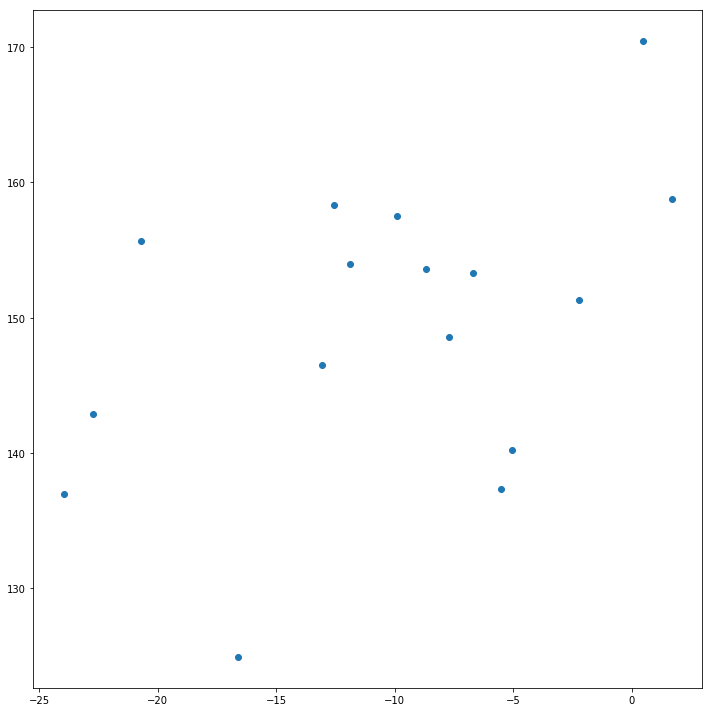

In [11]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=50000, batch_size=256, save_interval=1000)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

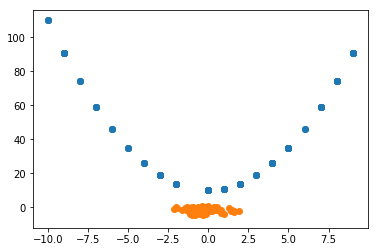

In [30]:
generator = make_generator_model()
noise = np.random.uniform(-10.0, 10.0, size=[100, 3])
real_data = sample_data(100)
fake_data = generator.predict(noise)
fig = plt.figure()
plt.scatter(real_data[:,0], real_data[:,1])
plt.scatter(fake_data[:,0], fake_data[:,1])
plt.show()